In [1]:
import math
import numpy as np # linear algebra
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from skimage.transform import resize
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from tqdm import tqdm


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from keras.preprocessing import image
import matplotlib.pyplot as plt




/kaggle/input/dog-breed-identification/sample_submission.csv
/kaggle/input/dog-breed-identification/labels.csv
/kaggle/input/dog-breed-identification/test/09e51e17e2b756ff2ace8a87bd1443fa.jpg
/kaggle/input/dog-breed-identification/test/f7a32505c12649183c5991ecfa7d68b3.jpg
/kaggle/input/dog-breed-identification/test/bc6d50ffb4644feb34530aa58943e85b.jpg
/kaggle/input/dog-breed-identification/test/7cbc041e79135a572aad87904b5c9c57.jpg
/kaggle/input/dog-breed-identification/test/f3b603f10d6a344f0395fb46b242ff8e.jpg
/kaggle/input/dog-breed-identification/test/db55098d859d27a3c05b0e3fc41d43e7.jpg
/kaggle/input/dog-breed-identification/test/665bab06a3ea861c0812c778486988e3.jpg
/kaggle/input/dog-breed-identification/test/7b57911ea7559cebd6db308125926642.jpg
/kaggle/input/dog-breed-identification/test/df0d6ba158287cb2b3ed6459a22d42ba.jpg
/kaggle/input/dog-breed-identification/test/b80d89ad4a17ac2537ff46d251efcd7c.jpg
/kaggle/input/dog-breed-identification/test/06ecb29a374579fb320c1c7d2801cbe1.jp

# Reading Files

In [2]:
train_dir = '/kaggle/input/dog-breed-identification/train'
test_dir = '/kaggle/input/dog-breed-identification/test'

# Loading Labels and Display of first 5 images

In [3]:
from matplotlib import image as mpimg
# Load the labels
labels = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')

# Training images

Train Images:


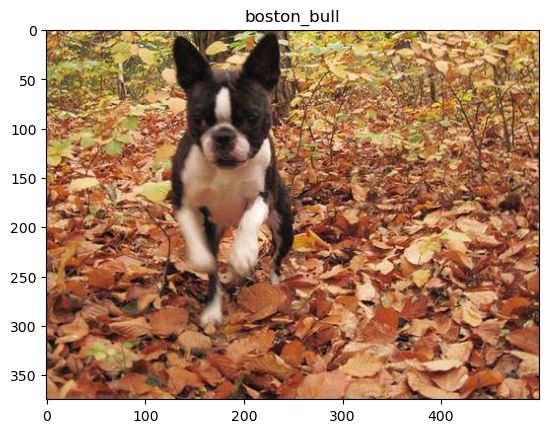

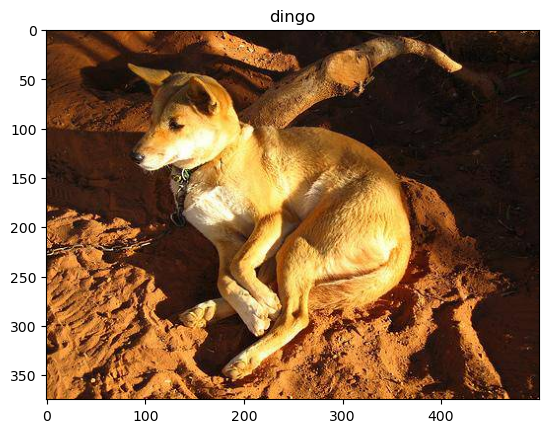

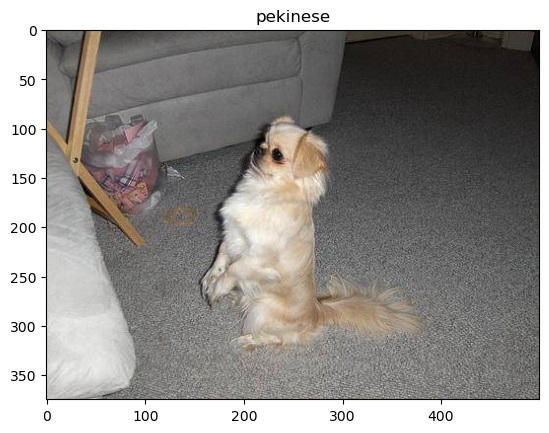

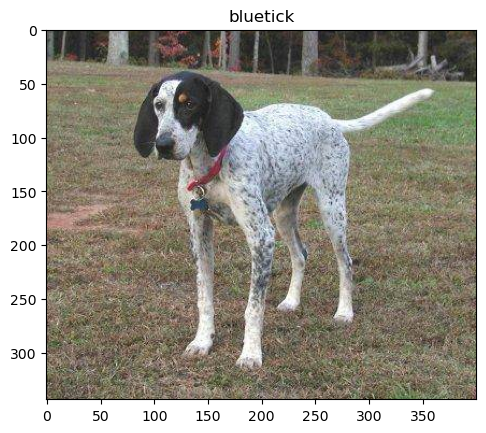

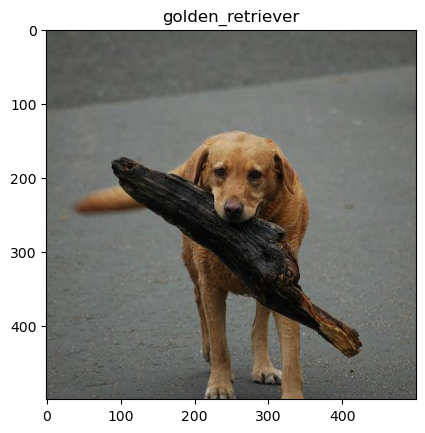

In [4]:


# Display the first 5 train images and their labels
print('Train Images:')
for i in range(5):
    # Get the image filename and label
    filename = labels.iloc[i]['id'] + '.jpg'
    label = labels.iloc[i]['breed']
    
    # Load and display the image
    img_path = os.path.join(train_dir, filename)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(label)
    plt.show()

# Test images

Test Images:


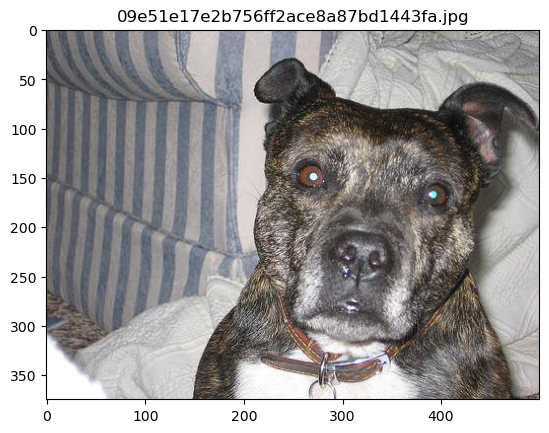

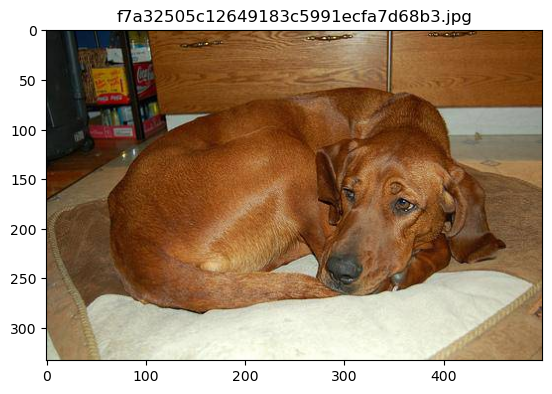

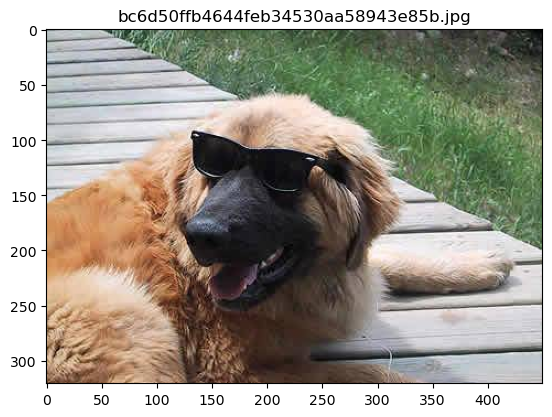

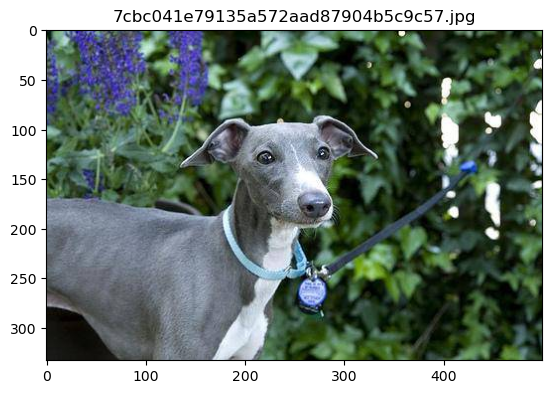

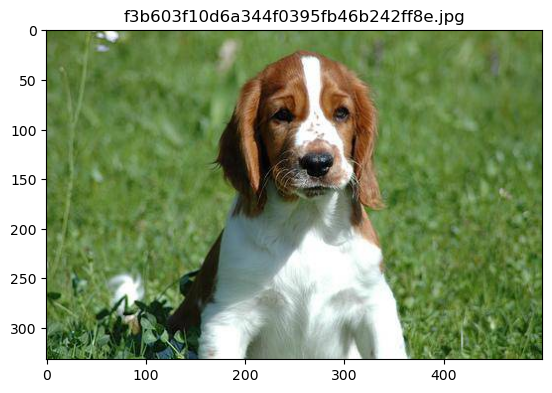

In [5]:
# Display the first 5 test images
print('Test Images:')
for i in range(5):
    # Get the image filename
    filename = os.listdir(test_dir)[i]
    
    # Load and display the image
    img_path = os.path.join(test_dir, filename)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(filename)
    plt.show()

# Sorting of Breeds

In [6]:
breeds = sorted(labels['breed'].unique())
num_classes = len(breeds)

# Mapping func

In [7]:
# Create a mapping from breed to integer label
breed_to_label = {breed: i for i, breed in enumerate(breeds)}

# Image Sizing

In [8]:
# Set the image size and batch size
img_size = 224
batch_size = 16

# Preprocessing

In [9]:
def load_and_preprocess_image(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.cast(img, tf.float32) / 255.0
    
    # One-hot encode the label
    label = tf.one_hot(label, num_classes)
    
    return img, label


In [10]:
def create_dataset(df, train_dir, batch_size):
    filenames = df['id'].apply(lambda x: os.path.join(train_dir, f"{x}.jpg")).values
    labels = df['breed'].map(breed_to_label).values
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

# MobileNetV2 architecture

In [11]:
base_model = MobileNetV2(weights='imagenet', include_top=False)

9406464/9406464 [==============================] - 0s 0us/step


# Activation Func

In [12]:
# Add a global average pooling layer, followed by a dense layer with softmax activation
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create a new model with the added layers
model = Model(inputs=base_model.input, outputs=predictions)

# Modelling

In [13]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model using the Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Calculate the number of batches per epoch
batches_per_epoch = math.ceil(len(labels) / batch_size)


# Train the model for 10 epochs using tf.data.Dataset
for epoch in range(10):
    print('Epoch', epoch + 1)

    # Create a progress bar object for this epoch
    pbar = tqdm(total=batches_per_epoch)

    # Shuffle the data
    labels = labels.sample(frac=1).reset_index(drop=True)

    # Load and preprocess the data using tf.data.Dataset
    dataset = create_dataset(labels, train_dir, batch_size)
    
    # Train the model on the dataset
    for x_batch, y_batch in dataset:
        model.train_on_batch(x_batch, y_batch.numpy())  # Convert y_batch to numpy array

        # Update the progress bar
        pbar.update(1)
    pbar.close()


Epoch 1


100%|██████████| 639/639 [00:35<00:00, 18.10it/s]


Epoch 2


100%|██████████| 639/639 [00:24<00:00, 26.27it/s]


Epoch 3


100%|██████████| 639/639 [00:24<00:00, 25.73it/s]


Epoch 4


100%|██████████| 639/639 [00:24<00:00, 25.96it/s]


Epoch 5


100%|██████████| 639/639 [00:24<00:00, 25.91it/s]


Epoch 6


100%|██████████| 639/639 [00:24<00:00, 26.18it/s]


Epoch 7


100%|██████████| 639/639 [00:24<00:00, 25.99it/s]


Epoch 8


100%|██████████| 639/639 [00:24<00:00, 25.91it/s]


Epoch 9


100%|██████████| 639/639 [00:24<00:00, 26.02it/s]


Epoch 10


100%|██████████| 639/639 [00:24<00:00, 25.94it/s]


In [15]:
test_filenames = os.listdir(test_dir)

# Create a function to load and preprocess a test image
def load_and_preprocess_test_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Create a list to store the predictions
predictions_list = []

# Load and preprocess the test data and make predictions
for filename in tqdm(test_filenames):
    img_path = os.path.join(test_dir, filename)
    img = load_and_preprocess_test_image(img_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    predicted_label = breeds[np.argmax(prediction)]  # Convert prediction to label
    predictions_list.append((filename.split('.')[0], predicted_label))

# Create a DataFrame from the list of predictions
submission_df = pd.DataFrame(predictions_list, columns=['id', 'breed'])

# Save the DataFrame to a CSV file
submission_df.to_csv('Dog_breed_Submission.csv', index=False)

  0%|          | 0/10357 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  0%|          | 1/10357 [00:01<3:23:13,  1.18s/it]

1/1 [==============================] - 0s 26ms/step


  0%|          | 3/10357 [00:01<1:02:51,  2.75it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 5/10357 [00:01<37:26,  4.61it/s]  

1/1 [==============================] - 0s 26ms/step


  0%|          | 7/10357 [00:01<27:30,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 9/10357 [00:01<21:55,  7.87it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 11/10357 [00:01<19:12,  8.98it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 13/10357 [00:02<17:40,  9.75it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 15/10357 [00:02<15:58, 10.79it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 17/10357 [00:02<15:09, 11.37it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 19/10357 [00:02<14:25, 11.95it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 21/10357 [00:02<13:58, 12.32it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 23/10357 [00:02<13:29, 12.77it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 25/10357 [00:03<13:57, 12.34it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 27/10357 [00:03<13:36, 12.65it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 29/10357 [00:03<13:17, 12.94it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 31/10357 [00:03<13:01, 13.22it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 33/10357 [00:03<13:18, 12.93it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 35/10357 [00:03<13:17, 12.95it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 37/10357 [00:03<13:03, 13.18it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 39/10357 [00:04<13:10, 13.06it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 41/10357 [00:04<12:54, 13.32it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 43/10357 [00:04<13:03, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 45/10357 [00:04<12:57, 13.27it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 47/10357 [00:04<12:51, 13.37it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 49/10357 [00:04<12:48, 13.41it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 51/10357 [00:05<13:13, 12.99it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 53/10357 [00:05<13:29, 12.73it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 55/10357 [00:05<13:22, 12.83it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 57/10357 [00:05<13:11, 13.01it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 59/10357 [00:05<13:03, 13.14it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 61/10357 [00:05<13:09, 13.05it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 63/10357 [00:05<13:04, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 65/10357 [00:06<13:00, 13.19it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 67/10357 [00:06<12:54, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 69/10357 [00:06<12:55, 13.27it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 71/10357 [00:06<13:05, 13.10it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 73/10357 [00:06<12:57, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 75/10357 [00:06<12:53, 13.29it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 77/10357 [00:06<12:54, 13.27it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 79/10357 [00:07<13:16, 12.90it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 81/10357 [00:07<13:15, 12.91it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 83/10357 [00:07<13:09, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 85/10357 [00:07<13:05, 13.08it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 87/10357 [00:07<12:48, 13.36it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 89/10357 [00:07<13:02, 13.12it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 91/10357 [00:08<13:00, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 93/10357 [00:08<12:49, 13.34it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 95/10357 [00:08<12:47, 13.38it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 97/10357 [00:08<12:48, 13.35it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 99/10357 [00:08<12:47, 13.37it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 101/10357 [00:08<12:41, 13.47it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 103/10357 [00:08<12:48, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 105/10357 [00:09<12:50, 13.31it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 107/10357 [00:09<13:09, 12.98it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 109/10357 [00:09<13:03, 13.08it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 111/10357 [00:09<12:59, 13.14it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 113/10357 [00:09<12:54, 13.23it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 115/10357 [00:09<13:14, 12.89it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 117/10357 [00:10<21:45,  7.84it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 119/10357 [00:10<19:23,  8.80it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 121/10357 [00:10<17:40,  9.66it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 123/10357 [00:10<16:15, 10.49it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 125/10357 [00:11<15:53, 10.73it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 127/10357 [00:11<15:19, 11.12it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 129/10357 [00:11<15:23, 11.07it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 131/10357 [00:11<15:19, 11.13it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 133/10357 [00:11<15:18, 11.13it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 135/10357 [00:11<14:50, 11.48it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 137/10357 [00:12<14:39, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 139/10357 [00:12<14:59, 11.36it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 141/10357 [00:12<14:42, 11.57it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 143/10357 [00:12<14:16, 11.92it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 145/10357 [00:12<13:51, 12.27it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 147/10357 [00:12<13:25, 12.67it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 149/10357 [00:13<13:05, 12.99it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 151/10357 [00:13<13:18, 12.78it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 153/10357 [00:13<13:19, 12.76it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 155/10357 [00:13<13:21, 12.74it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 157/10357 [00:13<13:03, 13.01it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 159/10357 [00:13<13:09, 12.91it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 161/10357 [00:13<13:13, 12.84it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 163/10357 [00:14<13:07, 12.95it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 165/10357 [00:14<12:56, 13.13it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 167/10357 [00:14<12:50, 13.23it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 169/10357 [00:14<12:58, 13.08it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 171/10357 [00:14<13:01, 13.03it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 173/10357 [00:14<12:48, 13.25it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 175/10357 [00:15<12:46, 13.29it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 177/10357 [00:15<13:06, 12.94it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 179/10357 [00:15<13:01, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 181/10357 [00:15<12:41, 13.35it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 183/10357 [00:15<12:49, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 185/10357 [00:15<12:44, 13.30it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 187/10357 [00:15<12:56, 13.09it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 189/10357 [00:16<12:49, 13.21it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 191/10357 [00:16<12:57, 13.07it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 193/10357 [00:16<12:47, 13.25it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 195/10357 [00:16<13:00, 13.02it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 197/10357 [00:16<12:54, 13.11it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 199/10357 [00:16<12:45, 13.26it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 201/10357 [00:16<12:36, 13.43it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 203/10357 [00:17<12:38, 13.38it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 205/10357 [00:17<12:56, 13.07it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 207/10357 [00:17<12:49, 13.18it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 209/10357 [00:17<12:39, 13.36it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 211/10357 [00:17<12:42, 13.30it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 213/10357 [00:17<12:53, 13.12it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 215/10357 [00:18<12:52, 13.13it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 217/10357 [00:18<12:52, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 219/10357 [00:18<12:50, 13.17it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 221/10357 [00:18<12:51, 13.13it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 223/10357 [00:18<12:56, 13.06it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 225/10357 [00:18<12:49, 13.17it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 227/10357 [00:18<12:41, 13.30it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 229/10357 [00:19<12:34, 13.42it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 231/10357 [00:19<12:41, 13.29it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 233/10357 [00:19<12:39, 13.32it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 235/10357 [00:19<12:32, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 237/10357 [00:19<12:30, 13.49it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 239/10357 [00:19<12:29, 13.50it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 241/10357 [00:19<12:49, 13.14it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 243/10357 [00:20<12:48, 13.17it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 245/10357 [00:20<12:39, 13.31it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 247/10357 [00:20<12:39, 13.31it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 249/10357 [00:20<12:54, 13.05it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 251/10357 [00:20<12:50, 13.12it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 253/10357 [00:20<12:47, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 255/10357 [00:21<12:49, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 257/10357 [00:21<12:48, 13.15it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 259/10357 [00:21<13:06, 12.84it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 261/10357 [00:21<13:07, 12.83it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 263/10357 [00:21<12:50, 13.10it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 265/10357 [00:21<12:41, 13.26it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 267/10357 [00:21<12:59, 12.95it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 269/10357 [00:22<13:28, 12.47it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 271/10357 [00:22<13:18, 12.62it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 273/10357 [00:22<13:04, 12.86it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 275/10357 [00:22<12:50, 13.08it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 277/10357 [00:22<13:07, 12.80it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 279/10357 [00:22<12:59, 12.94it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 281/10357 [00:23<12:46, 13.14it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 283/10357 [00:23<12:39, 13.26it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 285/10357 [00:23<12:52, 13.03it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 287/10357 [00:23<12:47, 13.12it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 289/10357 [00:23<13:07, 12.79it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 291/10357 [00:23<13:16, 12.64it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 293/10357 [00:24<13:06, 12.80it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 295/10357 [00:24<13:18, 12.60it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 297/10357 [00:24<13:13, 12.67it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 299/10357 [00:24<13:03, 12.83it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 301/10357 [00:24<12:49, 13.07it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 303/10357 [00:24<12:56, 12.94it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 305/10357 [00:24<12:56, 12.94it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 307/10357 [00:25<13:04, 12.82it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 309/10357 [00:25<13:28, 12.43it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 311/10357 [00:25<13:31, 12.38it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 313/10357 [00:25<13:43, 12.20it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 315/10357 [00:25<13:34, 12.33it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 317/10357 [00:25<13:13, 12.65it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 319/10357 [00:26<12:57, 12.91it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 321/10357 [00:26<13:30, 12.38it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 323/10357 [00:26<13:39, 12.24it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 325/10357 [00:26<13:18, 12.56it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 327/10357 [00:26<13:09, 12.71it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 329/10357 [00:26<13:05, 12.77it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 331/10357 [00:27<13:17, 12.58it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 333/10357 [00:27<13:06, 12.75it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 335/10357 [00:27<13:13, 12.64it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 337/10357 [00:27<13:03, 12.79it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 339/10357 [00:27<13:03, 12.78it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 341/10357 [00:27<12:49, 13.02it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 343/10357 [00:27<12:40, 13.16it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 345/10357 [00:28<12:48, 13.03it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 347/10357 [00:28<12:42, 13.12it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 349/10357 [00:28<12:45, 13.08it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 351/10357 [00:28<12:57, 12.87it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 353/10357 [00:28<12:44, 13.09it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 355/10357 [00:28<12:31, 13.31it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 357/10357 [00:29<12:39, 13.16it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 359/10357 [00:29<12:41, 13.14it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 361/10357 [00:29<12:53, 12.92it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 363/10357 [00:29<12:45, 13.05it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 365/10357 [00:29<12:35, 13.23it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 367/10357 [00:29<12:42, 13.10it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 369/10357 [00:29<12:40, 13.13it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 371/10357 [00:30<12:44, 13.06it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 373/10357 [00:30<12:57, 12.84it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 375/10357 [00:30<13:04, 12.73it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 377/10357 [00:30<12:57, 12.83it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 379/10357 [00:30<12:44, 13.05it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 381/10357 [00:30<12:36, 13.19it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 383/10357 [00:31<12:33, 13.24it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 385/10357 [00:31<12:55, 12.86it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 387/10357 [00:31<12:46, 13.01it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 389/10357 [00:31<12:36, 13.18it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 391/10357 [00:31<12:29, 13.30it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 393/10357 [00:31<12:38, 13.14it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 395/10357 [00:31<12:43, 13.04it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 397/10357 [00:32<13:04, 12.70it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 399/10357 [00:32<13:18, 12.47it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 401/10357 [00:32<12:51, 12.90it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 403/10357 [00:32<12:50, 12.91it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 405/10357 [00:32<12:52, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 407/10357 [00:32<12:37, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 409/10357 [00:33<12:24, 13.36it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 411/10357 [00:33<12:40, 13.08it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 413/10357 [00:33<12:43, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 415/10357 [00:33<12:36, 13.14it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 417/10357 [00:33<12:21, 13.40it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 419/10357 [00:33<12:17, 13.48it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 421/10357 [00:33<12:40, 13.06it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 423/10357 [00:34<12:47, 12.94it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 425/10357 [00:34<12:45, 12.97it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 427/10357 [00:34<12:32, 13.20it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 429/10357 [00:34<12:45, 12.97it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 431/10357 [00:34<12:38, 13.09it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 433/10357 [00:34<12:35, 13.14it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 435/10357 [00:34<12:27, 13.28it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 437/10357 [00:35<12:33, 13.17it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 439/10357 [00:35<12:50, 12.87it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 441/10357 [00:35<12:38, 13.07it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 443/10357 [00:35<13:24, 12.32it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 445/10357 [00:35<12:58, 12.73it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 447/10357 [00:35<13:00, 12.70it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 449/10357 [00:36<13:03, 12.65it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 451/10357 [00:36<12:54, 12.79it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 453/10357 [00:36<12:49, 12.87it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 455/10357 [00:36<12:41, 13.00it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 457/10357 [00:36<12:51, 12.83it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 459/10357 [00:36<12:37, 13.07it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 461/10357 [00:37<12:37, 13.06it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 463/10357 [00:37<12:35, 13.10it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 465/10357 [00:37<12:50, 12.83it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 467/10357 [00:37<12:45, 12.91it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 469/10357 [00:37<12:35, 13.08it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 471/10357 [00:37<12:46, 12.89it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 473/10357 [00:37<12:37, 13.06it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 475/10357 [00:38<12:49, 12.84it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 477/10357 [00:38<12:42, 12.96it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 479/10357 [00:38<12:32, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 481/10357 [00:38<12:19, 13.36it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 483/10357 [00:38<12:27, 13.21it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 485/10357 [00:38<12:29, 13.17it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 487/10357 [00:38<12:26, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 489/10357 [00:39<12:20, 13.32it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 491/10357 [00:39<12:25, 13.23it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 493/10357 [00:39<12:40, 12.98it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 495/10357 [00:39<12:37, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 497/10357 [00:39<12:29, 13.15it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 499/10357 [00:39<12:35, 13.05it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 501/10357 [00:40<12:47, 12.84it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 503/10357 [00:40<12:57, 12.68it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 505/10357 [00:40<12:44, 12.89it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 507/10357 [00:40<12:30, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 509/10357 [00:40<12:22, 13.26it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 511/10357 [00:40<12:35, 13.03it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 513/10357 [00:40<12:30, 13.12it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 515/10357 [00:41<12:25, 13.21it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 517/10357 [00:41<12:24, 13.22it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 519/10357 [00:41<12:44, 12.87it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 521/10357 [00:41<12:45, 12.86it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 523/10357 [00:41<12:45, 12.84it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 525/10357 [00:41<12:40, 12.92it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 527/10357 [00:42<12:57, 12.64it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 529/10357 [00:42<14:01, 11.68it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 531/10357 [00:42<13:39, 11.99it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 533/10357 [00:42<14:05, 11.61it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 535/10357 [00:42<13:59, 11.70it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 537/10357 [00:42<14:15, 11.48it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 539/10357 [00:43<13:58, 11.71it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 541/10357 [00:43<14:37, 11.19it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 543/10357 [00:43<14:20, 11.40it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 545/10357 [00:43<13:54, 11.75it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 547/10357 [00:43<13:34, 12.04it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 549/10357 [00:43<13:01, 12.54it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 551/10357 [00:44<12:42, 12.86it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 553/10357 [00:44<12:37, 12.95it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 555/10357 [00:44<12:44, 12.82it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 557/10357 [00:44<12:41, 12.87it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 559/10357 [00:44<12:32, 13.02it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 561/10357 [00:44<12:27, 13.10it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 563/10357 [00:45<12:21, 13.21it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 565/10357 [00:45<12:41, 12.86it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 567/10357 [00:45<12:32, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 569/10357 [00:45<12:19, 13.24it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 571/10357 [00:45<12:15, 13.30it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 573/10357 [00:45<12:25, 13.12it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 575/10357 [00:45<12:26, 13.10it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 577/10357 [00:46<12:22, 13.17it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 579/10357 [00:46<12:19, 13.21it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 581/10357 [00:46<12:07, 13.43it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 583/10357 [00:46<12:22, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 585/10357 [00:46<12:15, 13.29it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 587/10357 [00:46<12:10, 13.37it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 589/10357 [00:46<12:10, 13.38it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 591/10357 [00:47<12:18, 13.23it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 593/10357 [00:47<12:22, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 595/10357 [00:47<12:18, 13.22it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 597/10357 [00:47<12:37, 12.89it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 599/10357 [00:47<12:24, 13.11it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 601/10357 [00:47<12:35, 12.90it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 603/10357 [00:48<12:24, 13.10it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 605/10357 [00:48<12:32, 12.95it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 607/10357 [00:48<12:20, 13.17it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 609/10357 [00:48<12:46, 12.72it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 611/10357 [00:48<13:57, 11.63it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 613/10357 [00:48<13:16, 12.24it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 615/10357 [00:49<12:48, 12.67it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 617/10357 [00:49<12:37, 12.85it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 619/10357 [00:49<12:50, 12.63it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 621/10357 [00:49<12:40, 12.80it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 623/10357 [00:49<12:30, 12.97it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 625/10357 [00:49<13:02, 12.44it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 627/10357 [00:50<13:14, 12.24it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 629/10357 [00:50<12:53, 12.58it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 631/10357 [00:50<12:46, 12.68it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 633/10357 [00:50<12:38, 12.81it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 635/10357 [00:50<12:32, 12.92it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 637/10357 [00:50<12:38, 12.81it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 639/10357 [00:50<12:34, 12.89it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 641/10357 [00:51<12:28, 12.98it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 643/10357 [00:51<12:22, 13.09it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 645/10357 [00:51<12:27, 12.99it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 647/10357 [00:51<12:24, 13.05it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 649/10357 [00:51<12:19, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 651/10357 [00:51<12:25, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 653/10357 [00:51<12:24, 13.04it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 655/10357 [00:52<13:05, 12.36it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 657/10357 [00:52<12:48, 12.62it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 659/10357 [00:52<12:32, 12.89it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 661/10357 [00:52<12:16, 13.17it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 663/10357 [00:52<12:20, 13.10it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 665/10357 [00:52<12:18, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 667/10357 [00:53<12:06, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 669/10357 [00:53<12:09, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 671/10357 [00:53<12:07, 13.32it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 673/10357 [00:53<12:18, 13.12it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 675/10357 [00:53<12:14, 13.18it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 677/10357 [00:53<12:13, 13.19it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 679/10357 [00:53<12:13, 13.19it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 681/10357 [00:54<12:29, 12.92it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 683/10357 [00:54<12:25, 12.97it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 685/10357 [00:54<12:12, 13.21it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 687/10357 [00:54<12:08, 13.27it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 689/10357 [00:54<12:05, 13.33it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 691/10357 [00:54<12:25, 12.97it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 693/10357 [00:55<12:24, 12.98it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 695/10357 [00:55<12:14, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 697/10357 [00:55<12:04, 13.33it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 699/10357 [00:55<12:20, 13.04it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 701/10357 [00:55<12:24, 12.98it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 703/10357 [00:55<12:32, 12.83it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 705/10357 [00:55<12:50, 12.53it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 707/10357 [00:56<12:42, 12.65it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 709/10357 [00:56<12:59, 12.38it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 711/10357 [00:56<12:44, 12.62it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 713/10357 [00:56<12:21, 13.00it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 715/10357 [00:56<12:12, 13.17it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 717/10357 [00:56<12:31, 12.82it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 719/10357 [00:57<12:26, 12.91it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 721/10357 [00:57<12:18, 13.05it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 723/10357 [00:57<12:04, 13.29it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 725/10357 [00:57<12:01, 13.36it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 727/10357 [00:57<12:10, 13.19it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 729/10357 [00:57<12:07, 13.24it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 731/10357 [00:57<12:04, 13.29it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 733/10357 [00:58<12:04, 13.28it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 735/10357 [00:58<12:10, 13.18it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 737/10357 [00:58<12:08, 13.21it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 739/10357 [00:58<12:04, 13.27it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 741/10357 [00:58<12:19, 13.00it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 743/10357 [00:58<12:07, 13.21it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 745/10357 [00:59<12:38, 12.67it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 747/10357 [00:59<12:54, 12.41it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 749/10357 [00:59<12:33, 12.75it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 751/10357 [00:59<12:17, 13.02it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 753/10357 [00:59<12:32, 12.77it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 755/10357 [00:59<12:46, 12.53it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 757/10357 [00:59<12:30, 12.79it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 759/10357 [01:00<12:23, 12.91it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 761/10357 [01:00<12:12, 13.11it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 763/10357 [01:00<12:31, 12.76it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 765/10357 [01:00<12:35, 12.70it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 767/10357 [01:00<12:24, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 769/10357 [01:00<12:10, 13.13it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 771/10357 [01:01<12:13, 13.07it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 773/10357 [01:01<12:06, 13.19it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 775/10357 [01:01<12:23, 12.89it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 777/10357 [01:01<12:20, 12.94it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 779/10357 [01:01<12:13, 13.05it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 781/10357 [01:01<12:18, 12.96it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 783/10357 [01:02<12:32, 12.72it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 785/10357 [01:02<12:56, 12.33it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 787/10357 [01:02<12:38, 12.61it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 789/10357 [01:02<12:45, 12.50it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 791/10357 [01:02<12:35, 12.66it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 793/10357 [01:02<12:28, 12.77it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 795/10357 [01:02<12:17, 12.97it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 797/10357 [01:03<12:16, 12.98it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 799/10357 [01:03<12:36, 12.64it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 801/10357 [01:03<12:22, 12.86it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 803/10357 [01:03<12:16, 12.97it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 805/10357 [01:03<12:12, 13.03it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 807/10357 [01:03<12:17, 12.94it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 809/10357 [01:04<12:10, 13.07it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 811/10357 [01:04<12:03, 13.19it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 813/10357 [01:04<11:59, 13.27it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 815/10357 [01:04<12:01, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 817/10357 [01:04<12:08, 13.10it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 819/10357 [01:04<12:01, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 821/10357 [01:04<11:52, 13.39it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 823/10357 [01:05<12:03, 13.18it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 825/10357 [01:05<12:05, 13.13it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 827/10357 [01:05<12:11, 13.04it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 829/10357 [01:05<12:12, 13.02it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 831/10357 [01:05<12:00, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 833/10357 [01:05<11:55, 13.31it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 835/10357 [01:06<12:14, 12.97it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 837/10357 [01:06<12:09, 13.05it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 839/10357 [01:06<12:00, 13.20it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 841/10357 [01:06<11:52, 13.36it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 843/10357 [01:06<12:08, 13.06it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 845/10357 [01:06<12:08, 13.06it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 847/10357 [01:06<12:00, 13.20it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 849/10357 [01:07<12:05, 13.11it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 851/10357 [01:07<11:56, 13.26it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 853/10357 [01:07<12:10, 13.00it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 855/10357 [01:07<12:08, 13.05it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 857/10357 [01:07<11:55, 13.27it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 859/10357 [01:07<11:45, 13.46it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 861/10357 [01:07<12:05, 13.09it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 863/10357 [01:08<12:02, 13.14it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 865/10357 [01:08<12:17, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 867/10357 [01:08<12:06, 13.06it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 869/10357 [01:08<12:08, 13.03it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 871/10357 [01:08<12:20, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 873/10357 [01:08<12:13, 12.92it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 875/10357 [01:09<12:44, 12.41it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 877/10357 [01:09<12:23, 12.74it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 879/10357 [01:09<12:17, 12.86it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 881/10357 [01:09<12:10, 12.97it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 883/10357 [01:09<12:17, 12.84it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 885/10357 [01:09<12:08, 13.01it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 887/10357 [01:09<12:02, 13.10it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 889/10357 [01:10<12:12, 12.93it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 891/10357 [01:10<12:09, 12.97it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 893/10357 [01:10<11:55, 13.23it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 895/10357 [01:10<11:55, 13.23it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 897/10357 [01:10<11:59, 13.15it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 899/10357 [01:10<11:56, 13.21it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 901/10357 [01:11<11:54, 13.23it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 903/10357 [01:11<11:50, 13.30it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 905/10357 [01:11<11:50, 13.31it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 907/10357 [01:11<12:09, 12.95it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 909/10357 [01:11<12:06, 13.00it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 911/10357 [01:11<12:08, 12.96it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 913/10357 [01:11<12:16, 12.82it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 915/10357 [01:12<13:05, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 917/10357 [01:12<12:58, 12.12it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 919/10357 [01:12<12:43, 12.36it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 921/10357 [01:12<12:23, 12.68it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 923/10357 [01:12<12:11, 12.90it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 925/10357 [01:12<12:21, 12.73it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 927/10357 [01:13<12:10, 12.90it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 929/10357 [01:13<12:03, 13.03it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 931/10357 [01:13<11:57, 13.14it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 933/10357 [01:13<12:13, 12.85it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 935/10357 [01:13<12:08, 12.94it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 937/10357 [01:13<12:18, 12.75it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 939/10357 [01:14<12:49, 12.24it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 941/10357 [01:14<13:06, 11.98it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 943/10357 [01:14<13:26, 11.67it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 945/10357 [01:14<13:18, 11.79it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 947/10357 [01:14<13:15, 11.83it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 949/10357 [01:14<12:59, 12.06it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 951/10357 [01:15<12:45, 12.28it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 953/10357 [01:15<12:16, 12.77it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 955/10357 [01:15<11:58, 13.08it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 957/10357 [01:15<11:49, 13.24it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 959/10357 [01:15<11:43, 13.36it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 961/10357 [01:15<12:12, 12.83it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 963/10357 [01:15<12:11, 12.84it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 965/10357 [01:16<11:59, 13.05it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 967/10357 [01:16<11:54, 13.13it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 969/10357 [01:16<12:03, 12.97it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 971/10357 [01:16<11:55, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 973/10357 [01:16<11:51, 13.18it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 975/10357 [01:16<11:46, 13.29it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 977/10357 [01:17<11:40, 13.39it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 979/10357 [01:17<11:56, 13.09it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 981/10357 [01:17<11:52, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 983/10357 [01:17<11:45, 13.29it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 985/10357 [01:17<11:36, 13.45it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 987/10357 [01:17<11:43, 13.32it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 989/10357 [01:17<11:45, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 991/10357 [01:18<11:38, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 993/10357 [01:18<11:30, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 995/10357 [01:18<11:38, 13.41it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 997/10357 [01:18<11:55, 13.08it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 999/10357 [01:18<11:52, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 1001/10357 [01:18<11:46, 13.24it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 1003/10357 [01:18<11:42, 13.31it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 1005/10357 [01:19<11:52, 13.12it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 1007/10357 [01:19<11:50, 13.17it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 1009/10357 [01:19<11:48, 13.20it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 1011/10357 [01:19<11:44, 13.27it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 1013/10357 [01:19<11:42, 13.31it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 1015/10357 [01:19<11:52, 13.11it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 1017/10357 [01:20<11:48, 13.19it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 1019/10357 [01:20<11:38, 13.37it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 1021/10357 [01:20<11:35, 13.42it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 1023/10357 [01:20<11:43, 13.26it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 1025/10357 [01:20<11:44, 13.24it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 1027/10357 [01:20<11:35, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 1029/10357 [01:20<11:28, 13.54it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 1031/10357 [01:21<11:29, 13.53it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 1033/10357 [01:21<12:10, 12.76it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 1035/10357 [01:21<11:57, 12.99it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 1037/10357 [01:21<11:54, 13.04it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 1039/10357 [01:21<12:01, 12.91it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 1041/10357 [01:21<12:07, 12.80it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 1043/10357 [01:22<11:59, 12.94it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 1045/10357 [01:22<12:15, 12.67it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 1047/10357 [01:22<12:06, 12.81it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 1049/10357 [01:22<12:12, 12.71it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 1051/10357 [01:22<12:11, 12.72it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 1053/10357 [01:22<12:01, 12.89it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 1055/10357 [01:22<11:52, 13.06it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 1057/10357 [01:23<11:55, 13.00it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 1059/10357 [01:23<12:02, 12.86it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 1061/10357 [01:23<12:02, 12.86it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 1063/10357 [01:23<11:56, 12.96it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 1065/10357 [01:23<11:46, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 1067/10357 [01:23<11:42, 13.22it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 1069/10357 [01:24<11:51, 13.06it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 1071/10357 [01:24<12:02, 12.85it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 1073/10357 [01:24<11:53, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 1075/10357 [01:24<12:01, 12.86it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 1077/10357 [01:24<12:06, 12.78it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 1079/10357 [01:24<12:22, 12.50it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 1081/10357 [01:24<12:08, 12.72it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 1083/10357 [01:25<11:54, 12.99it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 1085/10357 [01:25<11:44, 13.17it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 1087/10357 [01:25<11:58, 12.91it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1089/10357 [01:25<12:33, 12.30it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1091/10357 [01:25<12:07, 12.73it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1093/10357 [01:25<11:55, 12.95it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1095/10357 [01:26<11:58, 12.89it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1097/10357 [01:26<11:53, 12.98it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1099/10357 [01:26<11:41, 13.20it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 1101/10357 [01:26<12:01, 12.83it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1103/10357 [01:26<11:46, 13.09it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 1105/10357 [01:26<12:05, 12.75it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1107/10357 [01:26<12:08, 12.70it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1109/10357 [01:27<12:02, 12.81it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1111/10357 [01:27<11:49, 13.03it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 1113/10357 [01:27<11:53, 12.96it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1115/10357 [01:27<11:52, 12.98it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1117/10357 [01:27<11:40, 13.20it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1119/10357 [01:27<11:26, 13.46it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1121/10357 [01:28<12:44, 12.08it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1123/10357 [01:28<12:38, 12.18it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1125/10357 [01:28<12:31, 12.28it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 1127/10357 [01:28<12:18, 12.49it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1129/10357 [01:28<12:24, 12.39it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 1131/10357 [01:28<12:28, 12.32it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1133/10357 [01:29<12:18, 12.49it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1135/10357 [01:29<12:18, 12.49it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1137/10357 [01:29<11:58, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1139/10357 [01:29<11:45, 13.07it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 1141/10357 [01:29<11:53, 12.91it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1143/10357 [01:29<11:47, 13.02it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1145/10357 [01:29<11:36, 13.22it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1147/10357 [01:30<11:37, 13.21it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 1149/10357 [01:30<11:53, 12.91it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1151/10357 [01:30<12:02, 12.75it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 1153/10357 [01:30<12:09, 12.62it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1155/10357 [01:30<11:52, 12.92it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1157/10357 [01:30<11:44, 13.06it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1159/10357 [01:31<12:00, 12.76it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1161/10357 [01:31<11:54, 12.87it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 1163/10357 [01:31<11:48, 12.99it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 1165/10357 [01:31<11:57, 12.81it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 1167/10357 [01:31<12:05, 12.67it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 1169/10357 [01:31<11:56, 12.81it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 1171/10357 [01:31<11:54, 12.85it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 1173/10357 [01:32<12:17, 12.45it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 1175/10357 [01:32<12:12, 12.54it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 1177/10357 [01:32<12:19, 12.41it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 1179/10357 [01:32<12:06, 12.63it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 1181/10357 [01:32<11:51, 12.90it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 1183/10357 [01:32<12:01, 12.72it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 1185/10357 [01:33<12:02, 12.69it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 1187/10357 [01:33<12:46, 11.96it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 1189/10357 [01:33<12:40, 12.05it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 1191/10357 [01:33<12:15, 12.47it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 1193/10357 [01:33<11:52, 12.87it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 1195/10357 [01:33<11:56, 12.78it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1197/10357 [01:34<12:00, 12.71it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1199/10357 [01:34<11:45, 12.97it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 1201/10357 [01:34<11:41, 13.06it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1203/10357 [01:34<12:03, 12.64it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1205/10357 [01:34<11:52, 12.85it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 1207/10357 [01:34<11:38, 13.11it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1209/10357 [01:34<11:45, 12.96it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1211/10357 [01:35<11:42, 13.02it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 1213/10357 [01:35<11:58, 12.72it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1215/10357 [01:35<11:52, 12.83it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 1217/10357 [01:35<11:34, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1219/10357 [01:35<11:21, 13.41it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 1221/10357 [01:35<11:27, 13.28it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 1223/10357 [01:36<11:24, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1225/10357 [01:36<11:20, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1227/10357 [01:36<11:17, 13.47it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1229/10357 [01:36<11:13, 13.56it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 1231/10357 [01:36<11:24, 13.33it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 1233/10357 [01:36<11:23, 13.34it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 1235/10357 [01:36<11:18, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1237/10357 [01:37<11:13, 13.54it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1239/10357 [01:37<11:29, 13.23it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 1241/10357 [01:37<11:24, 13.32it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1243/10357 [01:37<11:19, 13.41it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 1245/10357 [01:37<11:12, 13.54it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1247/10357 [01:37<11:05, 13.69it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 1249/10357 [01:37<11:25, 13.29it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1251/10357 [01:38<11:24, 13.30it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1253/10357 [01:38<11:23, 13.31it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1255/10357 [01:38<11:22, 13.33it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 1257/10357 [01:38<11:31, 13.17it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 1259/10357 [01:38<11:32, 13.14it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1261/10357 [01:38<11:20, 13.38it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1263/10357 [01:39<11:17, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1265/10357 [01:39<11:08, 13.61it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 1267/10357 [01:39<11:26, 13.24it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 1269/10357 [01:39<11:24, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1271/10357 [01:39<11:16, 13.43it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1273/10357 [01:39<11:17, 13.41it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 1275/10357 [01:39<11:24, 13.27it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 1277/10357 [01:40<11:27, 13.20it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 1279/10357 [01:40<11:21, 13.32it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 1281/10357 [01:40<11:22, 13.30it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1283/10357 [01:40<11:18, 13.37it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1285/10357 [01:40<11:30, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1287/10357 [01:40<11:31, 13.11it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1289/10357 [01:41<11:25, 13.23it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1291/10357 [01:41<11:20, 13.32it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 1293/10357 [01:41<11:29, 13.15it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1295/10357 [01:41<11:34, 13.04it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1297/10357 [01:41<11:25, 13.21it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1299/10357 [01:41<11:27, 13.18it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1301/10357 [01:41<11:25, 13.21it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 1303/10357 [01:42<11:55, 12.66it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1305/10357 [01:42<12:00, 12.57it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1307/10357 [01:42<11:58, 12.60it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1309/10357 [01:42<12:12, 12.35it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1311/10357 [01:42<12:09, 12.40it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1313/10357 [01:42<12:05, 12.46it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1315/10357 [01:43<11:55, 12.64it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1317/10357 [01:43<11:52, 12.70it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1319/10357 [01:43<11:40, 12.91it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1321/10357 [01:43<11:55, 12.63it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1323/10357 [01:43<11:48, 12.75it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1325/10357 [01:43<11:36, 12.97it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1327/10357 [01:43<11:36, 12.97it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1329/10357 [01:44<11:48, 12.75it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1331/10357 [01:44<11:49, 12.72it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1333/10357 [01:44<11:51, 12.69it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1335/10357 [01:44<11:44, 12.81it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1337/10357 [01:44<11:58, 12.55it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1339/10357 [01:44<12:06, 12.42it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1341/10357 [01:45<11:57, 12.56it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1343/10357 [01:45<12:34, 11.94it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1345/10357 [01:45<13:03, 11.50it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1347/10357 [01:45<13:13, 11.35it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1349/10357 [01:45<12:45, 11.76it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1351/10357 [01:45<12:26, 12.07it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1353/10357 [01:46<12:05, 12.42it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1355/10357 [01:46<11:56, 12.57it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1357/10357 [01:46<11:57, 12.54it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1359/10357 [01:46<11:43, 12.80it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1361/10357 [01:46<11:23, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1363/10357 [01:46<11:14, 13.33it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1365/10357 [01:47<11:34, 12.95it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1367/10357 [01:47<11:35, 12.93it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1369/10357 [01:47<11:29, 13.04it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1371/10357 [01:47<11:27, 13.08it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1373/10357 [01:47<11:24, 13.12it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1375/10357 [01:47<11:42, 12.78it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1377/10357 [01:47<11:42, 12.79it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1379/10357 [01:48<11:33, 12.95it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1381/10357 [01:48<11:30, 13.00it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 1383/10357 [01:48<11:46, 12.71it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1385/10357 [01:48<11:44, 12.73it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1387/10357 [01:48<11:36, 12.89it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1389/10357 [01:48<11:37, 12.86it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1391/10357 [01:49<11:23, 13.11it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 1393/10357 [01:49<22:49,  6.55it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 1395/10357 [01:49<19:46,  7.55it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 1397/10357 [01:50<17:38,  8.46it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 1399/10357 [01:50<16:01,  9.31it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 1401/10357 [01:50<15:09,  9.85it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 1403/10357 [01:50<14:25, 10.34it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 1405/10357 [01:50<13:52, 10.76it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 1407/10357 [01:50<13:35, 10.98it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 1409/10357 [01:51<13:22, 11.15it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 1411/10357 [01:51<13:31, 11.03it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 1413/10357 [01:51<13:19, 11.18it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 1415/10357 [01:51<13:15, 11.25it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 1417/10357 [01:51<13:11, 11.30it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 1419/10357 [01:51<13:23, 11.12it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 1421/10357 [01:52<13:41, 10.88it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 1423/10357 [01:52<13:20, 11.16it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 1425/10357 [01:52<13:10, 11.29it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 1427/10357 [01:52<13:06, 11.36it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1429/10357 [01:52<13:16, 11.21it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 1431/10357 [01:53<13:05, 11.36it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 1433/10357 [01:53<12:56, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 1435/10357 [01:53<13:02, 11.41it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 1437/10357 [01:53<13:06, 11.34it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 1439/10357 [01:53<12:56, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1441/10357 [01:53<12:39, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1443/10357 [01:54<12:34, 11.81it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 1445/10357 [01:54<12:41, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 1447/10357 [01:54<13:07, 11.31it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1449/10357 [01:54<12:46, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 1451/10357 [01:54<12:23, 11.98it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1453/10357 [01:54<12:06, 12.25it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 1455/10357 [01:55<12:18, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1457/10357 [01:55<12:10, 12.19it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1459/10357 [01:55<11:56, 12.41it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1461/10357 [01:55<11:47, 12.57it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 1463/10357 [01:55<12:01, 12.33it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1465/10357 [01:55<11:54, 12.44it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1467/10357 [01:56<11:51, 12.49it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1469/10357 [01:56<11:45, 12.59it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1471/10357 [01:56<11:38, 12.73it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1473/10357 [01:56<11:50, 12.50it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1475/10357 [01:56<12:19, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1477/10357 [01:56<12:08, 12.19it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1479/10357 [01:56<12:00, 12.32it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 1481/10357 [01:57<12:15, 12.07it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1483/10357 [01:57<12:20, 11.98it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1485/10357 [01:57<11:59, 12.32it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1487/10357 [01:57<11:53, 12.43it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1489/10357 [01:57<12:04, 12.24it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1491/10357 [01:57<12:13, 12.09it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1493/10357 [01:58<12:13, 12.08it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1495/10357 [01:58<11:57, 12.34it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1497/10357 [01:58<11:47, 12.53it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1499/10357 [01:58<11:48, 12.50it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1501/10357 [01:58<11:40, 12.64it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 1503/10357 [01:58<11:32, 12.79it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 1505/10357 [01:59<11:22, 12.96it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1507/10357 [01:59<11:12, 13.16it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 1509/10357 [01:59<11:28, 12.85it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1511/10357 [01:59<11:26, 12.89it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1513/10357 [01:59<11:16, 13.07it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 1515/10357 [01:59<11:07, 13.25it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 1517/10357 [01:59<11:17, 13.05it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1519/10357 [02:00<11:12, 13.14it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 1521/10357 [02:00<11:01, 13.36it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1523/10357 [02:00<11:08, 13.22it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1525/10357 [02:00<11:19, 13.01it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 1527/10357 [02:00<11:38, 12.64it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 1529/10357 [02:00<11:41, 12.58it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 1531/10357 [02:01<11:36, 12.67it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1533/10357 [02:01<11:24, 12.90it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1535/10357 [02:01<11:35, 12.68it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1537/10357 [02:01<11:29, 12.78it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 1539/10357 [02:01<11:22, 12.92it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 1541/10357 [02:01<11:23, 12.91it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1543/10357 [02:02<11:46, 12.48it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1545/10357 [02:02<12:14, 12.00it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1547/10357 [02:02<12:07, 12.11it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1549/10357 [02:02<12:00, 12.23it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1551/10357 [02:02<11:49, 12.42it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1553/10357 [02:02<11:43, 12.51it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1555/10357 [02:02<11:29, 12.77it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 1557/10357 [02:03<11:20, 12.93it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 1559/10357 [02:03<11:18, 12.96it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 1561/10357 [02:03<11:09, 13.13it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1563/10357 [02:03<11:25, 12.83it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 1565/10357 [02:03<11:11, 13.09it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1567/10357 [02:03<11:05, 13.21it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 1569/10357 [02:04<11:00, 13.31it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1571/10357 [02:04<11:04, 13.22it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1573/10357 [02:04<11:11, 13.08it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1575/10357 [02:04<11:22, 12.87it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1577/10357 [02:04<11:12, 13.06it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 1579/10357 [02:04<11:04, 13.21it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1581/10357 [02:04<11:15, 12.99it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1583/10357 [02:05<11:21, 12.88it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1585/10357 [02:05<11:26, 12.78it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 1587/10357 [02:05<11:27, 12.75it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1589/10357 [02:05<11:28, 12.74it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 1591/10357 [02:05<11:21, 12.87it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1593/10357 [02:05<11:40, 12.51it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 1595/10357 [02:06<11:42, 12.47it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 1597/10357 [02:06<11:25, 12.79it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1599/10357 [02:06<11:31, 12.67it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1601/10357 [02:06<11:28, 12.72it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 1603/10357 [02:06<11:22, 12.83it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1605/10357 [02:06<11:12, 13.02it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1607/10357 [02:07<11:21, 12.85it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1609/10357 [02:07<11:11, 13.03it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1611/10357 [02:07<11:04, 13.16it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1613/10357 [02:07<11:00, 13.25it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1615/10357 [02:07<11:12, 13.00it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1617/10357 [02:07<11:24, 12.77it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1619/10357 [02:07<11:37, 12.52it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1621/10357 [02:08<11:26, 12.73it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1623/10357 [02:08<11:09, 13.04it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1625/10357 [02:08<11:13, 12.96it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1627/10357 [02:08<11:12, 12.98it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1629/10357 [02:08<11:06, 13.09it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1631/10357 [02:08<10:55, 13.31it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1633/10357 [02:09<11:06, 13.10it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1635/10357 [02:09<11:24, 12.73it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1637/10357 [02:09<11:20, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1639/10357 [02:09<11:23, 12.76it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1641/10357 [02:09<11:17, 12.86it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1643/10357 [02:09<11:21, 12.78it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1645/10357 [02:09<11:14, 12.91it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1647/10357 [02:10<11:06, 13.07it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1649/10357 [02:10<10:56, 13.26it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1651/10357 [02:10<11:23, 12.74it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1653/10357 [02:10<11:36, 12.50it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1655/10357 [02:10<11:22, 12.75it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1657/10357 [02:10<11:07, 13.03it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1659/10357 [02:11<10:59, 13.19it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1661/10357 [02:11<11:20, 12.79it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1663/10357 [02:11<11:23, 12.71it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1665/10357 [02:11<11:19, 12.80it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1667/10357 [02:11<11:08, 13.00it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1669/10357 [02:11<11:02, 13.11it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1671/10357 [02:11<11:18, 12.79it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 1673/10357 [02:12<11:37, 12.45it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1675/10357 [02:12<11:27, 12.63it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1677/10357 [02:12<11:24, 12.69it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1679/10357 [02:12<11:22, 12.72it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1681/10357 [02:12<11:09, 12.96it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1683/10357 [02:12<11:04, 13.05it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 1685/10357 [02:13<10:54, 13.24it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 1687/10357 [02:13<10:49, 13.35it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 1689/10357 [02:13<11:12, 12.88it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 1691/10357 [02:13<11:09, 12.94it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 1693/10357 [02:13<11:29, 12.57it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 1695/10357 [02:13<11:30, 12.55it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 1697/10357 [02:13<11:24, 12.66it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 1699/10357 [02:14<11:30, 12.53it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 1701/10357 [02:14<11:39, 12.38it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 1703/10357 [02:14<11:17, 12.78it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 1705/10357 [02:14<11:02, 13.05it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 1707/10357 [02:14<11:12, 12.87it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1709/10357 [02:14<11:12, 12.86it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1711/10357 [02:15<10:58, 13.12it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1713/10357 [02:15<11:04, 13.01it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1715/10357 [02:15<11:06, 12.97it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1717/10357 [02:15<11:01, 13.06it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1719/10357 [02:15<10:49, 13.29it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1721/10357 [02:15<10:43, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1723/10357 [02:15<10:37, 13.54it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1725/10357 [02:16<10:49, 13.29it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1727/10357 [02:16<10:57, 13.13it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1729/10357 [02:16<11:23, 12.63it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1731/10357 [02:16<11:57, 12.02it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1733/10357 [02:16<12:24, 11.58it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1735/10357 [02:16<12:13, 11.75it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1737/10357 [02:17<11:55, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1739/10357 [02:17<11:39, 12.32it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1741/10357 [02:17<11:39, 12.31it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1743/10357 [02:17<11:46, 12.19it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1745/10357 [02:17<11:26, 12.55it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1747/10357 [02:17<11:05, 12.93it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1749/10357 [02:18<10:53, 13.16it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1751/10357 [02:18<10:58, 13.07it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1753/10357 [02:18<10:58, 13.06it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1755/10357 [02:18<11:03, 12.97it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1757/10357 [02:18<11:12, 12.80it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1759/10357 [02:18<11:01, 13.01it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1761/10357 [02:19<11:08, 12.86it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1763/10357 [02:19<11:00, 13.00it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1765/10357 [02:19<10:57, 13.07it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1767/10357 [02:19<11:10, 12.82it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1769/10357 [02:19<11:15, 12.71it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1771/10357 [02:19<11:08, 12.85it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1773/10357 [02:19<10:58, 13.04it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1775/10357 [02:20<10:52, 13.14it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1777/10357 [02:20<10:45, 13.29it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1779/10357 [02:20<10:50, 13.18it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1781/10357 [02:20<10:53, 13.13it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1783/10357 [02:20<10:49, 13.21it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1785/10357 [02:20<10:59, 13.00it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1787/10357 [02:21<11:04, 12.91it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1789/10357 [02:21<10:57, 13.03it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1791/10357 [02:21<10:51, 13.14it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1793/10357 [02:21<10:45, 13.26it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1795/10357 [02:21<10:54, 13.09it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1797/10357 [02:21<10:55, 13.07it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1799/10357 [02:21<10:54, 13.07it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1801/10357 [02:22<11:08, 12.80it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1803/10357 [02:22<11:20, 12.58it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1805/10357 [02:22<11:21, 12.55it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1807/10357 [02:22<11:13, 12.70it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1809/10357 [02:22<11:04, 12.87it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1811/10357 [02:22<10:51, 13.12it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1813/10357 [02:23<10:49, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1815/10357 [02:23<10:49, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1817/10357 [02:23<10:40, 13.34it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1819/10357 [02:23<11:29, 12.39it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1821/10357 [02:23<11:10, 12.73it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1823/10357 [02:23<11:10, 12.73it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1825/10357 [02:23<11:22, 12.50it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1827/10357 [02:24<11:11, 12.70it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1829/10357 [02:24<10:59, 12.93it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1831/10357 [02:24<10:51, 13.09it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1833/10357 [02:24<11:04, 12.83it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1835/10357 [02:24<11:16, 12.60it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1837/10357 [02:24<10:59, 12.91it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1839/10357 [02:25<10:57, 12.96it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1841/10357 [02:25<11:02, 12.86it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1843/10357 [02:25<11:00, 12.88it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1845/10357 [02:25<10:56, 12.97it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1847/10357 [02:25<10:53, 13.03it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1849/10357 [02:25<10:49, 13.10it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1851/10357 [02:25<11:02, 12.84it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1853/10357 [02:26<10:52, 13.04it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1855/10357 [02:26<10:46, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1857/10357 [02:26<10:40, 13.28it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1859/10357 [02:26<11:00, 12.87it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1861/10357 [02:26<11:08, 12.71it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1863/10357 [02:26<11:20, 12.47it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1865/10357 [02:27<11:02, 12.83it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1867/10357 [02:27<10:48, 13.09it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1869/10357 [02:27<10:55, 12.96it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1871/10357 [02:27<10:46, 13.12it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1873/10357 [02:27<10:39, 13.27it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1875/10357 [02:27<10:51, 13.01it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1877/10357 [02:27<10:54, 12.96it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1879/10357 [02:28<11:13, 12.58it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1881/10357 [02:28<11:14, 12.56it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1883/10357 [02:28<11:07, 12.69it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1885/10357 [02:28<10:56, 12.91it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1887/10357 [02:28<11:08, 12.67it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1889/10357 [02:28<10:56, 12.89it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1891/10357 [02:29<10:52, 12.98it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1893/10357 [02:29<10:56, 12.89it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1895/10357 [02:29<11:35, 12.16it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1897/10357 [02:29<11:18, 12.47it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1899/10357 [02:29<11:03, 12.75it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1901/10357 [02:29<10:48, 13.03it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1903/10357 [02:30<10:56, 12.87it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1905/10357 [02:30<11:00, 12.79it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1907/10357 [02:30<10:50, 12.99it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1909/10357 [02:30<10:42, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1911/10357 [02:30<10:34, 13.30it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1913/10357 [02:30<10:37, 13.24it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1915/10357 [02:30<10:33, 13.32it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 1917/10357 [02:31<10:28, 13.43it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1919/10357 [02:31<10:29, 13.40it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1921/10357 [02:31<10:21, 13.57it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 1923/10357 [02:31<10:34, 13.29it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1925/10357 [02:31<10:31, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1927/10357 [02:31<10:24, 13.50it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 1929/10357 [02:31<10:19, 13.60it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 1931/10357 [02:32<10:48, 12.99it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 1933/10357 [02:32<10:40, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1935/10357 [02:32<10:29, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 1937/10357 [02:32<10:16, 13.65it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1939/10357 [02:32<10:16, 13.65it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 1941/10357 [02:32<10:27, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1943/10357 [02:33<10:28, 13.38it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1945/10357 [02:33<10:41, 13.11it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1947/10357 [02:33<10:32, 13.29it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1949/10357 [02:33<10:44, 13.05it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1951/10357 [02:33<10:41, 13.10it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1953/10357 [02:33<10:37, 13.18it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1955/10357 [02:33<10:35, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1957/10357 [02:34<10:34, 13.23it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1959/10357 [02:34<10:39, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1961/10357 [02:34<10:33, 13.25it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1963/10357 [02:34<10:24, 13.44it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1965/10357 [02:34<10:26, 13.40it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1967/10357 [02:34<10:32, 13.27it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1969/10357 [02:34<10:36, 13.17it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1971/10357 [02:35<10:36, 13.18it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1973/10357 [02:35<10:30, 13.31it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1975/10357 [02:35<10:36, 13.17it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1977/10357 [02:35<11:01, 12.67it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1979/10357 [02:35<10:49, 12.91it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1981/10357 [02:35<10:36, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1983/10357 [02:36<10:27, 13.34it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1985/10357 [02:36<10:31, 13.25it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1987/10357 [02:36<10:29, 13.30it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1989/10357 [02:36<10:25, 13.37it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1991/10357 [02:36<10:26, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1993/10357 [02:36<10:36, 13.13it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1995/10357 [02:36<10:36, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1997/10357 [02:37<10:28, 13.31it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1999/10357 [02:37<10:29, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 2001/10357 [02:37<10:20, 13.46it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 2003/10357 [02:37<10:33, 13.19it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 2005/10357 [02:37<10:36, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 2007/10357 [02:37<10:30, 13.25it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 2009/10357 [02:37<10:26, 13.32it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 2011/10357 [02:38<10:24, 13.36it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 2013/10357 [02:38<10:56, 12.70it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 2015/10357 [02:38<10:44, 12.95it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 2017/10357 [02:38<10:40, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 2019/10357 [02:38<10:30, 13.23it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 2021/10357 [02:38<10:42, 12.97it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 2023/10357 [02:39<10:39, 13.04it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 2025/10357 [02:39<10:34, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 2027/10357 [02:39<10:24, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 2029/10357 [02:39<10:23, 13.37it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 2031/10357 [02:39<10:38, 13.05it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 2033/10357 [02:39<10:45, 12.90it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 2035/10357 [02:39<10:36, 13.08it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 2037/10357 [02:40<10:34, 13.10it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 2039/10357 [02:40<10:40, 12.98it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 2041/10357 [02:40<10:37, 13.04it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 2043/10357 [02:40<10:27, 13.26it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 2045/10357 [02:40<10:31, 13.17it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 2047/10357 [02:40<10:23, 13.33it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 2049/10357 [02:41<10:30, 13.18it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 2051/10357 [02:41<10:24, 13.29it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 2053/10357 [02:41<10:17, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 2055/10357 [02:41<10:20, 13.39it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 2057/10357 [02:41<10:33, 13.11it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 2059/10357 [02:41<10:25, 13.26it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 2061/10357 [02:41<10:28, 13.19it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 2063/10357 [02:42<10:44, 12.86it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 2065/10357 [02:42<10:47, 12.80it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 2067/10357 [02:42<10:55, 12.65it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 2069/10357 [02:42<10:57, 12.61it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 2071/10357 [02:42<10:43, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 2073/10357 [02:42<10:29, 13.16it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 2075/10357 [02:43<10:27, 13.19it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 2077/10357 [02:43<10:26, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 2079/10357 [02:43<10:44, 12.84it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 2081/10357 [02:43<10:44, 12.84it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 2083/10357 [02:43<10:36, 13.00it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 2085/10357 [02:43<10:42, 12.87it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 2087/10357 [02:43<10:31, 13.09it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 2089/10357 [02:44<10:31, 13.10it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 2091/10357 [02:44<10:20, 13.31it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 2093/10357 [02:44<10:40, 12.90it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 2095/10357 [02:44<10:48, 12.73it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 2097/10357 [02:44<10:42, 12.86it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 2099/10357 [02:44<10:34, 13.01it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 2101/10357 [02:45<10:34, 13.02it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 2103/10357 [02:45<10:36, 12.96it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 2105/10357 [02:45<10:28, 13.14it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 2107/10357 [02:45<10:16, 13.38it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 2109/10357 [02:45<10:18, 13.35it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 2111/10357 [02:45<10:29, 13.10it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 2113/10357 [02:45<10:26, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 2115/10357 [02:46<10:18, 13.33it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 2117/10357 [02:46<10:11, 13.47it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 2119/10357 [02:46<10:12, 13.45it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 2121/10357 [02:46<10:20, 13.27it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 2123/10357 [02:46<10:13, 13.41it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 2125/10357 [02:46<10:10, 13.49it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2127/10357 [02:46<10:10, 13.48it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 2129/10357 [02:47<10:15, 13.37it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2131/10357 [02:47<10:13, 13.40it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 2133/10357 [02:47<10:08, 13.51it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2135/10357 [02:47<10:05, 13.59it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2137/10357 [02:47<10:03, 13.63it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 2139/10357 [02:47<11:08, 12.30it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 2141/10357 [02:48<11:05, 12.35it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 2143/10357 [02:48<11:16, 12.13it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 2145/10357 [02:48<11:01, 12.41it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2147/10357 [02:48<10:54, 12.54it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 2149/10357 [02:48<10:47, 12.67it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 2151/10357 [02:48<10:51, 12.59it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2153/10357 [02:49<10:36, 12.89it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 2155/10357 [02:49<10:24, 13.14it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 2157/10357 [02:49<10:33, 12.95it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2159/10357 [02:49<10:22, 13.16it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 2161/10357 [02:49<10:26, 13.09it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2163/10357 [02:49<10:14, 13.33it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 2165/10357 [02:49<10:18, 13.24it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2167/10357 [02:50<10:13, 13.35it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 2169/10357 [02:50<10:10, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2171/10357 [02:50<10:10, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2173/10357 [02:50<10:09, 13.43it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 2175/10357 [02:50<10:17, 13.25it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2177/10357 [02:50<10:09, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2179/10357 [02:50<10:08, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2181/10357 [02:51<10:03, 13.55it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 2183/10357 [02:51<10:11, 13.36it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2185/10357 [02:51<10:06, 13.46it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2187/10357 [02:51<10:09, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2189/10357 [02:51<10:04, 13.51it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 2191/10357 [02:51<10:05, 13.49it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 2193/10357 [02:52<10:23, 13.10it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2195/10357 [02:52<10:56, 12.44it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2197/10357 [02:52<10:38, 12.77it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2199/10357 [02:52<10:24, 13.06it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 2201/10357 [02:52<10:35, 12.84it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 2203/10357 [02:52<10:31, 12.91it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 2205/10357 [02:52<10:18, 13.19it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 2207/10357 [02:53<10:12, 13.31it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 2209/10357 [02:53<10:05, 13.45it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 2211/10357 [02:53<10:24, 13.05it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 2213/10357 [02:53<10:18, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 2215/10357 [02:53<10:33, 12.86it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 2217/10357 [02:53<10:18, 13.15it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 2219/10357 [02:54<10:23, 13.05it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 2221/10357 [02:54<10:36, 12.78it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 2223/10357 [02:54<10:24, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 2225/10357 [02:54<10:13, 13.27it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2227/10357 [02:54<10:09, 13.33it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2229/10357 [02:54<10:17, 13.16it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2231/10357 [02:54<10:12, 13.27it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2233/10357 [02:55<10:06, 13.39it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2235/10357 [02:55<10:06, 13.39it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2237/10357 [02:55<10:16, 13.17it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2239/10357 [02:55<10:12, 13.25it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2241/10357 [02:55<10:04, 13.43it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2243/10357 [02:55<09:57, 13.57it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2245/10357 [02:55<09:54, 13.64it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 2247/10357 [02:56<10:09, 13.31it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2249/10357 [02:56<10:43, 12.60it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2251/10357 [02:56<10:25, 12.96it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2253/10357 [02:56<10:15, 13.17it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2255/10357 [02:56<10:17, 13.13it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2257/10357 [02:56<10:15, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2259/10357 [02:57<10:10, 13.27it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2261/10357 [02:57<10:06, 13.36it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2263/10357 [02:57<09:55, 13.59it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2265/10357 [02:57<10:06, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2267/10357 [02:57<10:04, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 2269/10357 [02:57<10:22, 12.99it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2271/10357 [02:57<10:22, 12.99it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2273/10357 [02:58<10:24, 12.94it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2275/10357 [02:58<10:16, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2277/10357 [02:58<10:12, 13.18it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2279/10357 [02:58<10:08, 13.28it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 2281/10357 [02:58<10:25, 12.91it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 2283/10357 [02:58<10:49, 12.43it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 2285/10357 [02:59<10:54, 12.34it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2287/10357 [02:59<10:45, 12.49it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 2289/10357 [02:59<10:42, 12.55it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 2291/10357 [02:59<10:54, 12.33it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2293/10357 [02:59<10:41, 12.56it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2295/10357 [02:59<10:27, 12.85it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2297/10357 [03:00<10:30, 12.79it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2299/10357 [03:00<10:19, 13.02it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 2301/10357 [03:00<10:35, 12.68it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 2303/10357 [03:00<10:30, 12.77it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2305/10357 [03:00<10:26, 12.85it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2307/10357 [03:00<10:31, 12.75it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 2309/10357 [03:00<10:29, 12.78it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2311/10357 [03:01<10:21, 12.94it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2313/10357 [03:01<10:13, 13.10it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2315/10357 [03:01<10:07, 13.23it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2317/10357 [03:01<10:13, 13.10it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 2319/10357 [03:01<10:29, 12.77it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2321/10357 [03:01<10:16, 13.04it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2323/10357 [03:02<10:27, 12.81it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2325/10357 [03:02<10:57, 12.22it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 2327/10357 [03:02<10:49, 12.36it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2329/10357 [03:02<10:38, 12.58it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2331/10357 [03:02<10:21, 12.91it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 2333/10357 [03:02<10:16, 13.01it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2335/10357 [03:02<10:28, 12.77it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 2337/10357 [03:03<10:31, 12.70it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2339/10357 [03:03<10:19, 12.94it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2341/10357 [03:03<10:14, 13.05it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2343/10357 [03:03<10:02, 13.29it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2345/10357 [03:03<10:10, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2347/10357 [03:03<10:08, 13.16it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2349/10357 [03:04<10:07, 13.18it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2351/10357 [03:04<10:06, 13.21it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 2353/10357 [03:04<10:02, 13.29it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2355/10357 [03:04<10:10, 13.11it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2357/10357 [03:04<10:09, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2359/10357 [03:04<10:03, 13.25it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2361/10357 [03:04<10:09, 13.12it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 2363/10357 [03:05<10:28, 12.72it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2365/10357 [03:05<10:22, 12.84it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 2367/10357 [03:05<10:15, 12.99it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2369/10357 [03:05<10:14, 13.00it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2371/10357 [03:05<10:07, 13.16it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2373/10357 [03:05<10:25, 12.77it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 2375/10357 [03:06<10:11, 13.06it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 2377/10357 [03:06<10:17, 12.93it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2379/10357 [03:06<10:13, 13.00it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 2381/10357 [03:06<10:18, 12.90it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2383/10357 [03:06<10:15, 12.96it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2385/10357 [03:06<10:07, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2387/10357 [03:06<09:59, 13.30it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2389/10357 [03:07<10:00, 13.27it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2391/10357 [03:07<10:16, 12.93it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2393/10357 [03:07<10:15, 12.94it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2395/10357 [03:07<10:10, 13.04it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2397/10357 [03:07<10:20, 12.83it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 2399/10357 [03:07<10:18, 12.86it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 2401/10357 [03:08<10:13, 12.97it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2403/10357 [03:08<10:05, 13.15it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2405/10357 [03:08<10:05, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2407/10357 [03:08<10:05, 13.14it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 2409/10357 [03:08<10:19, 12.83it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2411/10357 [03:08<10:19, 12.83it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2413/10357 [03:08<10:16, 12.89it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2415/10357 [03:09<10:08, 13.06it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2417/10357 [03:09<10:17, 12.85it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2419/10357 [03:09<10:19, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2421/10357 [03:09<10:11, 12.98it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 2423/10357 [03:09<10:02, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2425/10357 [03:09<10:02, 13.17it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2427/10357 [03:10<10:27, 12.64it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2429/10357 [03:10<10:22, 12.74it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2431/10357 [03:10<10:16, 12.86it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2433/10357 [03:10<10:08, 13.02it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 2435/10357 [03:10<10:18, 12.81it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 2437/10357 [03:10<10:16, 12.85it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 2439/10357 [03:10<10:13, 12.91it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 2441/10357 [03:11<10:18, 12.80it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 2443/10357 [03:11<10:15, 12.85it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 2445/10357 [03:11<10:27, 12.62it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 2447/10357 [03:11<10:20, 12.74it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 2449/10357 [03:11<10:12, 12.91it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 2451/10357 [03:11<10:08, 12.98it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▎       | 2453/10357 [03:12<10:34, 12.46it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 2455/10357 [03:12<10:43, 12.27it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 2457/10357 [03:12<10:37, 12.39it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 2459/10357 [03:12<10:30, 12.53it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 2461/10357 [03:12<10:24, 12.65it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 2463/10357 [03:12<10:27, 12.58it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 2465/10357 [03:13<10:19, 12.73it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 2467/10357 [03:13<10:11, 12.90it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 2469/10357 [03:13<10:02, 13.08it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 2471/10357 [03:13<10:15, 12.82it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 2473/10357 [03:13<10:17, 12.77it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 2475/10357 [03:13<10:13, 12.85it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 2477/10357 [03:13<10:03, 13.05it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 2479/10357 [03:14<09:58, 13.15it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 2481/10357 [03:14<10:15, 12.79it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 2483/10357 [03:14<10:22, 12.66it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 2485/10357 [03:14<10:14, 12.81it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 2487/10357 [03:14<10:19, 12.71it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 2489/10357 [03:14<10:29, 12.50it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 2491/10357 [03:15<10:18, 12.71it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 2493/10357 [03:15<10:07, 12.94it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 2495/10357 [03:15<10:01, 13.08it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 2497/10357 [03:15<09:58, 13.13it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 2499/10357 [03:15<10:06, 12.96it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 2501/10357 [03:15<10:04, 12.99it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 2503/10357 [03:15<09:55, 13.19it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 2505/10357 [03:16<09:50, 13.31it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 2507/10357 [03:16<10:00, 13.07it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 2509/10357 [03:16<09:55, 13.17it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 2511/10357 [03:16<09:55, 13.18it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 2513/10357 [03:16<09:49, 13.30it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 2515/10357 [03:16<09:47, 13.35it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 2517/10357 [03:17<09:53, 13.21it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 2519/10357 [03:17<09:50, 13.26it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 2521/10357 [03:17<09:48, 13.31it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 2523/10357 [03:17<09:52, 13.23it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 2525/10357 [03:17<10:02, 13.01it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 2527/10357 [03:17<10:01, 13.01it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 2529/10357 [03:17<09:52, 13.20it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 2531/10357 [03:18<09:49, 13.28it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 2533/10357 [03:18<09:40, 13.47it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 2535/10357 [03:18<09:58, 13.07it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 2537/10357 [03:18<10:07, 12.87it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 2539/10357 [03:18<10:03, 12.96it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 2541/10357 [03:18<09:55, 13.12it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 2543/10357 [03:19<10:03, 12.95it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 2545/10357 [03:19<10:29, 12.42it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 2547/10357 [03:19<10:29, 12.41it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 2549/10357 [03:19<10:44, 12.12it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 2551/10357 [03:19<10:39, 12.21it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 2553/10357 [03:19<10:48, 12.03it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 2555/10357 [03:20<10:36, 12.26it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 2557/10357 [03:20<10:26, 12.44it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 2559/10357 [03:20<10:13, 12.72it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 2561/10357 [03:20<10:08, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 2563/10357 [03:20<09:59, 13.00it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 2565/10357 [03:20<09:54, 13.10it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 2567/10357 [03:20<09:49, 13.22it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 2569/10357 [03:21<09:58, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 2571/10357 [03:21<10:00, 12.97it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 2573/10357 [03:21<09:55, 13.07it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 2575/10357 [03:21<09:51, 13.15it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 2577/10357 [03:21<09:57, 13.02it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 2579/10357 [03:21<10:23, 12.48it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 2581/10357 [03:22<10:18, 12.57it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 2583/10357 [03:22<10:23, 12.47it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 2585/10357 [03:22<10:06, 12.81it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 2587/10357 [03:22<10:00, 12.95it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 2589/10357 [03:22<10:09, 12.75it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 2591/10357 [03:22<10:00, 12.94it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 2593/10357 [03:22<09:50, 13.16it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 2595/10357 [03:23<09:47, 13.22it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 2597/10357 [03:23<09:52, 13.09it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 2599/10357 [03:23<09:44, 13.27it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 2601/10357 [03:23<09:45, 13.24it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 2603/10357 [03:23<09:38, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 2605/10357 [03:23<09:42, 13.31it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 2607/10357 [03:24<19:57,  6.47it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 2609/10357 [03:24<17:08,  7.53it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 2611/10357 [03:24<15:19,  8.43it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 2613/10357 [03:25<14:01,  9.21it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 2615/10357 [03:25<13:11,  9.78it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 2617/10357 [03:25<12:29, 10.32it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 2619/10357 [03:25<11:59, 10.76it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 2621/10357 [03:25<11:52, 10.86it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 2623/10357 [03:25<11:41, 11.03it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 2625/10357 [03:26<11:42, 11.01it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 2627/10357 [03:26<11:28, 11.24it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 2629/10357 [03:26<11:16, 11.43it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 2631/10357 [03:26<11:04, 11.63it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 2633/10357 [03:26<11:28, 11.22it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 2635/10357 [03:26<11:33, 11.14it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 2637/10357 [03:27<11:25, 11.26it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 2639/10357 [03:27<11:12, 11.48it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 2641/10357 [03:27<11:12, 11.47it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 2643/10357 [03:27<11:26, 11.24it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 2645/10357 [03:27<11:23, 11.28it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 2647/10357 [03:27<11:16, 11.39it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 2649/10357 [03:28<11:13, 11.45it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 2651/10357 [03:28<11:28, 11.18it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 2653/10357 [03:28<11:23, 11.27it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 2655/10357 [03:28<11:18, 11.35it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 2657/10357 [03:28<11:11, 11.46it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 2659/10357 [03:29<11:19, 11.34it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 2661/10357 [03:29<11:15, 11.40it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 2663/10357 [03:29<11:20, 11.31it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 2665/10357 [03:29<11:22, 11.26it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 2667/10357 [03:29<11:15, 11.39it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 2669/10357 [03:29<11:09, 11.48it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 2671/10357 [03:30<10:50, 11.81it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 2673/10357 [03:30<10:38, 12.04it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 2675/10357 [03:30<10:30, 12.18it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 2677/10357 [03:30<10:51, 11.79it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 2679/10357 [03:30<10:38, 12.02it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 2681/10357 [03:30<10:30, 12.18it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 2683/10357 [03:31<10:22, 12.32it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 2685/10357 [03:31<10:27, 12.22it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 2687/10357 [03:31<10:41, 11.96it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 2689/10357 [03:31<10:36, 12.04it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 2691/10357 [03:31<10:46, 11.86it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 2693/10357 [03:31<10:37, 12.03it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 2695/10357 [03:32<11:05, 11.52it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 2697/10357 [03:32<10:46, 11.85it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 2699/10357 [03:32<10:38, 11.99it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 2701/10357 [03:32<10:19, 12.36it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 2703/10357 [03:32<10:02, 12.70it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 2705/10357 [03:32<10:43, 11.89it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 2707/10357 [03:33<10:17, 12.39it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 2709/10357 [03:33<09:56, 12.83it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 2711/10357 [03:33<09:43, 13.10it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 2713/10357 [03:33<09:45, 13.06it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 2715/10357 [03:33<09:47, 13.01it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 2717/10357 [03:33<09:52, 12.90it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 2719/10357 [03:33<09:50, 12.93it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 2721/10357 [03:34<09:41, 13.13it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 2723/10357 [03:34<09:50, 12.93it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 2725/10357 [03:34<09:46, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 2727/10357 [03:34<09:31, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 2729/10357 [03:34<09:22, 13.56it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 2731/10357 [03:34<09:32, 13.32it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 2733/10357 [03:35<09:33, 13.30it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 2735/10357 [03:35<09:39, 13.15it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 2737/10357 [03:35<09:26, 13.46it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 2739/10357 [03:35<09:11, 13.80it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 2741/10357 [03:35<09:28, 13.40it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 2743/10357 [03:35<09:27, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2745/10357 [03:35<09:19, 13.60it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 2747/10357 [03:36<09:21, 13.54it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2749/10357 [03:36<09:25, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2751/10357 [03:36<09:20, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2753/10357 [03:36<09:19, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2755/10357 [03:36<09:17, 13.65it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2757/10357 [03:36<09:08, 13.85it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2759/10357 [03:36<09:31, 13.30it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2761/10357 [03:37<09:21, 13.52it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2763/10357 [03:37<09:17, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2765/10357 [03:37<09:12, 13.74it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2767/10357 [03:37<09:15, 13.65it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2769/10357 [03:37<09:09, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2771/10357 [03:37<09:07, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2773/10357 [03:37<09:00, 14.04it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 2775/10357 [03:38<08:51, 14.28it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2777/10357 [03:38<09:00, 14.03it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2779/10357 [03:38<08:58, 14.07it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2781/10357 [03:38<09:08, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2783/10357 [03:38<09:05, 13.89it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2785/10357 [03:38<09:07, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2787/10357 [03:38<09:04, 13.90it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2789/10357 [03:39<09:03, 13.93it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2791/10357 [03:39<08:58, 14.06it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2793/10357 [03:39<08:51, 14.24it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2795/10357 [03:39<09:00, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2797/10357 [03:39<08:52, 14.19it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2799/10357 [03:39<08:49, 14.27it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2801/10357 [03:39<08:51, 14.21it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2803/10357 [03:40<08:59, 14.00it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2805/10357 [03:40<09:01, 13.94it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2807/10357 [03:40<09:02, 13.91it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2809/10357 [03:40<09:04, 13.87it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2811/10357 [03:40<09:00, 13.95it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2813/10357 [03:40<09:08, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2815/10357 [03:40<09:08, 13.74it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2817/10357 [03:41<09:01, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 2819/10357 [03:41<08:51, 14.19it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2821/10357 [03:41<09:02, 13.89it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2823/10357 [03:41<09:05, 13.82it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2825/10357 [03:41<09:08, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 2827/10357 [03:41<09:02, 13.88it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2829/10357 [03:41<09:06, 13.79it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 2831/10357 [03:42<09:35, 13.08it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2833/10357 [03:42<09:28, 13.23it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2835/10357 [03:42<09:28, 13.24it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2837/10357 [03:42<09:20, 13.42it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2839/10357 [03:42<09:24, 13.33it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2841/10357 [03:42<09:15, 13.53it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2843/10357 [03:43<09:09, 13.67it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2845/10357 [03:43<09:05, 13.78it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2847/10357 [03:43<09:04, 13.79it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2849/10357 [03:43<09:18, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2851/10357 [03:43<09:22, 13.35it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2853/10357 [03:43<09:08, 13.69it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2855/10357 [03:43<09:05, 13.75it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2857/10357 [03:44<09:16, 13.49it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2859/10357 [03:44<09:05, 13.75it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2861/10357 [03:44<09:10, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2863/10357 [03:44<08:58, 13.92it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2865/10357 [03:44<09:08, 13.66it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2867/10357 [03:44<09:23, 13.29it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2869/10357 [03:44<09:26, 13.21it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 2871/10357 [03:45<09:11, 13.58it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 2873/10357 [03:45<08:58, 13.90it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2875/10357 [03:45<09:08, 13.64it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2877/10357 [03:45<09:10, 13.58it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2879/10357 [03:45<08:59, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2881/10357 [03:45<08:56, 13.93it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2883/10357 [03:45<08:54, 13.97it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2885/10357 [03:46<09:07, 13.65it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2887/10357 [03:46<09:01, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2889/10357 [03:46<08:59, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2891/10357 [03:46<08:59, 13.83it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2893/10357 [03:46<09:07, 13.64it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2895/10357 [03:46<09:03, 13.73it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2897/10357 [03:46<09:01, 13.77it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 2899/10357 [03:47<08:54, 13.96it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2901/10357 [03:47<08:55, 13.93it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2903/10357 [03:47<09:00, 13.79it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2905/10357 [03:47<08:57, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2907/10357 [03:47<08:48, 14.09it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2909/10357 [03:47<08:44, 14.19it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2911/10357 [03:47<08:53, 13.96it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2913/10357 [03:48<08:47, 14.12it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2915/10357 [03:48<08:43, 14.20it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2917/10357 [03:48<08:38, 14.36it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2919/10357 [03:48<08:39, 14.33it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2921/10357 [03:48<08:52, 13.95it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2923/10357 [03:48<08:52, 13.96it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2925/10357 [03:48<08:48, 14.07it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2927/10357 [03:49<08:43, 14.18it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2929/10357 [03:49<08:51, 13.97it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2931/10357 [03:49<08:52, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 2933/10357 [03:49<08:42, 14.20it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2935/10357 [03:49<08:40, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 2937/10357 [03:49<08:32, 14.49it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2939/10357 [03:49<08:47, 14.07it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2941/10357 [03:50<08:42, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 2943/10357 [03:50<08:37, 14.34it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2945/10357 [03:50<08:44, 14.14it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2947/10357 [03:50<09:22, 13.17it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2949/10357 [03:50<09:37, 12.83it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 2951/10357 [03:50<09:48, 12.59it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 2953/10357 [03:51<10:58, 11.24it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 2955/10357 [03:51<10:30, 11.74it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 2957/10357 [03:51<10:12, 12.08it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 2959/10357 [03:51<10:04, 12.25it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 2961/10357 [03:51<09:45, 12.63it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 2963/10357 [03:51<09:25, 13.07it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 2965/10357 [03:51<09:23, 13.12it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 2967/10357 [03:52<09:34, 12.87it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 2969/10357 [03:52<09:10, 13.42it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 2971/10357 [03:52<08:55, 13.79it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 2973/10357 [03:52<08:57, 13.74it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 2975/10357 [03:52<08:56, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 2977/10357 [03:52<08:49, 13.94it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 2979/10357 [03:52<08:47, 13.99it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 2981/10357 [03:53<09:03, 13.58it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 2983/10357 [03:53<09:14, 13.29it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2985/10357 [03:53<09:16, 13.24it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 2987/10357 [03:53<09:11, 13.37it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 2989/10357 [03:53<09:24, 13.04it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 2991/10357 [03:53<09:13, 13.30it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 2993/10357 [03:54<09:30, 12.90it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 2995/10357 [03:54<09:21, 13.11it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 2997/10357 [03:54<09:14, 13.28it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 2999/10357 [03:54<08:59, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 3001/10357 [03:54<09:03, 13.53it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 3003/10357 [03:54<09:01, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 3005/10357 [03:54<08:54, 13.77it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 3007/10357 [03:55<08:51, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 3009/10357 [03:55<08:46, 13.95it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 3011/10357 [03:55<08:59, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 3013/10357 [03:55<08:55, 13.71it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 3015/10357 [03:55<09:10, 13.34it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 3017/10357 [03:55<08:57, 13.66it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 3019/10357 [03:55<09:02, 13.52it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 3021/10357 [03:56<08:59, 13.60it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 3023/10357 [03:56<08:56, 13.68it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 3025/10357 [03:56<08:50, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 3027/10357 [03:56<08:46, 13.93it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 3029/10357 [03:56<08:58, 13.61it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 3031/10357 [03:56<09:05, 13.44it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 3033/10357 [03:56<09:03, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 3035/10357 [03:57<08:56, 13.64it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 3037/10357 [03:57<08:57, 13.61it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 3039/10357 [03:57<08:55, 13.66it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 3041/10357 [03:57<08:51, 13.77it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 3043/10357 [03:57<08:46, 13.89it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 3045/10357 [03:57<08:39, 14.07it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 3047/10357 [03:58<08:54, 13.68it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 3049/10357 [03:58<08:50, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 3051/10357 [03:58<08:48, 13.83it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 3053/10357 [03:58<08:40, 14.02it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 3055/10357 [03:58<08:52, 13.70it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 3057/10357 [03:58<08:51, 13.74it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 3059/10357 [03:58<08:50, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 3061/10357 [03:59<08:45, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 3063/10357 [03:59<08:46, 13.86it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 3065/10357 [03:59<09:18, 13.06it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 3067/10357 [03:59<09:05, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 3069/10357 [03:59<08:58, 13.54it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 3071/10357 [03:59<08:51, 13.70it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 3073/10357 [03:59<09:08, 13.27it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 3075/10357 [04:00<09:16, 13.09it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 3077/10357 [04:00<09:20, 12.99it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 3079/10357 [04:00<09:22, 12.94it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 3081/10357 [04:00<09:28, 12.80it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 3083/10357 [04:00<09:46, 12.40it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 3085/10357 [04:00<09:31, 12.72it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 3087/10357 [04:01<09:22, 12.92it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 3089/10357 [04:01<09:09, 13.23it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 3091/10357 [04:01<09:18, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 3093/10357 [04:01<09:12, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 3095/10357 [04:01<09:06, 13.29it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 3097/10357 [04:01<08:58, 13.47it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 3099/10357 [04:01<09:16, 13.04it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 3101/10357 [04:02<09:53, 12.22it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 3103/10357 [04:02<09:37, 12.56it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 3105/10357 [04:02<09:23, 12.87it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 3107/10357 [04:02<09:08, 13.22it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 3109/10357 [04:02<09:19, 12.96it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 3111/10357 [04:02<09:12, 13.11it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 3113/10357 [04:03<09:05, 13.27it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 3115/10357 [04:03<08:55, 13.53it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 3117/10357 [04:03<08:47, 13.72it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 3119/10357 [04:03<08:55, 13.52it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 3121/10357 [04:03<08:52, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 3123/10357 [04:03<08:43, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 3125/10357 [04:03<08:37, 13.96it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 3127/10357 [04:04<09:00, 13.38it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 3129/10357 [04:04<08:55, 13.49it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 3131/10357 [04:04<09:05, 13.24it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 3133/10357 [04:04<08:56, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 3135/10357 [04:04<08:57, 13.43it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 3137/10357 [04:04<08:57, 13.42it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 3139/10357 [04:04<08:52, 13.56it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 3141/10357 [04:05<08:58, 13.40it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 3143/10357 [04:05<09:02, 13.31it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 3145/10357 [04:05<09:00, 13.33it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 3147/10357 [04:05<09:11, 13.06it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 3149/10357 [04:05<09:08, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 3151/10357 [04:05<08:58, 13.37it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 3153/10357 [04:05<08:55, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 3155/10357 [04:06<09:05, 13.21it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 3157/10357 [04:06<09:01, 13.30it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3159/10357 [04:06<08:51, 13.54it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3161/10357 [04:06<08:45, 13.68it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 3163/10357 [04:06<08:55, 13.43it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3165/10357 [04:06<08:52, 13.50it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3167/10357 [04:07<08:58, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 3169/10357 [04:07<08:56, 13.39it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3171/10357 [04:07<09:07, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 3173/10357 [04:07<09:17, 12.89it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 3175/10357 [04:07<09:03, 13.21it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 3177/10357 [04:07<08:49, 13.55it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 3179/10357 [04:07<08:53, 13.45it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 3181/10357 [04:08<08:54, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3183/10357 [04:08<08:53, 13.45it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 3185/10357 [04:08<08:55, 13.39it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 3187/10357 [04:08<08:44, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 3189/10357 [04:08<08:34, 13.92it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 3191/10357 [04:08<08:37, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3193/10357 [04:08<08:44, 13.65it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3195/10357 [04:09<08:40, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3197/10357 [04:09<08:48, 13.55it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 3199/10357 [04:09<09:05, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 3201/10357 [04:09<09:05, 13.11it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3203/10357 [04:09<08:55, 13.35it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3205/10357 [04:09<08:47, 13.56it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 3207/10357 [04:09<08:51, 13.45it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 3209/10357 [04:10<09:01, 13.19it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 3211/10357 [04:10<08:55, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 3213/10357 [04:10<08:48, 13.51it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 3215/10357 [04:10<08:58, 13.27it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 3217/10357 [04:10<08:57, 13.29it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 3219/10357 [04:10<08:55, 13.32it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 3221/10357 [04:11<09:00, 13.19it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 3223/10357 [04:11<08:54, 13.35it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 3225/10357 [04:11<08:50, 13.44it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 3227/10357 [04:11<09:00, 13.19it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 3229/10357 [04:11<08:59, 13.21it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 3231/10357 [04:11<08:50, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 3233/10357 [04:11<08:51, 13.40it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 3235/10357 [04:12<09:14, 12.85it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 3237/10357 [04:12<09:12, 12.89it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 3239/10357 [04:12<09:04, 13.08it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 3241/10357 [04:12<08:55, 13.29it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 3243/10357 [04:12<08:46, 13.52it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 3245/10357 [04:12<08:55, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 3247/10357 [04:13<08:49, 13.43it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 3249/10357 [04:13<08:43, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 3251/10357 [04:13<08:38, 13.71it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 3253/10357 [04:13<08:43, 13.57it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 3255/10357 [04:13<08:48, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 3257/10357 [04:13<08:52, 13.34it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 3259/10357 [04:13<08:44, 13.54it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 3261/10357 [04:14<08:50, 13.38it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3263/10357 [04:14<08:53, 13.30it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3265/10357 [04:14<08:54, 13.27it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3267/10357 [04:14<08:55, 13.24it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3269/10357 [04:14<08:47, 13.44it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 3271/10357 [04:14<08:54, 13.26it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3273/10357 [04:14<08:49, 13.39it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3275/10357 [04:15<08:45, 13.49it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3277/10357 [04:15<08:37, 13.68it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3279/10357 [04:15<08:31, 13.83it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3281/10357 [04:15<08:45, 13.47it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 3283/10357 [04:15<08:42, 13.53it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3285/10357 [04:15<08:40, 13.59it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 3287/10357 [04:15<08:44, 13.48it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 3289/10357 [04:16<08:52, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3291/10357 [04:16<08:48, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3293/10357 [04:16<08:42, 13.53it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3295/10357 [04:16<08:33, 13.75it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3297/10357 [04:16<08:26, 13.94it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 3299/10357 [04:16<08:37, 13.64it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3301/10357 [04:17<09:08, 12.86it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3303/10357 [04:17<09:17, 12.65it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3305/10357 [04:17<09:01, 13.03it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3307/10357 [04:17<08:53, 13.22it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 3309/10357 [04:17<08:46, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3311/10357 [04:17<08:47, 13.35it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3313/10357 [04:17<08:52, 13.23it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3315/10357 [04:18<08:46, 13.37it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 3317/10357 [04:18<08:49, 13.31it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3319/10357 [04:18<08:44, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3321/10357 [04:18<08:47, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3323/10357 [04:18<08:43, 13.43it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3325/10357 [04:18<08:45, 13.38it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 3327/10357 [04:18<08:45, 13.39it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3329/10357 [04:19<08:37, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3331/10357 [04:19<08:35, 13.64it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3333/10357 [04:19<08:29, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3335/10357 [04:19<08:36, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3337/10357 [04:19<08:28, 13.79it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3339/10357 [04:19<08:23, 13.94it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 3341/10357 [04:19<08:25, 13.89it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3343/10357 [04:20<08:32, 13.69it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 3345/10357 [04:20<08:34, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3347/10357 [04:20<08:31, 13.71it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3349/10357 [04:20<08:26, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3351/10357 [04:20<08:24, 13.88it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 3353/10357 [04:20<08:33, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3355/10357 [04:21<08:31, 13.68it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3357/10357 [04:21<08:25, 13.85it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3359/10357 [04:21<08:22, 13.92it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 3361/10357 [04:21<08:34, 13.60it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 3363/10357 [04:21<08:34, 13.59it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 3365/10357 [04:21<08:32, 13.64it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 3367/10357 [04:21<09:07, 12.77it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 3369/10357 [04:22<09:56, 11.71it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 3371/10357 [04:22<10:05, 11.54it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 3373/10357 [04:22<10:00, 11.64it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3375/10357 [04:22<09:38, 12.07it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 3377/10357 [04:22<09:34, 12.15it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 3379/10357 [04:22<09:38, 12.05it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 3381/10357 [04:23<09:23, 12.37it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3383/10357 [04:23<09:00, 12.91it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3385/10357 [04:23<08:43, 13.33it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3387/10357 [04:23<08:27, 13.74it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 3389/10357 [04:23<08:31, 13.63it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 3391/10357 [04:23<08:35, 13.51it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3393/10357 [04:23<08:21, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 3395/10357 [04:24<08:12, 14.14it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 3397/10357 [04:24<08:25, 13.78it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 3399/10357 [04:24<08:21, 13.87it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3401/10357 [04:24<08:17, 13.98it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 3403/10357 [04:24<08:30, 13.62it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 3405/10357 [04:24<08:25, 13.75it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 3407/10357 [04:24<08:31, 13.58it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 3409/10357 [04:25<08:35, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3411/10357 [04:25<08:27, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 3413/10357 [04:25<08:25, 13.73it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 3415/10357 [04:25<08:31, 13.59it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 3417/10357 [04:25<08:27, 13.67it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3419/10357 [04:25<08:21, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3421/10357 [04:25<08:21, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3423/10357 [04:26<08:18, 13.91it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 3425/10357 [04:26<08:33, 13.50it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3427/10357 [04:26<08:25, 13.72it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3429/10357 [04:26<08:23, 13.76it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 3431/10357 [04:26<08:22, 13.79it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 3433/10357 [04:26<08:52, 13.00it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 3435/10357 [04:27<08:55, 12.93it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3437/10357 [04:27<08:41, 13.27it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3439/10357 [04:27<08:33, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3441/10357 [04:27<08:32, 13.51it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 3443/10357 [04:27<08:45, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 3445/10357 [04:27<08:36, 13.37it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3447/10357 [04:27<08:29, 13.56it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 3449/10357 [04:28<08:27, 13.60it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 3451/10357 [04:28<08:36, 13.38it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 3453/10357 [04:28<08:29, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3455/10357 [04:28<08:22, 13.72it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3457/10357 [04:28<08:33, 13.44it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 3459/10357 [04:28<08:46, 13.10it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 3461/10357 [04:28<08:49, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 3463/10357 [04:29<08:43, 13.17it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 3465/10357 [04:29<08:39, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 3467/10357 [04:29<08:26, 13.59it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 3469/10357 [04:29<08:38, 13.29it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 3471/10357 [04:29<08:35, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 3473/10357 [04:29<08:23, 13.66it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 3475/10357 [04:30<08:25, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 3477/10357 [04:30<08:24, 13.63it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 3479/10357 [04:30<08:32, 13.43it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 3481/10357 [04:30<08:30, 13.46it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 3483/10357 [04:30<08:27, 13.56it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 3485/10357 [04:30<08:26, 13.57it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 3487/10357 [04:30<08:40, 13.21it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 3489/10357 [04:31<08:49, 12.98it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 3491/10357 [04:31<09:05, 12.58it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 3493/10357 [04:31<08:56, 12.80it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 3495/10357 [04:31<08:47, 13.02it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 3497/10357 [04:31<08:52, 12.89it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 3499/10357 [04:31<08:41, 13.14it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3501/10357 [04:32<09:08, 12.50it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3503/10357 [04:32<09:23, 12.15it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 3505/10357 [04:32<09:30, 12.02it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 3507/10357 [04:32<09:11, 12.42it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3509/10357 [04:32<08:52, 12.87it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 3511/10357 [04:32<08:38, 13.21it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 3513/10357 [04:32<08:48, 12.94it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3515/10357 [04:33<09:19, 12.22it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 3517/10357 [04:33<09:02, 12.60it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 3519/10357 [04:33<08:46, 12.98it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 3521/10357 [04:33<08:50, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3523/10357 [04:33<08:54, 12.80it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3525/10357 [04:33<08:44, 13.01it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 3527/10357 [04:34<08:36, 13.23it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 3529/10357 [04:34<08:24, 13.52it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 3531/10357 [04:34<08:25, 13.51it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3533/10357 [04:34<08:32, 13.32it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 3535/10357 [04:34<08:28, 13.41it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 3537/10357 [04:34<08:21, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 3539/10357 [04:34<08:21, 13.59it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3541/10357 [04:35<08:32, 13.29it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3543/10357 [04:35<08:31, 13.32it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 3545/10357 [04:35<08:24, 13.51it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3547/10357 [04:35<08:29, 13.36it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3549/10357 [04:35<08:38, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3551/10357 [04:35<08:44, 12.98it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3553/10357 [04:35<08:37, 13.15it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 3555/10357 [04:36<08:27, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3557/10357 [04:36<08:23, 13.50it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3559/10357 [04:36<08:30, 13.31it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 3561/10357 [04:36<08:39, 13.08it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 3563/10357 [04:36<08:30, 13.31it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3565/10357 [04:36<08:27, 13.39it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 3567/10357 [04:37<08:21, 13.54it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3569/10357 [04:37<08:26, 13.39it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3571/10357 [04:37<08:20, 13.55it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 3573/10357 [04:37<08:19, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 3575/10357 [04:37<08:12, 13.77it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 3577/10357 [04:37<08:29, 13.32it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 3579/10357 [04:37<08:21, 13.51it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 3581/10357 [04:38<08:21, 13.52it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 3583/10357 [04:38<08:17, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 3585/10357 [04:38<08:13, 13.73it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 3587/10357 [04:38<08:20, 13.53it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 3589/10357 [04:38<08:18, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 3591/10357 [04:38<08:14, 13.68it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 3593/10357 [04:38<08:08, 13.83it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 3595/10357 [04:39<08:20, 13.52it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 3597/10357 [04:39<08:16, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 3599/10357 [04:39<08:10, 13.79it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 3601/10357 [04:39<08:13, 13.69it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 3603/10357 [04:39<08:10, 13.76it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 3605/10357 [04:39<08:24, 13.39it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 3607/10357 [04:39<08:16, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 3609/10357 [04:40<08:14, 13.65it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 3611/10357 [04:40<08:07, 13.83it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 3613/10357 [04:40<08:14, 13.65it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 3615/10357 [04:40<08:15, 13.62it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 3617/10357 [04:40<08:13, 13.65it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 3619/10357 [04:40<08:12, 13.67it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 3621/10357 [04:40<08:08, 13.79it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 3623/10357 [04:41<08:20, 13.46it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 3625/10357 [04:41<08:22, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 3627/10357 [04:41<08:18, 13.51it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 3629/10357 [04:41<08:11, 13.70it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 3631/10357 [04:41<08:29, 13.20it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 3633/10357 [04:41<08:33, 13.08it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 3635/10357 [04:42<08:33, 13.08it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 3637/10357 [04:42<08:43, 12.85it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 3639/10357 [04:42<08:39, 12.93it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 3641/10357 [04:42<08:55, 12.55it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 3643/10357 [04:42<08:53, 12.58it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 3645/10357 [04:42<08:39, 12.93it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 3647/10357 [04:42<08:21, 13.37it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 3649/10357 [04:43<08:26, 13.23it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 3651/10357 [04:43<08:22, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 3653/10357 [04:43<08:14, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 3655/10357 [04:43<08:10, 13.67it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 3657/10357 [04:43<08:03, 13.85it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 3659/10357 [04:43<08:23, 13.31it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 3661/10357 [04:44<08:24, 13.26it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 3663/10357 [04:44<08:17, 13.45it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 3665/10357 [04:44<08:14, 13.54it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 3667/10357 [04:44<08:19, 13.40it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 3669/10357 [04:44<08:20, 13.37it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 3671/10357 [04:44<08:12, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 3673/10357 [04:44<08:17, 13.43it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 3675/10357 [04:45<08:15, 13.49it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 3677/10357 [04:45<08:33, 13.01it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 3679/10357 [04:45<08:22, 13.29it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 3681/10357 [04:45<08:13, 13.54it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 3683/10357 [04:45<08:06, 13.72it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 3685/10357 [04:45<08:25, 13.20it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 3687/10357 [04:45<08:17, 13.39it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 3689/10357 [04:46<08:16, 13.44it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 3691/10357 [04:46<08:11, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 3693/10357 [04:46<08:06, 13.69it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 3695/10357 [04:46<08:19, 13.33it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 3697/10357 [04:46<08:19, 13.34it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 3699/10357 [04:46<08:09, 13.59it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 3701/10357 [04:46<08:05, 13.70it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 3703/10357 [04:47<08:20, 13.30it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 3705/10357 [04:47<08:22, 13.23it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 3707/10357 [04:47<08:14, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 3709/10357 [04:47<08:04, 13.71it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 3711/10357 [04:47<08:01, 13.81it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 3713/10357 [04:47<08:12, 13.48it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 3715/10357 [04:48<08:12, 13.48it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 3717/10357 [04:48<08:10, 13.54it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 3719/10357 [04:48<08:07, 13.60it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 3721/10357 [04:48<08:15, 13.41it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 3723/10357 [04:48<08:18, 13.31it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 3725/10357 [04:48<08:10, 13.51it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 3727/10357 [04:48<08:10, 13.52it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 3729/10357 [04:49<08:08, 13.57it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 3731/10357 [04:49<08:21, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 3733/10357 [04:49<08:21, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 3735/10357 [04:49<08:09, 13.52it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 3737/10357 [04:49<08:12, 13.45it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 3739/10357 [04:49<09:05, 12.14it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 3741/10357 [04:50<08:47, 12.55it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 3743/10357 [04:50<08:49, 12.50it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 3745/10357 [04:50<08:33, 12.88it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 3747/10357 [04:50<08:20, 13.20it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 3749/10357 [04:50<08:31, 12.92it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 3751/10357 [04:50<08:27, 13.02it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 3753/10357 [04:50<08:15, 13.34it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 3755/10357 [04:51<08:23, 13.11it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 3757/10357 [04:51<08:24, 13.08it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 3759/10357 [04:51<08:18, 13.22it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 3761/10357 [04:51<08:12, 13.40it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 3763/10357 [04:51<08:08, 13.50it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 3765/10357 [04:51<07:59, 13.74it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 3767/10357 [04:51<08:12, 13.38it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 3769/10357 [04:52<08:26, 13.01it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 3771/10357 [04:52<08:14, 13.31it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 3773/10357 [04:52<08:16, 13.26it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 3775/10357 [04:52<08:16, 13.26it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 3777/10357 [04:52<08:16, 13.26it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 3779/10357 [04:52<08:08, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 3781/10357 [04:53<07:59, 13.71it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 3783/10357 [04:53<08:30, 12.89it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 3785/10357 [04:53<08:59, 12.18it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 3787/10357 [04:53<09:07, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 3789/10357 [04:53<08:57, 12.21it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 3791/10357 [04:53<08:59, 12.17it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 3793/10357 [04:54<09:01, 12.12it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 3795/10357 [04:54<09:08, 11.97it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 3797/10357 [04:54<08:50, 12.36it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3799/10357 [04:54<08:30, 12.86it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3801/10357 [04:54<08:18, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 3803/10357 [04:54<08:15, 13.24it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3805/10357 [04:54<08:07, 13.43it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 3807/10357 [04:55<07:56, 13.76it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 3809/10357 [04:55<07:50, 13.91it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3811/10357 [04:55<07:52, 13.87it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3813/10357 [04:55<07:51, 13.89it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 3815/10357 [04:55<07:51, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3817/10357 [04:55<07:49, 13.92it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3819/10357 [04:55<07:53, 13.80it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 3821/10357 [04:56<08:03, 13.51it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 3823/10357 [04:56<08:10, 13.32it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3825/10357 [04:56<08:06, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 3827/10357 [04:56<08:03, 13.50it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 3829/10357 [04:56<08:10, 13.32it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 3831/10357 [04:56<08:12, 13.25it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3833/10357 [04:57<08:12, 13.25it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3835/10357 [04:57<08:03, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3837/10357 [04:57<08:01, 13.54it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 3839/10357 [04:57<08:08, 13.33it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 3841/10357 [04:57<08:00, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3843/10357 [04:57<07:57, 13.64it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3845/10357 [04:57<07:52, 13.78it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 3847/10357 [04:58<07:58, 13.60it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 3849/10357 [04:58<07:57, 13.62it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 3851/10357 [04:58<07:57, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3853/10357 [04:58<08:00, 13.53it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3855/10357 [04:58<07:58, 13.59it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 3857/10357 [04:58<08:03, 13.43it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3859/10357 [04:58<08:02, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3861/10357 [04:59<07:54, 13.70it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 3863/10357 [04:59<07:59, 13.54it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 3865/10357 [04:59<08:05, 13.38it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 3867/10357 [04:59<08:34, 12.62it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3869/10357 [04:59<08:21, 12.93it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 3871/10357 [04:59<08:09, 13.24it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 3873/10357 [04:59<08:03, 13.40it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 3875/10357 [05:00<08:07, 13.30it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3877/10357 [05:00<08:05, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3879/10357 [05:00<07:55, 13.64it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 3881/10357 [05:00<07:56, 13.58it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 3883/10357 [05:00<08:13, 13.13it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 3885/10357 [05:00<08:13, 13.12it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 3887/10357 [05:01<08:28, 12.72it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 3889/10357 [05:01<08:44, 12.33it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 3891/10357 [05:01<08:43, 12.35it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 3893/10357 [05:02<17:10,  6.27it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 3895/10357 [05:02<15:00,  7.18it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 3897/10357 [05:02<13:08,  8.19it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 3899/10357 [05:02<11:59,  8.98it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 3901/10357 [05:02<11:07,  9.67it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 3903/10357 [05:02<10:41, 10.06it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 3905/10357 [05:03<10:16, 10.47it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3907/10357 [05:03<09:49, 10.94it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3909/10357 [05:03<09:32, 11.27it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 3911/10357 [05:03<09:29, 11.31it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3913/10357 [05:03<09:24, 11.42it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 3915/10357 [05:03<09:11, 11.68it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3917/10357 [05:04<09:10, 11.70it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3919/10357 [05:04<09:24, 11.41it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 3921/10357 [05:04<09:15, 11.59it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3923/10357 [05:04<09:06, 11.78it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 3925/10357 [05:04<09:04, 11.82it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 3927/10357 [05:04<08:59, 11.92it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3929/10357 [05:05<09:10, 11.67it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3931/10357 [05:05<09:01, 11.86it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3933/10357 [05:05<08:56, 11.98it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 3935/10357 [05:05<08:52, 12.06it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3937/10357 [05:05<09:07, 11.72it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 3939/10357 [05:05<09:10, 11.66it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3941/10357 [05:06<09:15, 11.55it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 3943/10357 [05:06<09:03, 11.80it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 3945/10357 [05:06<09:01, 11.84it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3947/10357 [05:06<08:56, 11.94it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 3949/10357 [05:06<09:01, 11.84it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 3951/10357 [05:06<08:53, 12.02it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 3953/10357 [05:07<08:38, 12.35it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3955/10357 [05:07<08:49, 12.10it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 3957/10357 [05:07<08:39, 12.33it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 3959/10357 [05:07<08:38, 12.33it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 3961/10357 [05:07<08:28, 12.58it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 3963/10357 [05:07<08:38, 12.33it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 3965/10357 [05:08<08:31, 12.50it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 3967/10357 [05:08<08:23, 12.68it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 3969/10357 [05:08<08:24, 12.67it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 3971/10357 [05:08<08:14, 12.91it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 3973/10357 [05:08<08:52, 11.98it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 3975/10357 [05:08<08:39, 12.29it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 3977/10357 [05:09<08:29, 12.51it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 3979/10357 [05:09<08:20, 12.75it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 3981/10357 [05:09<08:22, 12.68it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 3983/10357 [05:09<08:28, 12.54it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 3985/10357 [05:09<08:17, 12.80it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 3987/10357 [05:09<08:10, 13.00it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 3989/10357 [05:09<08:04, 13.13it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 3991/10357 [05:10<08:22, 12.67it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 3993/10357 [05:10<08:15, 12.83it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 3995/10357 [05:10<08:05, 13.10it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 3997/10357 [05:10<08:00, 13.24it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 3999/10357 [05:10<08:04, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 4001/10357 [05:10<08:01, 13.20it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 4003/10357 [05:11<07:58, 13.28it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 4005/10357 [05:11<07:55, 13.37it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 4007/10357 [05:11<07:54, 13.39it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 4009/10357 [05:11<08:06, 13.04it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 4011/10357 [05:11<08:04, 13.09it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 4013/10357 [05:11<07:56, 13.32it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 4015/10357 [05:11<07:57, 13.29it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 4017/10357 [05:12<08:19, 12.69it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 4019/10357 [05:12<08:17, 12.74it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 4021/10357 [05:12<08:10, 12.91it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 4023/10357 [05:12<08:00, 13.19it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 4025/10357 [05:12<07:53, 13.37it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 4027/10357 [05:12<08:12, 12.86it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 4029/10357 [05:13<07:59, 13.21it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 4031/10357 [05:13<07:49, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 4033/10357 [05:13<07:58, 13.22it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 4035/10357 [05:13<08:02, 13.11it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 4037/10357 [05:13<08:00, 13.15it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 4039/10357 [05:13<07:54, 13.32it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 4041/10357 [05:13<08:10, 12.87it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 4043/10357 [05:14<07:58, 13.19it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 4045/10357 [05:14<08:10, 12.87it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 4047/10357 [05:14<08:08, 12.92it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 4049/10357 [05:14<07:57, 13.21it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 4051/10357 [05:14<07:49, 13.42it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 4053/10357 [05:14<07:53, 13.33it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 4055/10357 [05:15<07:50, 13.40it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 4057/10357 [05:15<07:47, 13.47it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 4059/10357 [05:15<07:45, 13.53it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 4061/10357 [05:15<07:47, 13.48it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 4063/10357 [05:15<07:54, 13.27it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 4065/10357 [05:15<07:50, 13.37it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 4067/10357 [05:15<07:44, 13.53it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 4069/10357 [05:16<07:47, 13.44it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 4071/10357 [05:16<07:55, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 4073/10357 [05:16<07:51, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 4075/10357 [05:16<07:43, 13.54it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 4077/10357 [05:16<07:39, 13.65it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 4079/10357 [05:16<07:38, 13.70it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 4081/10357 [05:16<07:55, 13.20it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 4083/10357 [05:17<07:47, 13.43it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 4085/10357 [05:17<07:42, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 4087/10357 [05:17<07:35, 13.77it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 4089/10357 [05:17<07:39, 13.64it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 4091/10357 [05:17<07:37, 13.70it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 4093/10357 [05:17<07:39, 13.65it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 4095/10357 [05:17<07:33, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 4097/10357 [05:18<07:31, 13.86it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 4099/10357 [05:18<07:40, 13.58it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 4101/10357 [05:18<07:40, 13.58it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 4103/10357 [05:18<07:37, 13.66it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 4105/10357 [05:18<07:33, 13.79it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 4107/10357 [05:18<07:39, 13.61it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 4109/10357 [05:18<07:35, 13.73it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 4111/10357 [05:19<07:30, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 4113/10357 [05:19<07:26, 13.98it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 4115/10357 [05:19<07:26, 13.99it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 4117/10357 [05:19<07:38, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 4119/10357 [05:19<07:34, 13.72it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 4121/10357 [05:19<07:30, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 4123/10357 [05:19<07:30, 13.85it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 4125/10357 [05:20<07:42, 13.46it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 4127/10357 [05:20<07:42, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 4129/10357 [05:20<07:37, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 4131/10357 [05:20<07:33, 13.74it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 4133/10357 [05:20<07:31, 13.78it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 4135/10357 [05:20<07:39, 13.55it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 4137/10357 [05:21<07:37, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 4139/10357 [05:21<07:33, 13.72it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 4141/10357 [05:21<07:38, 13.57it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 4143/10357 [05:21<07:51, 13.18it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 4145/10357 [05:21<07:46, 13.33it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 4147/10357 [05:21<07:39, 13.51it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 4149/10357 [05:21<07:41, 13.46it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 4151/10357 [05:22<07:54, 13.07it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 4153/10357 [05:22<08:04, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 4155/10357 [05:22<08:05, 12.79it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 4157/10357 [05:22<07:51, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 4159/10357 [05:22<08:00, 12.89it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 4161/10357 [05:22<08:01, 12.87it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 4163/10357 [05:23<07:48, 13.21it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 4165/10357 [05:23<07:40, 13.43it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 4167/10357 [05:23<07:43, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 4169/10357 [05:23<07:44, 13.33it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 4171/10357 [05:23<07:57, 12.96it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 4173/10357 [05:23<08:02, 12.83it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 4175/10357 [05:23<08:00, 12.86it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 4177/10357 [05:24<07:56, 12.96it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 4179/10357 [05:24<07:58, 12.92it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 4181/10357 [05:24<08:13, 12.50it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 4183/10357 [05:24<08:29, 12.11it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 4185/10357 [05:24<08:44, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 4187/10357 [05:24<08:47, 11.69it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 4189/10357 [05:25<08:44, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 4191/10357 [05:25<08:40, 11.85it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 4193/10357 [05:25<08:24, 12.21it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 4195/10357 [05:25<08:10, 12.57it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 4197/10357 [05:25<08:03, 12.73it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 4199/10357 [05:25<07:56, 12.93it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 4201/10357 [05:26<07:40, 13.37it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 4203/10357 [05:26<07:27, 13.75it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 4205/10357 [05:26<07:22, 13.90it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 4207/10357 [05:26<07:36, 13.47it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 4209/10357 [05:26<07:28, 13.71it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 4211/10357 [05:26<07:16, 14.07it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 4213/10357 [05:26<07:17, 14.03it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 4215/10357 [05:27<07:29, 13.67it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 4217/10357 [05:27<07:27, 13.73it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 4219/10357 [05:27<07:24, 13.81it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 4221/10357 [05:27<07:32, 13.55it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 4223/10357 [05:27<07:30, 13.62it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 4225/10357 [05:27<07:38, 13.37it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 4227/10357 [05:27<07:35, 13.47it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 4229/10357 [05:28<07:33, 13.51it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 4231/10357 [05:28<07:29, 13.62it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 4233/10357 [05:28<07:42, 13.24it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 4235/10357 [05:28<07:39, 13.32it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 4237/10357 [05:28<07:37, 13.37it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 4239/10357 [05:28<07:41, 13.26it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 4241/10357 [05:28<07:38, 13.34it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 4243/10357 [05:29<07:52, 12.94it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 4245/10357 [05:29<07:46, 13.10it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 4247/10357 [05:29<07:47, 13.07it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 4249/10357 [05:29<07:38, 13.32it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 4251/10357 [05:29<07:41, 13.24it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 4253/10357 [05:29<07:36, 13.37it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 4255/10357 [05:30<07:34, 13.42it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 4257/10357 [05:30<07:35, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 4259/10357 [05:30<07:31, 13.51it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 4261/10357 [05:30<07:44, 13.14it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 4263/10357 [05:30<07:41, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 4265/10357 [05:30<07:35, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 4267/10357 [05:30<07:34, 13.39it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 4269/10357 [05:31<07:41, 13.20it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 4271/10357 [05:31<07:40, 13.21it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 4273/10357 [05:31<07:36, 13.33it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 4275/10357 [05:31<07:30, 13.51it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 4277/10357 [05:31<07:33, 13.41it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 4279/10357 [05:31<07:43, 13.10it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 4281/10357 [05:31<07:51, 12.89it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 4283/10357 [05:32<08:13, 12.30it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 4285/10357 [05:32<08:15, 12.26it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 4287/10357 [05:32<08:15, 12.26it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 4289/10357 [05:32<08:09, 12.40it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 4291/10357 [05:32<07:58, 12.67it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 4293/10357 [05:32<07:52, 12.84it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 4295/10357 [05:33<07:49, 12.91it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 4297/10357 [05:33<07:55, 12.75it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4299/10357 [05:33<07:45, 13.00it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4301/10357 [05:33<07:43, 13.07it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4303/10357 [05:33<07:41, 13.13it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 4305/10357 [05:33<07:44, 13.02it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4307/10357 [05:34<07:46, 12.97it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4309/10357 [05:34<07:38, 13.20it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4311/10357 [05:34<07:29, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4313/10357 [05:34<07:29, 13.45it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 4315/10357 [05:34<07:36, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4317/10357 [05:34<07:33, 13.33it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4319/10357 [05:34<07:30, 13.41it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 4321/10357 [05:35<07:34, 13.27it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 4323/10357 [05:35<07:37, 13.20it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4325/10357 [05:35<07:29, 13.41it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4327/10357 [05:35<07:22, 13.64it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4329/10357 [05:35<07:15, 13.85it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4331/10357 [05:35<07:18, 13.73it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4333/10357 [05:35<07:29, 13.39it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4335/10357 [05:36<07:25, 13.52it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 4337/10357 [05:36<07:34, 13.26it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4339/10357 [05:36<07:33, 13.28it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 4341/10357 [05:36<07:40, 13.06it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4343/10357 [05:36<07:38, 13.12it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4345/10357 [05:36<07:32, 13.29it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4347/10357 [05:37<07:27, 13.43it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4349/10357 [05:37<07:18, 13.69it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 4351/10357 [05:37<07:26, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4353/10357 [05:37<07:20, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4355/10357 [05:37<07:17, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 4357/10357 [05:37<07:14, 13.81it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 4359/10357 [05:37<07:22, 13.55it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4361/10357 [05:38<07:17, 13.72it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4363/10357 [05:38<07:13, 13.83it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4365/10357 [05:38<07:12, 13.84it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 4367/10357 [05:38<07:13, 13.82it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 4369/10357 [05:38<07:21, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4371/10357 [05:38<07:21, 13.56it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4373/10357 [05:38<07:14, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4375/10357 [05:39<07:09, 13.92it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 4377/10357 [05:39<07:14, 13.75it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4379/10357 [05:39<07:26, 13.40it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4381/10357 [05:39<07:20, 13.58it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 4383/10357 [05:39<07:14, 13.76it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4385/10357 [05:39<07:12, 13.81it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4387/10357 [05:39<07:16, 13.69it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4389/10357 [05:40<07:11, 13.82it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 4391/10357 [05:40<07:06, 13.98it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4393/10357 [05:40<07:07, 13.94it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 4395/10357 [05:40<07:14, 13.71it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4397/10357 [05:40<07:10, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4399/10357 [05:40<07:09, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4401/10357 [05:40<07:06, 13.97it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4403/10357 [05:41<07:04, 14.01it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4405/10357 [05:41<07:25, 13.35it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 4407/10357 [05:41<07:23, 13.41it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 4409/10357 [05:41<07:17, 13.59it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 4411/10357 [05:41<07:16, 13.62it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 4413/10357 [05:41<07:24, 13.36it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 4415/10357 [05:41<07:27, 13.27it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 4417/10357 [05:42<07:37, 12.99it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 4419/10357 [05:42<07:33, 13.09it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4421/10357 [05:42<07:24, 13.36it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 4423/10357 [05:42<07:28, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4425/10357 [05:42<07:23, 13.37it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4427/10357 [05:42<07:20, 13.46it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4429/10357 [05:43<07:22, 13.40it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 4431/10357 [05:43<07:25, 13.30it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 4433/10357 [05:43<07:30, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4435/10357 [05:43<07:28, 13.19it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 4437/10357 [05:43<07:22, 13.37it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 4439/10357 [05:43<07:23, 13.33it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 4441/10357 [05:43<07:31, 13.12it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 4443/10357 [05:44<07:29, 13.14it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4445/10357 [05:44<07:29, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4447/10357 [05:44<07:27, 13.20it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 4449/10357 [05:44<07:42, 12.76it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 4451/10357 [05:44<07:35, 12.96it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 4453/10357 [05:44<07:38, 12.87it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4455/10357 [05:45<07:33, 13.03it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4457/10357 [05:45<07:39, 12.84it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 4459/10357 [05:45<07:43, 12.73it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 4461/10357 [05:45<07:46, 12.65it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4463/10357 [05:45<07:40, 12.80it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 4465/10357 [05:45<07:32, 13.01it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 4467/10357 [05:45<07:34, 12.95it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4469/10357 [05:46<07:34, 12.96it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 4471/10357 [05:46<07:27, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4473/10357 [05:46<07:21, 13.32it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4475/10357 [05:46<07:15, 13.51it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4477/10357 [05:46<07:24, 13.23it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4479/10357 [05:46<07:17, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4481/10357 [05:46<07:12, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 4483/10357 [05:47<07:10, 13.65it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 4485/10357 [05:47<07:19, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4487/10357 [05:47<07:15, 13.49it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4489/10357 [05:47<07:12, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 4491/10357 [05:47<07:16, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4493/10357 [05:47<07:11, 13.58it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 4495/10357 [05:48<07:20, 13.31it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 4497/10357 [05:48<07:18, 13.37it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4499/10357 [05:48<07:17, 13.39it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4501/10357 [05:48<07:20, 13.30it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4503/10357 [05:48<07:23, 13.21it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4505/10357 [05:48<07:21, 13.27it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 4507/10357 [05:48<07:15, 13.43it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 4509/10357 [05:49<07:09, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 4511/10357 [05:49<07:04, 13.78it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 4513/10357 [05:49<07:16, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 4515/10357 [05:49<07:15, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 4517/10357 [05:49<07:18, 13.31it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 4519/10357 [05:49<07:26, 13.08it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 4521/10357 [05:49<07:27, 13.03it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 4523/10357 [05:50<07:33, 12.85it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 4525/10357 [05:50<07:22, 13.17it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 4527/10357 [05:50<07:14, 13.41it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 4529/10357 [05:50<07:07, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 4531/10357 [05:50<07:13, 13.45it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 4533/10357 [05:50<07:09, 13.58it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 4535/10357 [05:51<07:04, 13.71it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 4537/10357 [05:51<07:04, 13.73it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 4539/10357 [05:51<07:11, 13.49it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 4541/10357 [05:51<07:10, 13.51it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 4543/10357 [05:51<07:09, 13.53it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 4545/10357 [05:51<07:07, 13.59it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 4547/10357 [05:51<07:06, 13.62it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 4549/10357 [05:52<07:32, 12.85it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 4551/10357 [05:52<07:27, 12.96it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 4553/10357 [05:52<07:17, 13.25it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 4555/10357 [05:52<07:15, 13.34it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 4557/10357 [05:52<07:18, 13.24it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 4559/10357 [05:52<07:12, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 4561/10357 [05:52<07:07, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 4563/10357 [05:53<07:04, 13.66it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 4565/10357 [05:53<07:02, 13.70it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 4567/10357 [05:53<07:19, 13.16it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 4569/10357 [05:53<07:27, 12.94it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 4571/10357 [05:53<07:23, 13.04it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 4573/10357 [05:53<07:25, 12.97it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 4575/10357 [05:54<07:25, 12.97it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 4577/10357 [05:54<07:23, 13.03it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 4579/10357 [05:54<07:14, 13.29it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 4581/10357 [05:54<07:13, 13.33it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 4583/10357 [05:54<07:10, 13.40it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 4585/10357 [05:54<07:14, 13.27it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 4587/10357 [05:54<07:09, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 4589/10357 [05:55<07:06, 13.53it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 4591/10357 [05:55<07:05, 13.54it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 4593/10357 [05:55<07:12, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 4595/10357 [05:55<07:12, 13.32it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 4597/10357 [05:55<07:20, 13.07it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 4599/10357 [05:55<07:39, 12.52it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 4601/10357 [05:56<07:57, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 4603/10357 [05:56<08:06, 11.82it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 4605/10357 [05:56<08:01, 11.95it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 4607/10357 [05:56<07:48, 12.27it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 4609/10357 [05:56<07:47, 12.28it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 4611/10357 [05:56<07:47, 12.28it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 4613/10357 [05:57<07:38, 12.52it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 4615/10357 [05:57<07:25, 12.89it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 4617/10357 [05:57<07:34, 12.64it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 4619/10357 [05:57<07:21, 13.00it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 4621/10357 [05:57<07:19, 13.06it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 4623/10357 [05:57<07:15, 13.15it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 4625/10357 [05:57<07:06, 13.43it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 4627/10357 [05:58<06:56, 13.75it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 4629/10357 [05:58<06:57, 13.72it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 4631/10357 [05:58<06:56, 13.74it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 4633/10357 [05:58<06:56, 13.73it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 4635/10357 [05:58<06:54, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 4637/10357 [05:58<06:51, 13.89it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 4639/10357 [05:58<06:56, 13.72it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 4641/10357 [05:59<07:05, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 4643/10357 [05:59<07:17, 13.07it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 4645/10357 [05:59<07:07, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 4647/10357 [05:59<07:34, 12.55it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 4649/10357 [05:59<07:26, 12.79it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 4651/10357 [05:59<07:29, 12.70it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 4653/10357 [06:00<07:18, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 4655/10357 [06:00<07:08, 13.30it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 4657/10357 [06:00<07:18, 13.00it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 4659/10357 [06:00<07:21, 12.91it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 4661/10357 [06:00<07:17, 13.02it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 4663/10357 [06:00<07:11, 13.19it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 4665/10357 [06:00<07:16, 13.05it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 4667/10357 [06:01<07:09, 13.23it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 4669/10357 [06:01<07:03, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 4671/10357 [06:01<07:07, 13.30it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 4673/10357 [06:01<06:58, 13.59it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 4675/10357 [06:01<07:07, 13.28it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 4677/10357 [06:01<07:02, 13.45it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 4679/10357 [06:01<07:10, 13.19it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 4681/10357 [06:02<07:18, 12.93it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 4683/10357 [06:02<07:20, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 4685/10357 [06:02<07:15, 13.02it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 4687/10357 [06:02<07:14, 13.06it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 4689/10357 [06:02<07:11, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 4691/10357 [06:02<07:10, 13.16it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 4693/10357 [06:03<07:16, 12.97it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 4695/10357 [06:03<07:17, 12.95it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 4697/10357 [06:03<07:10, 13.15it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 4699/10357 [06:03<07:17, 12.93it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 4701/10357 [06:03<07:27, 12.63it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 4703/10357 [06:03<07:22, 12.79it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 4705/10357 [06:04<07:17, 12.92it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 4707/10357 [06:04<07:07, 13.22it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 4709/10357 [06:04<07:02, 13.36it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 4711/10357 [06:04<07:07, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 4713/10357 [06:04<07:06, 13.23it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 4715/10357 [06:04<07:01, 13.39it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 4717/10357 [06:04<07:00, 13.41it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 4719/10357 [06:05<07:11, 13.05it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 4721/10357 [06:05<07:19, 12.82it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 4723/10357 [06:05<07:30, 12.52it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 4725/10357 [06:05<07:22, 12.72it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 4727/10357 [06:05<07:20, 12.79it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 4729/10357 [06:05<07:22, 12.71it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 4731/10357 [06:06<07:25, 12.63it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 4733/10357 [06:06<07:18, 12.82it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 4735/10357 [06:06<07:11, 13.04it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 4737/10357 [06:06<07:19, 12.79it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 4739/10357 [06:06<07:17, 12.83it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 4741/10357 [06:06<07:10, 13.05it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 4743/10357 [06:06<07:15, 12.90it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 4745/10357 [06:07<07:06, 13.17it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 4747/10357 [06:07<07:11, 13.00it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 4749/10357 [06:07<07:02, 13.26it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 4751/10357 [06:07<07:00, 13.32it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 4753/10357 [06:07<07:03, 13.24it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 4755/10357 [06:07<07:03, 13.21it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 4757/10357 [06:07<07:05, 13.17it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 4759/10357 [06:08<06:59, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 4761/10357 [06:08<06:55, 13.47it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 4763/10357 [06:08<06:57, 13.39it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 4765/10357 [06:08<07:01, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 4767/10357 [06:08<07:09, 13.02it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 4769/10357 [06:08<07:09, 13.00it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 4771/10357 [06:09<07:10, 12.97it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 4773/10357 [06:09<07:09, 13.01it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 4775/10357 [06:09<07:08, 13.04it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 4777/10357 [06:09<07:12, 12.89it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 4779/10357 [06:09<07:05, 13.10it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 4781/10357 [06:09<06:56, 13.38it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 4783/10357 [06:09<07:00, 13.27it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 4785/10357 [06:10<06:59, 13.29it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 4787/10357 [06:10<06:52, 13.50it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 4789/10357 [06:10<06:52, 13.50it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 4791/10357 [06:10<06:58, 13.29it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 4793/10357 [06:10<06:52, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 4795/10357 [06:10<06:47, 13.66it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 4797/10357 [06:10<06:44, 13.75it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 4799/10357 [06:11<06:43, 13.79it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 4801/10357 [06:11<06:56, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 4803/10357 [06:11<06:52, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 4805/10357 [06:11<07:02, 13.13it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 4807/10357 [06:11<06:57, 13.29it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 4809/10357 [06:11<07:15, 12.74it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 4811/10357 [06:12<07:33, 12.22it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 4813/10357 [06:12<07:22, 12.54it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 4815/10357 [06:12<07:16, 12.69it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4817/10357 [06:12<07:05, 13.03it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 4819/10357 [06:12<07:06, 12.98it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4821/10357 [06:12<06:59, 13.20it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4823/10357 [06:12<06:52, 13.43it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4825/10357 [06:13<06:46, 13.62it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 4827/10357 [06:13<06:50, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4829/10357 [06:13<06:50, 13.47it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4831/10357 [06:13<06:47, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 4833/10357 [06:13<06:39, 13.81it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4835/10357 [06:13<06:43, 13.67it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4837/10357 [06:14<06:49, 13.49it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4839/10357 [06:14<06:47, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4841/10357 [06:14<06:45, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4843/10357 [06:14<06:48, 13.50it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 4845/10357 [06:14<06:50, 13.44it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 4847/10357 [06:14<06:47, 13.52it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 4849/10357 [06:14<06:42, 13.68it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4851/10357 [06:15<07:17, 12.59it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4853/10357 [06:15<07:06, 12.91it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4855/10357 [06:15<07:08, 12.84it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4857/10357 [06:15<06:57, 13.19it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4859/10357 [06:15<06:53, 13.31it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4861/10357 [06:15<07:11, 12.74it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 4863/10357 [06:16<07:09, 12.81it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 4865/10357 [06:16<06:56, 13.18it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4867/10357 [06:16<06:53, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4869/10357 [06:16<06:55, 13.21it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4871/10357 [06:16<06:49, 13.38it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4873/10357 [06:16<06:53, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4875/10357 [06:16<06:52, 13.30it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 4877/10357 [06:17<06:49, 13.39it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4879/10357 [06:17<06:43, 13.56it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 4881/10357 [06:17<06:51, 13.31it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4883/10357 [06:17<06:47, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4885/10357 [06:17<06:56, 13.15it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4887/10357 [06:17<06:46, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4889/10357 [06:17<06:46, 13.45it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4891/10357 [06:18<06:48, 13.37it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4893/10357 [06:18<06:45, 13.46it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 4895/10357 [06:18<06:46, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4897/10357 [06:18<06:42, 13.58it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 4899/10357 [06:18<06:46, 13.43it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4901/10357 [06:18<06:44, 13.50it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4903/10357 [06:18<06:43, 13.51it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4905/10357 [06:19<06:42, 13.54it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 4907/10357 [06:19<06:51, 13.26it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 4909/10357 [06:19<07:00, 12.95it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4911/10357 [06:19<06:56, 13.08it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4913/10357 [06:19<06:51, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4915/10357 [06:19<06:46, 13.39it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 4917/10357 [06:20<06:55, 13.11it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4919/10357 [06:20<06:54, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 4921/10357 [06:20<06:57, 13.03it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 4923/10357 [06:20<06:50, 13.24it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 4925/10357 [06:20<06:43, 13.45it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 4927/10357 [06:20<06:48, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 4929/10357 [06:20<06:46, 13.35it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 4931/10357 [06:21<06:43, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 4933/10357 [06:21<06:41, 13.53it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 4935/10357 [06:21<06:46, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 4937/10357 [06:21<06:48, 13.28it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 4939/10357 [06:21<06:52, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 4941/10357 [06:21<06:54, 13.08it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 4943/10357 [06:22<06:51, 13.16it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 4945/10357 [06:22<07:07, 12.66it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 4947/10357 [06:22<06:56, 13.00it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 4949/10357 [06:22<06:57, 12.97it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 4951/10357 [06:22<06:47, 13.28it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 4953/10357 [06:22<06:49, 13.19it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 4955/10357 [06:22<06:49, 13.19it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 4957/10357 [06:23<06:53, 13.06it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 4959/10357 [06:23<06:46, 13.29it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 4961/10357 [06:23<06:52, 13.08it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 4963/10357 [06:23<06:54, 13.01it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 4965/10357 [06:23<06:43, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 4967/10357 [06:23<06:36, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 4969/10357 [06:23<06:32, 13.73it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 4971/10357 [06:24<06:37, 13.53it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 4973/10357 [06:24<06:33, 13.69it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 4975/10357 [06:24<06:33, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 4977/10357 [06:24<06:28, 13.85it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 4979/10357 [06:24<06:26, 13.92it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 4981/10357 [06:24<06:37, 13.51it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 4983/10357 [06:24<06:37, 13.52it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 4985/10357 [06:25<06:41, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 4987/10357 [06:25<06:40, 13.42it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 4989/10357 [06:25<06:47, 13.19it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 4991/10357 [06:25<07:09, 12.49it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 4993/10357 [06:25<06:57, 12.86it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 4995/10357 [06:25<06:44, 13.26it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 4997/10357 [06:26<06:37, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 4999/10357 [06:26<06:40, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 5001/10357 [06:26<06:40, 13.38it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 5003/10357 [06:26<06:38, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 5005/10357 [06:26<06:34, 13.56it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 5007/10357 [06:26<06:41, 13.33it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 5009/10357 [06:26<06:50, 13.03it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 5011/10357 [06:27<07:14, 12.30it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 5013/10357 [06:27<07:22, 12.08it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 5015/10357 [06:27<07:27, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 5017/10357 [06:27<07:28, 11.90it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 5019/10357 [06:27<07:10, 12.40it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 5021/10357 [06:27<07:04, 12.58it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 5023/10357 [06:28<07:03, 12.59it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 5025/10357 [06:28<06:59, 12.71it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 5027/10357 [06:28<06:52, 12.92it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 5029/10357 [06:28<06:48, 13.06it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 5031/10357 [06:28<06:42, 13.25it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 5033/10357 [06:28<06:36, 13.44it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 5035/10357 [06:29<06:53, 12.88it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 5037/10357 [06:29<06:56, 12.78it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 5039/10357 [06:29<06:45, 13.13it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 5041/10357 [06:29<06:37, 13.39it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 5043/10357 [06:29<06:40, 13.27it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 5045/10357 [06:29<06:37, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 5047/10357 [06:29<06:29, 13.64it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 5049/10357 [06:30<06:25, 13.77it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 5051/10357 [06:30<06:24, 13.82it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 5053/10357 [06:30<06:32, 13.50it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 5055/10357 [06:30<06:32, 13.52it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 5057/10357 [06:30<06:29, 13.62it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 5059/10357 [06:30<06:25, 13.75it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 5061/10357 [06:30<06:32, 13.51it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 5063/10357 [06:31<06:30, 13.55it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5065/10357 [06:31<06:27, 13.67it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5067/10357 [06:31<06:23, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5069/10357 [06:31<06:21, 13.87it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 5071/10357 [06:31<06:30, 13.54it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5073/10357 [06:31<06:24, 13.73it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5075/10357 [06:31<06:24, 13.75it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 5077/10357 [06:32<06:34, 13.38it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 5079/10357 [06:32<06:32, 13.44it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5081/10357 [06:32<06:26, 13.65it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5083/10357 [06:32<06:27, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5085/10357 [06:32<06:24, 13.70it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5087/10357 [06:32<06:23, 13.74it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 5089/10357 [06:32<06:28, 13.56it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 5091/10357 [06:33<06:28, 13.57it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 5093/10357 [06:33<06:23, 13.72it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 5095/10357 [06:33<06:23, 13.73it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 5097/10357 [06:33<06:38, 13.19it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 5099/10357 [06:33<06:42, 13.08it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 5101/10357 [06:33<06:38, 13.19it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 5103/10357 [06:34<06:35, 13.29it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 5105/10357 [06:34<06:33, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 5107/10357 [06:34<06:40, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 5109/10357 [06:34<06:38, 13.18it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5111/10357 [06:34<06:32, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5113/10357 [06:34<06:33, 13.32it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 5115/10357 [06:34<06:31, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5117/10357 [06:35<06:31, 13.38it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 5119/10357 [06:35<06:31, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 5121/10357 [06:35<06:24, 13.64it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 5123/10357 [06:35<06:22, 13.69it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 5125/10357 [06:35<06:31, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 5127/10357 [06:35<06:25, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 5129/10357 [06:35<06:23, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 5131/10357 [06:36<06:23, 13.63it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 5133/10357 [06:36<06:28, 13.45it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 5135/10357 [06:36<06:29, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 5137/10357 [06:36<06:30, 13.38it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 5139/10357 [06:36<06:28, 13.44it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 5141/10357 [06:36<06:25, 13.52it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 5143/10357 [06:37<06:34, 13.20it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 5145/10357 [06:37<06:33, 13.26it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 5147/10357 [06:37<06:26, 13.49it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 5149/10357 [06:37<06:20, 13.67it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 5151/10357 [06:37<06:25, 13.50it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 5153/10357 [06:37<06:26, 13.46it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 5155/10357 [06:37<06:22, 13.58it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 5157/10357 [06:38<06:20, 13.67it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 5159/10357 [06:38<06:18, 13.74it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 5161/10357 [06:38<06:35, 13.15it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 5163/10357 [06:38<06:32, 13.25it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 5165/10357 [06:38<06:27, 13.40it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 5167/10357 [06:38<06:24, 13.49it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 5169/10357 [06:38<06:32, 13.20it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 5171/10357 [06:39<06:29, 13.31it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 5173/10357 [06:39<06:25, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 5175/10357 [06:39<06:29, 13.30it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 5177/10357 [06:39<06:35, 13.08it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 5179/10357 [06:40<12:55,  6.68it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 5181/10357 [06:40<11:08,  7.75it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 5183/10357 [06:40<09:53,  8.72it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 5185/10357 [06:40<09:08,  9.44it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 5187/10357 [06:40<08:34, 10.05it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 5189/10357 [06:41<08:31, 10.11it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 5191/10357 [06:41<08:05, 10.65it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 5193/10357 [06:41<07:49, 11.00it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 5195/10357 [06:41<07:36, 11.32it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 5197/10357 [06:41<07:38, 11.26it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 5199/10357 [06:41<07:36, 11.30it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 5201/10357 [06:42<07:45, 11.08it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 5203/10357 [06:42<07:35, 11.32it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 5205/10357 [06:42<07:40, 11.20it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 5207/10357 [06:42<07:29, 11.46it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 5209/10357 [06:42<07:19, 11.71it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 5211/10357 [06:42<07:15, 11.82it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 5213/10357 [06:43<07:10, 11.95it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 5215/10357 [06:43<07:14, 11.83it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 5217/10357 [06:43<07:11, 11.91it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 5219/10357 [06:43<07:09, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 5221/10357 [06:43<07:05, 12.08it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 5223/10357 [06:43<07:10, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 5225/10357 [06:44<07:08, 11.99it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 5227/10357 [06:44<07:06, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 5229/10357 [06:44<07:11, 11.89it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 5231/10357 [06:44<06:58, 12.24it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 5233/10357 [06:44<07:12, 11.86it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 5235/10357 [06:44<06:58, 12.25it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 5237/10357 [06:45<06:49, 12.52it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 5239/10357 [06:45<06:42, 12.70it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 5241/10357 [06:45<06:47, 12.54it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 5243/10357 [06:45<06:48, 12.52it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 5245/10357 [06:45<06:44, 12.62it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 5247/10357 [06:45<06:47, 12.54it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 5249/10357 [06:46<06:38, 12.82it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 5251/10357 [06:46<06:43, 12.64it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 5253/10357 [06:46<06:36, 12.86it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 5255/10357 [06:46<06:29, 13.11it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 5257/10357 [06:46<06:26, 13.20it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 5259/10357 [06:46<06:33, 12.97it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 5261/10357 [06:46<06:45, 12.58it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 5263/10357 [06:47<06:34, 12.93it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 5265/10357 [06:47<06:29, 13.07it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 5267/10357 [06:47<06:22, 13.29it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 5269/10357 [06:47<06:34, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 5271/10357 [06:47<06:28, 13.10it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 5273/10357 [06:47<06:26, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 5275/10357 [06:48<06:24, 13.22it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 5277/10357 [06:48<06:27, 13.11it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 5279/10357 [06:48<06:25, 13.19it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 5281/10357 [06:48<06:20, 13.33it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 5283/10357 [06:48<06:25, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 5285/10357 [06:48<06:18, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 5287/10357 [06:48<06:23, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 5289/10357 [06:49<06:20, 13.31it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 5291/10357 [06:49<06:17, 13.43it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 5293/10357 [06:49<06:24, 13.18it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 5295/10357 [06:49<06:26, 13.08it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 5297/10357 [06:49<06:22, 13.23it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 5299/10357 [06:49<06:13, 13.53it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 5301/10357 [06:49<06:10, 13.66it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 5303/10357 [06:50<06:08, 13.71it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 5305/10357 [06:50<06:13, 13.52it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 5307/10357 [06:50<06:10, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 5309/10357 [06:50<06:08, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 5311/10357 [06:50<06:02, 13.92it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 5313/10357 [06:50<06:08, 13.70it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 5315/10357 [06:50<06:05, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 5317/10357 [06:51<06:04, 13.83it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 5319/10357 [06:51<06:00, 13.99it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 5321/10357 [06:51<05:58, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 5323/10357 [06:51<06:05, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 5325/10357 [06:51<06:02, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 5327/10357 [06:51<06:05, 13.77it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 5329/10357 [06:52<06:09, 13.62it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 5331/10357 [06:52<06:26, 13.01it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 5333/10357 [06:52<06:18, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5335/10357 [06:52<06:10, 13.54it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5337/10357 [06:52<06:06, 13.69it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5339/10357 [06:52<06:02, 13.85it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 5341/10357 [06:52<06:10, 13.52it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5343/10357 [06:53<06:06, 13.67it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5345/10357 [06:53<06:02, 13.82it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 5347/10357 [06:53<06:10, 13.53it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 5349/10357 [06:53<06:11, 13.49it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5351/10357 [06:53<06:06, 13.68it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5353/10357 [06:53<06:01, 13.83it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5355/10357 [06:53<06:00, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5357/10357 [06:54<05:56, 14.02it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5359/10357 [06:54<06:03, 13.73it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5361/10357 [06:54<06:00, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5363/10357 [06:54<05:57, 13.98it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5365/10357 [06:54<05:59, 13.90it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 5367/10357 [06:54<06:02, 13.77it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5369/10357 [06:54<06:01, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5371/10357 [06:55<06:00, 13.83it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5373/10357 [06:55<05:59, 13.87it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5375/10357 [06:55<05:58, 13.91it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 5377/10357 [06:55<06:06, 13.58it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5379/10357 [06:55<06:04, 13.66it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5381/10357 [06:55<06:01, 13.77it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5383/10357 [06:55<06:01, 13.76it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 5385/10357 [06:56<06:08, 13.48it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5387/10357 [06:56<06:04, 13.64it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5389/10357 [06:56<06:05, 13.58it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 5391/10357 [06:56<06:05, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5393/10357 [06:56<06:00, 13.78it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 5395/10357 [06:56<06:14, 13.26it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5397/10357 [06:56<06:08, 13.47it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5399/10357 [06:57<06:02, 13.68it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5401/10357 [06:57<05:57, 13.87it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5403/10357 [06:57<06:02, 13.68it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5405/10357 [06:57<06:00, 13.72it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5407/10357 [06:57<06:10, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5409/10357 [06:57<06:20, 13.01it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5411/10357 [06:58<06:11, 13.31it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5413/10357 [06:58<06:12, 13.26it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5415/10357 [06:58<06:27, 12.76it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 5417/10357 [06:58<06:30, 12.67it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 5419/10357 [06:58<06:39, 12.37it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 5421/10357 [06:58<06:34, 12.51it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 5423/10357 [06:58<06:35, 12.48it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 5425/10357 [06:59<06:36, 12.45it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 5427/10357 [06:59<06:35, 12.45it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5429/10357 [06:59<06:25, 12.78it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 5431/10357 [06:59<06:22, 12.86it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 5433/10357 [06:59<06:14, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5435/10357 [06:59<06:10, 13.29it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 5437/10357 [07:00<06:04, 13.49it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 5439/10357 [07:00<06:05, 13.45it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5441/10357 [07:00<05:59, 13.68it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 5443/10357 [07:00<05:58, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 5445/10357 [07:00<05:52, 13.92it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5447/10357 [07:00<05:47, 14.11it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 5449/10357 [07:00<06:06, 13.40it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 5451/10357 [07:01<05:58, 13.70it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5453/10357 [07:01<05:52, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 5455/10357 [07:01<05:49, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5457/10357 [07:01<05:51, 13.94it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5459/10357 [07:01<05:49, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5461/10357 [07:01<05:46, 14.14it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 5463/10357 [07:01<06:03, 13.48it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 5465/10357 [07:02<06:09, 13.24it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5467/10357 [07:02<06:14, 13.07it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5469/10357 [07:02<06:09, 13.24it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5471/10357 [07:02<06:07, 13.28it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 5473/10357 [07:02<06:02, 13.46it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 5475/10357 [07:02<06:02, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5477/10357 [07:02<06:00, 13.55it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 5479/10357 [07:03<05:59, 13.57it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 5481/10357 [07:03<06:00, 13.52it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5483/10357 [07:03<06:19, 12.83it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 5485/10357 [07:03<06:19, 12.83it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 5487/10357 [07:03<06:19, 12.83it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5489/10357 [07:03<06:34, 12.33it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5491/10357 [07:04<06:23, 12.69it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 5493/10357 [07:04<06:28, 12.54it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 5495/10357 [07:04<06:25, 12.62it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 5497/10357 [07:04<06:25, 12.61it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 5499/10357 [07:04<06:15, 12.94it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 5501/10357 [07:04<06:09, 13.12it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 5503/10357 [07:05<06:19, 12.79it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 5505/10357 [07:05<06:18, 12.81it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 5507/10357 [07:05<06:15, 12.93it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5509/10357 [07:05<06:07, 13.19it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 5511/10357 [07:05<06:11, 13.04it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5513/10357 [07:05<06:10, 13.07it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 5515/10357 [07:05<06:05, 13.26it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5517/10357 [07:06<06:00, 13.43it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 5519/10357 [07:06<05:53, 13.70it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 5521/10357 [07:06<05:57, 13.53it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 5523/10357 [07:06<05:57, 13.51it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 5525/10357 [07:06<06:02, 13.35it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5527/10357 [07:06<05:57, 13.50it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 5529/10357 [07:06<06:00, 13.37it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 5531/10357 [07:07<06:06, 13.18it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5533/10357 [07:07<05:59, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5535/10357 [07:07<05:56, 13.54it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 5537/10357 [07:07<05:52, 13.66it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 5539/10357 [07:07<05:58, 13.45it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 5541/10357 [07:07<05:49, 13.78it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 5543/10357 [07:07<05:43, 14.03it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 5545/10357 [07:08<05:42, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 5547/10357 [07:08<05:44, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 5549/10357 [07:08<05:42, 14.03it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 5551/10357 [07:08<05:42, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 5553/10357 [07:08<05:36, 14.26it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 5555/10357 [07:08<05:38, 14.18it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 5557/10357 [07:08<05:45, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 5559/10357 [07:09<05:40, 14.08it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 5561/10357 [07:09<05:37, 14.19it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 5563/10357 [07:09<05:35, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 5565/10357 [07:09<05:47, 13.80it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 5567/10357 [07:09<05:43, 13.94it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 5569/10357 [07:09<05:38, 14.14it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 5571/10357 [07:09<05:45, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 5573/10357 [07:10<05:47, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 5575/10357 [07:10<05:53, 13.53it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 5577/10357 [07:10<05:48, 13.72it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 5579/10357 [07:10<05:41, 13.97it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 5581/10357 [07:10<05:40, 14.02it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 5583/10357 [07:10<05:43, 13.90it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 5585/10357 [07:10<05:40, 14.00it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 5587/10357 [07:11<05:43, 13.90it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 5589/10357 [07:11<05:45, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 5591/10357 [07:11<05:43, 13.88it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 5593/10357 [07:11<05:43, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 5595/10357 [07:11<05:43, 13.86it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 5597/10357 [07:11<05:38, 14.06it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 5599/10357 [07:11<05:39, 14.02it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 5601/10357 [07:12<06:00, 13.21it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 5603/10357 [07:12<05:56, 13.35it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 5605/10357 [07:12<05:46, 13.71it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 5607/10357 [07:12<05:42, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 5609/10357 [07:12<05:37, 14.08it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 5611/10357 [07:12<05:49, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 5613/10357 [07:13<05:43, 13.79it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 5615/10357 [07:13<05:36, 14.08it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 5617/10357 [07:13<05:39, 13.94it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 5619/10357 [07:13<05:52, 13.43it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 5621/10357 [07:13<05:57, 13.24it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 5623/10357 [07:13<05:52, 13.42it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 5625/10357 [07:13<05:50, 13.48it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 5627/10357 [07:14<05:48, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 5629/10357 [07:14<05:46, 13.64it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 5631/10357 [07:14<05:41, 13.84it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 5633/10357 [07:14<05:36, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 5635/10357 [07:14<05:44, 13.72it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 5637/10357 [07:14<05:54, 13.33it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 5639/10357 [07:14<05:50, 13.47it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 5641/10357 [07:15<05:43, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 5643/10357 [07:15<05:47, 13.57it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 5645/10357 [07:15<05:41, 13.79it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 5647/10357 [07:15<05:45, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 5649/10357 [07:15<05:45, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 5651/10357 [07:15<05:38, 13.91it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 5653/10357 [07:15<05:33, 14.12it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 5655/10357 [07:16<05:34, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 5657/10357 [07:16<05:30, 14.21it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 5659/10357 [07:16<05:29, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 5661/10357 [07:16<05:27, 14.33it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 5663/10357 [07:16<05:26, 14.36it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 5665/10357 [07:16<05:40, 13.78it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 5667/10357 [07:16<05:40, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 5669/10357 [07:17<05:37, 13.88it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 5671/10357 [07:17<05:39, 13.82it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 5673/10357 [07:17<05:41, 13.72it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 5675/10357 [07:17<05:39, 13.78it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 5677/10357 [07:17<05:34, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 5679/10357 [07:17<05:31, 14.11it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 5681/10357 [07:17<05:36, 13.90it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 5683/10357 [07:18<05:39, 13.78it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 5685/10357 [07:18<05:31, 14.09it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 5687/10357 [07:18<05:25, 14.34it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 5689/10357 [07:18<05:24, 14.40it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 5691/10357 [07:18<05:30, 14.13it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 5693/10357 [07:18<05:29, 14.15it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 5695/10357 [07:18<05:32, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 5697/10357 [07:19<05:32, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 5699/10357 [07:19<05:29, 14.13it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 5701/10357 [07:19<05:32, 13.99it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 5703/10357 [07:19<05:30, 14.07it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 5705/10357 [07:19<05:27, 14.18it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 5707/10357 [07:19<05:25, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 5709/10357 [07:19<05:40, 13.65it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 5711/10357 [07:20<05:37, 13.75it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 5713/10357 [07:20<05:32, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 5715/10357 [07:20<05:27, 14.16it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 5717/10357 [07:20<05:23, 14.35it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 5719/10357 [07:20<05:32, 13.95it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 5721/10357 [07:20<05:33, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 5723/10357 [07:20<05:30, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 5725/10357 [07:21<05:28, 14.12it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 5727/10357 [07:21<05:33, 13.90it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 5729/10357 [07:21<05:38, 13.68it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 5731/10357 [07:21<05:33, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 5733/10357 [07:21<05:30, 13.98it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 5735/10357 [07:21<05:29, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 5737/10357 [07:21<05:33, 13.86it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 5739/10357 [07:22<05:38, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 5741/10357 [07:22<05:40, 13.55it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 5743/10357 [07:22<05:41, 13.52it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 5745/10357 [07:22<05:42, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 5747/10357 [07:22<05:48, 13.23it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 5749/10357 [07:22<05:43, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 5751/10357 [07:22<05:36, 13.68it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 5753/10357 [07:23<05:42, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 5755/10357 [07:23<06:22, 12.03it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 5757/10357 [07:23<06:03, 12.64it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 5759/10357 [07:23<05:54, 12.96it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 5761/10357 [07:23<05:41, 13.47it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 5763/10357 [07:23<05:36, 13.66it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 5765/10357 [07:24<05:32, 13.81it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 5767/10357 [07:24<05:29, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 5769/10357 [07:24<05:26, 14.05it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 5771/10357 [07:24<05:30, 13.86it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 5773/10357 [07:24<05:43, 13.33it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 5775/10357 [07:24<05:35, 13.66it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 5777/10357 [07:24<05:29, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 5779/10357 [07:25<05:26, 14.00it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 5781/10357 [07:25<05:30, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 5783/10357 [07:25<05:30, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 5785/10357 [07:25<05:27, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 5787/10357 [07:25<05:23, 14.13it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 5789/10357 [07:25<05:20, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 5791/10357 [07:25<05:23, 14.12it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 5793/10357 [07:26<05:19, 14.29it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 5795/10357 [07:26<05:15, 14.47it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 5797/10357 [07:26<05:22, 14.16it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 5799/10357 [07:26<05:24, 14.03it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 5801/10357 [07:26<05:22, 14.14it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 5803/10357 [07:26<05:18, 14.30it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 5805/10357 [07:26<05:24, 14.01it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 5807/10357 [07:27<05:24, 14.01it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 5809/10357 [07:27<05:36, 13.53it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 5811/10357 [07:27<05:31, 13.70it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 5813/10357 [07:27<05:26, 13.91it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 5815/10357 [07:27<05:23, 14.03it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 5817/10357 [07:27<05:26, 13.91it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 5819/10357 [07:27<05:23, 14.04it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 5821/10357 [07:28<05:19, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 5823/10357 [07:28<05:14, 14.40it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 5825/10357 [07:28<05:15, 14.38it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 5827/10357 [07:28<05:27, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 5829/10357 [07:28<05:35, 13.52it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 5831/10357 [07:28<05:28, 13.76it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 5833/10357 [07:28<05:24, 13.95it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 5835/10357 [07:29<05:26, 13.86it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 5837/10357 [07:29<05:44, 13.14it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 5839/10357 [07:29<05:37, 13.39it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 5841/10357 [07:29<05:46, 13.03it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 5843/10357 [07:29<05:51, 12.83it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 5845/10357 [07:29<05:52, 12.79it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 5847/10357 [07:30<05:49, 12.90it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 5849/10357 [07:30<05:44, 13.09it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 5851/10357 [07:30<05:38, 13.32it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 5853/10357 [07:30<05:42, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 5855/10357 [07:30<05:40, 13.21it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5857/10357 [07:30<05:39, 13.24it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5859/10357 [07:30<05:40, 13.22it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5861/10357 [07:31<05:30, 13.59it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 5863/10357 [07:31<05:32, 13.50it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5865/10357 [07:31<05:27, 13.72it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5867/10357 [07:31<05:26, 13.74it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5869/10357 [07:31<05:29, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5871/10357 [07:31<05:28, 13.66it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 5873/10357 [07:31<05:25, 13.77it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 5875/10357 [07:32<05:26, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5877/10357 [07:32<05:27, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5879/10357 [07:32<05:21, 13.94it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 5881/10357 [07:32<05:23, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5883/10357 [07:32<05:22, 13.86it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 5885/10357 [07:32<05:19, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5887/10357 [07:32<05:22, 13.87it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 5889/10357 [07:33<05:32, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5891/10357 [07:33<05:30, 13.49it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5893/10357 [07:33<05:26, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5895/10357 [07:33<05:21, 13.86it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5897/10357 [07:33<05:22, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5899/10357 [07:33<05:21, 13.86it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5901/10357 [07:33<05:31, 13.42it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5903/10357 [07:34<05:21, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5905/10357 [07:34<05:13, 14.21it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5907/10357 [07:34<05:14, 14.15it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5909/10357 [07:34<05:15, 14.10it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5911/10357 [07:34<05:12, 14.23it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5913/10357 [07:34<05:13, 14.20it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 5915/10357 [07:34<05:22, 13.79it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 5917/10357 [07:35<05:32, 13.36it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5919/10357 [07:35<05:29, 13.45it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5921/10357 [07:35<05:32, 13.36it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5923/10357 [07:35<05:25, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5925/10357 [07:35<05:27, 13.53it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5927/10357 [07:35<05:26, 13.58it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5929/10357 [07:35<05:19, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5931/10357 [07:36<05:22, 13.72it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5933/10357 [07:36<05:15, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5935/10357 [07:36<05:15, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5937/10357 [07:36<05:14, 14.06it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 5939/10357 [07:36<05:13, 14.08it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5941/10357 [07:36<05:11, 14.15it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 5943/10357 [07:36<05:18, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5945/10357 [07:37<05:16, 13.94it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5947/10357 [07:37<05:13, 14.05it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5949/10357 [07:37<05:16, 13.93it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5951/10357 [07:37<05:14, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5953/10357 [07:37<05:18, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 5955/10357 [07:37<05:19, 13.80it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 5957/10357 [07:37<05:16, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 5959/10357 [07:38<05:13, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 5961/10357 [07:38<05:14, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 5963/10357 [07:38<05:10, 14.14it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 5965/10357 [07:38<05:08, 14.24it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 5967/10357 [07:38<05:09, 14.18it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 5969/10357 [07:38<05:06, 14.32it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 5971/10357 [07:38<05:12, 14.06it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 5973/10357 [07:39<05:12, 14.03it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 5975/10357 [07:39<05:08, 14.21it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 5977/10357 [07:39<05:06, 14.27it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 5979/10357 [07:39<05:11, 14.04it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 5981/10357 [07:39<05:12, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 5983/10357 [07:39<05:09, 14.15it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 5985/10357 [07:39<05:09, 14.14it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 5987/10357 [07:40<05:03, 14.38it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 5989/10357 [07:40<05:08, 14.17it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 5991/10357 [07:40<05:05, 14.28it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 5993/10357 [07:40<05:02, 14.40it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 5995/10357 [07:40<05:04, 14.33it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 5997/10357 [07:40<05:10, 14.06it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 5999/10357 [07:40<05:10, 14.03it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 6001/10357 [07:41<05:06, 14.20it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 6003/10357 [07:41<05:06, 14.22it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6005/10357 [07:41<05:06, 14.21it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 6007/10357 [07:41<05:09, 14.04it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6009/10357 [07:41<05:06, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 6011/10357 [07:41<05:05, 14.24it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6013/10357 [07:41<05:05, 14.23it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 6015/10357 [07:42<05:21, 13.53it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 6017/10357 [07:42<05:16, 13.72it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 6019/10357 [07:42<05:17, 13.65it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6021/10357 [07:42<05:16, 13.71it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 6023/10357 [07:42<05:11, 13.90it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 6025/10357 [07:42<05:17, 13.64it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 6027/10357 [07:42<05:24, 13.36it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 6029/10357 [07:43<05:16, 13.65it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 6031/10357 [07:43<05:12, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 6033/10357 [07:43<05:12, 13.83it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 6035/10357 [07:43<05:09, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6037/10357 [07:43<05:03, 14.22it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 6039/10357 [07:43<04:59, 14.41it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6041/10357 [07:43<04:57, 14.51it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 6043/10357 [07:44<05:07, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6045/10357 [07:44<05:06, 14.05it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6047/10357 [07:44<05:03, 14.18it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 6049/10357 [07:44<05:03, 14.21it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 6051/10357 [07:44<05:06, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 6053/10357 [07:44<05:07, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6055/10357 [07:44<05:04, 14.11it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 6057/10357 [07:45<05:01, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 6059/10357 [07:45<05:00, 14.31it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 6061/10357 [07:45<05:04, 14.09it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 6063/10357 [07:45<05:01, 14.26it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 6065/10357 [07:45<04:58, 14.39it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 6067/10357 [07:45<04:59, 14.33it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 6069/10357 [07:45<05:01, 14.21it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 6071/10357 [07:46<04:59, 14.33it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 6073/10357 [07:46<04:56, 14.46it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 6075/10357 [07:46<04:56, 14.45it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 6077/10357 [07:46<04:56, 14.45it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 6079/10357 [07:46<05:01, 14.18it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 6081/10357 [07:46<05:00, 14.24it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 6083/10357 [07:46<04:58, 14.30it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 6085/10357 [07:47<04:59, 14.25it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 6087/10357 [07:47<05:05, 13.98it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 6089/10357 [07:47<05:12, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 6091/10357 [07:47<05:06, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 6093/10357 [07:47<05:01, 14.14it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 6095/10357 [07:47<05:00, 14.16it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 6097/10357 [07:47<05:11, 13.68it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 6099/10357 [07:48<05:05, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 6101/10357 [07:48<05:05, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 6103/10357 [07:48<04:59, 14.20it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 6105/10357 [07:48<05:08, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 6107/10357 [07:48<05:06, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 6109/10357 [07:48<05:15, 13.45it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 6111/10357 [07:48<05:13, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 6113/10357 [07:49<05:09, 13.73it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 6115/10357 [07:49<05:16, 13.40it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 6117/10357 [07:49<05:11, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 6119/10357 [07:49<05:06, 13.81it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 6121/10357 [07:49<04:58, 14.18it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 6123/10357 [07:49<05:05, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 6125/10357 [07:49<05:01, 14.03it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 6127/10357 [07:50<05:01, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 6129/10357 [07:50<04:57, 14.20it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 6131/10357 [07:50<04:58, 14.17it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 6133/10357 [07:50<05:03, 13.93it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 6135/10357 [07:50<04:58, 14.12it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 6137/10357 [07:50<04:57, 14.20it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 6139/10357 [07:50<04:55, 14.25it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 6141/10357 [07:51<04:58, 14.14it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 6143/10357 [07:51<05:03, 13.88it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 6145/10357 [07:51<05:00, 14.04it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 6147/10357 [07:51<04:55, 14.23it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 6149/10357 [07:51<04:53, 14.34it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 6151/10357 [07:51<04:59, 14.07it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 6153/10357 [07:51<04:57, 14.15it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 6155/10357 [07:52<04:57, 14.12it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 6157/10357 [07:52<05:09, 13.56it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 6159/10357 [07:52<05:08, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 6161/10357 [07:52<05:07, 13.63it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 6163/10357 [07:52<05:08, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 6165/10357 [07:52<05:08, 13.58it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 6167/10357 [07:52<05:05, 13.72it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 6169/10357 [07:53<05:08, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 6171/10357 [07:53<05:09, 13.54it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 6173/10357 [07:53<05:07, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 6175/10357 [07:53<05:04, 13.73it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 6177/10357 [07:53<05:08, 13.55it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 6179/10357 [07:53<05:08, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 6181/10357 [07:53<05:01, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 6183/10357 [07:54<05:00, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 6185/10357 [07:54<04:56, 14.07it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 6187/10357 [07:54<05:02, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 6189/10357 [07:54<04:58, 13.96it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 6191/10357 [07:54<04:53, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 6193/10357 [07:54<04:57, 14.00it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 6195/10357 [07:54<05:00, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 6197/10357 [07:55<05:00, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 6199/10357 [07:55<04:57, 13.98it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 6201/10357 [07:55<04:54, 14.13it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 6203/10357 [07:55<04:51, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 6205/10357 [07:55<04:55, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 6207/10357 [07:55<04:52, 14.21it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 6209/10357 [07:55<04:47, 14.42it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 6211/10357 [07:56<04:47, 14.40it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 6213/10357 [07:56<04:50, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 6215/10357 [07:56<04:52, 14.17it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 6217/10357 [07:56<04:59, 13.83it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 6219/10357 [07:56<04:56, 13.96it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 6221/10357 [07:56<04:56, 13.96it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 6223/10357 [07:56<05:03, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 6225/10357 [07:57<04:59, 13.78it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 6227/10357 [07:57<04:57, 13.89it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 6229/10357 [07:57<04:54, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 6231/10357 [07:57<04:55, 13.98it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 6233/10357 [07:57<04:52, 14.12it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 6235/10357 [07:57<04:57, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 6237/10357 [07:57<05:00, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 6239/10357 [07:58<04:55, 13.94it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 6241/10357 [07:58<04:58, 13.81it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 6243/10357 [07:58<04:54, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 6245/10357 [07:58<04:56, 13.89it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 6247/10357 [07:58<04:53, 13.99it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 6249/10357 [07:58<04:56, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 6251/10357 [07:58<04:54, 13.93it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 6253/10357 [07:59<04:54, 13.94it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 6255/10357 [07:59<04:55, 13.88it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 6257/10357 [07:59<04:51, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 6259/10357 [07:59<04:54, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 6261/10357 [07:59<04:51, 14.07it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 6263/10357 [07:59<04:46, 14.28it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 6265/10357 [07:59<04:44, 14.40it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6267/10357 [08:00<04:46, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6269/10357 [08:00<04:48, 14.18it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 6271/10357 [08:00<04:46, 14.25it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 6273/10357 [08:00<04:54, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6275/10357 [08:00<04:53, 13.89it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 6277/10357 [08:00<05:14, 12.95it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 6279/10357 [08:01<05:30, 12.34it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 6281/10357 [08:01<05:27, 12.46it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 6283/10357 [08:01<05:24, 12.57it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 6285/10357 [08:01<05:27, 12.45it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 6287/10357 [08:01<05:23, 12.57it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 6289/10357 [08:01<05:11, 13.05it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6291/10357 [08:01<05:14, 12.93it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6293/10357 [08:02<05:19, 12.71it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6295/10357 [08:02<05:15, 12.89it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 6297/10357 [08:02<05:18, 12.74it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6299/10357 [08:02<05:21, 12.61it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6301/10357 [08:02<05:14, 12.90it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6303/10357 [08:02<05:11, 13.03it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6305/10357 [08:03<05:07, 13.20it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6307/10357 [08:03<05:07, 13.18it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6309/10357 [08:03<05:02, 13.40it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 6311/10357 [08:03<05:02, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6313/10357 [08:03<05:00, 13.47it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 6315/10357 [08:03<05:01, 13.41it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6317/10357 [08:03<04:57, 13.58it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6319/10357 [08:04<05:07, 13.14it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 6321/10357 [08:04<05:10, 13.00it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6323/10357 [08:04<05:05, 13.21it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 6325/10357 [08:04<04:56, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6327/10357 [08:04<04:51, 13.83it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6329/10357 [08:04<04:51, 13.84it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 6331/10357 [08:04<04:57, 13.54it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6333/10357 [08:05<04:59, 13.43it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6335/10357 [08:05<05:01, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 6337/10357 [08:05<04:59, 13.42it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 6339/10357 [08:05<05:06, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 6341/10357 [08:05<05:03, 13.25it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6343/10357 [08:05<05:02, 13.25it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 6345/10357 [08:06<05:00, 13.37it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 6347/10357 [08:06<04:56, 13.52it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 6349/10357 [08:06<05:02, 13.25it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 6351/10357 [08:06<04:56, 13.49it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 6353/10357 [08:06<04:57, 13.48it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 6355/10357 [08:06<04:58, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 6357/10357 [08:06<04:59, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 6359/10357 [08:07<04:57, 13.45it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 6361/10357 [08:07<04:58, 13.40it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 6363/10357 [08:07<04:55, 13.53it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 6365/10357 [08:07<04:54, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 6367/10357 [08:07<04:59, 13.31it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 6369/10357 [08:07<04:58, 13.35it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6371/10357 [08:07<04:50, 13.72it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6373/10357 [08:08<04:43, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6375/10357 [08:08<04:42, 14.09it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 6377/10357 [08:08<04:47, 13.85it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 6379/10357 [08:08<04:48, 13.78it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 6381/10357 [08:08<04:46, 13.87it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6383/10357 [08:08<04:49, 13.74it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 6385/10357 [08:08<04:53, 13.55it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6387/10357 [08:09<04:49, 13.71it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6389/10357 [08:09<04:47, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6391/10357 [08:09<04:45, 13.89it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 6393/10357 [08:09<04:54, 13.47it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6395/10357 [08:09<04:50, 13.65it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6397/10357 [08:09<04:45, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6399/10357 [08:09<04:46, 13.82it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6401/10357 [08:10<04:42, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6403/10357 [08:10<04:43, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6405/10357 [08:10<04:47, 13.75it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6407/10357 [08:10<04:43, 13.93it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6409/10357 [08:10<04:40, 14.07it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 6411/10357 [08:10<04:51, 13.53it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 6413/10357 [08:11<04:50, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6415/10357 [08:11<04:50, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6417/10357 [08:11<04:47, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6419/10357 [08:11<04:41, 13.99it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 6421/10357 [08:11<04:46, 13.76it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6423/10357 [08:11<04:41, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6425/10357 [08:11<04:39, 14.06it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6427/10357 [08:12<04:52, 13.43it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 6429/10357 [08:12<05:01, 13.04it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 6431/10357 [08:12<05:04, 12.91it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6433/10357 [08:12<04:58, 13.13it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6435/10357 [08:12<04:55, 13.26it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6437/10357 [08:12<04:48, 13.59it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 6439/10357 [08:12<04:49, 13.52it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6441/10357 [08:13<04:46, 13.67it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6443/10357 [08:13<04:40, 13.93it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6445/10357 [08:13<04:47, 13.63it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6447/10357 [08:13<04:43, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6449/10357 [08:13<04:39, 13.96it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6451/10357 [08:13<04:37, 14.06it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6453/10357 [08:13<04:36, 14.11it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6455/10357 [08:14<04:34, 14.21it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6457/10357 [08:14<04:41, 13.88it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6459/10357 [08:14<04:48, 13.51it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 6461/10357 [08:14<04:45, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6463/10357 [08:14<04:40, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6465/10357 [08:14<04:51, 13.35it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6467/10357 [08:14<04:46, 13.59it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6469/10357 [08:15<05:13, 12.39it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 6471/10357 [08:15<05:08, 12.60it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 6473/10357 [08:15<05:02, 12.83it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6475/10357 [08:15<05:01, 12.88it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6477/10357 [08:15<05:02, 12.84it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6479/10357 [08:15<04:51, 13.31it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6481/10357 [08:16<04:48, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6483/10357 [08:16<04:43, 13.66it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6485/10357 [08:16<04:39, 13.83it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 6487/10357 [08:16<04:38, 13.88it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6489/10357 [08:16<04:35, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6491/10357 [08:16<04:33, 14.13it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 6493/10357 [08:16<04:40, 13.79it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6495/10357 [08:17<04:36, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6497/10357 [08:17<04:37, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6499/10357 [08:17<04:36, 13.95it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6501/10357 [08:17<04:37, 13.91it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6503/10357 [08:17<04:34, 14.03it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6505/10357 [08:17<04:31, 14.17it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6507/10357 [08:17<04:39, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6509/10357 [08:18<04:42, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6511/10357 [08:18<04:48, 13.34it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6513/10357 [08:18<04:44, 13.50it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6515/10357 [08:18<04:40, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6517/10357 [08:18<04:36, 13.87it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 6519/10357 [08:18<04:39, 13.75it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6521/10357 [08:18<04:39, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6523/10357 [08:19<04:39, 13.70it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 6525/10357 [08:19<04:43, 13.54it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6527/10357 [08:19<04:37, 13.79it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6529/10357 [08:19<04:40, 13.63it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6531/10357 [08:19<04:35, 13.88it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6533/10357 [08:19<04:31, 14.11it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6535/10357 [08:19<04:28, 14.23it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6537/10357 [08:20<04:31, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6539/10357 [08:20<04:30, 14.12it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6541/10357 [08:20<04:30, 14.12it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6543/10357 [08:20<04:29, 14.17it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6545/10357 [08:20<04:28, 14.18it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 6547/10357 [08:20<04:35, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6549/10357 [08:20<04:36, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6551/10357 [08:21<04:37, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6553/10357 [08:21<04:34, 13.88it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 6555/10357 [08:21<04:42, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6557/10357 [08:21<04:37, 13.71it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6559/10357 [08:21<04:30, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6561/10357 [08:21<04:27, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6563/10357 [08:21<04:31, 13.99it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 6565/10357 [08:22<04:45, 13.30it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6567/10357 [08:22<04:37, 13.66it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 6569/10357 [08:22<04:32, 13.88it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6571/10357 [08:22<04:32, 13.88it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 6573/10357 [08:22<04:43, 13.34it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 6575/10357 [08:23<09:38,  6.54it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 6577/10357 [08:23<08:12,  7.67it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 6579/10357 [08:23<07:17,  8.64it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 6581/10357 [08:23<06:33,  9.60it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 6583/10357 [08:24<06:06, 10.30it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 6585/10357 [08:24<05:43, 10.98it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 6587/10357 [08:24<05:30, 11.41it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 6589/10357 [08:24<05:29, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 6591/10357 [08:24<05:28, 11.48it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 6593/10357 [08:24<05:19, 11.78it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 6595/10357 [08:24<05:16, 11.90it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 6597/10357 [08:25<05:09, 12.13it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 6599/10357 [08:25<05:04, 12.32it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 6601/10357 [08:25<05:07, 12.23it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 6603/10357 [08:25<05:03, 12.36it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 6605/10357 [08:25<04:58, 12.55it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 6607/10357 [08:25<04:58, 12.58it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 6609/10357 [08:26<05:10, 12.08it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 6611/10357 [08:26<05:05, 12.25it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 6613/10357 [08:26<05:03, 12.34it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 6615/10357 [08:26<05:03, 12.31it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 6617/10357 [08:26<05:04, 12.29it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 6619/10357 [08:26<05:12, 11.95it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 6621/10357 [08:27<05:08, 12.11it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 6623/10357 [08:27<05:15, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 6625/10357 [08:27<05:06, 12.17it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 6627/10357 [08:27<05:06, 12.18it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 6629/10357 [08:27<05:06, 12.15it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 6631/10357 [08:27<05:01, 12.36it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 6633/10357 [08:28<04:57, 12.53it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 6635/10357 [08:28<04:55, 12.61it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 6637/10357 [08:28<05:01, 12.32it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 6639/10357 [08:28<05:03, 12.27it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 6641/10357 [08:28<05:02, 12.29it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 6643/10357 [08:28<05:07, 12.07it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 6645/10357 [08:29<05:17, 11.70it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 6647/10357 [08:29<05:14, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 6649/10357 [08:29<05:12, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 6651/10357 [08:29<05:05, 12.14it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 6653/10357 [08:29<04:59, 12.38it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 6655/10357 [08:29<05:02, 12.23it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 6657/10357 [08:30<04:59, 12.36it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 6659/10357 [08:30<04:55, 12.51it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 6661/10357 [08:30<04:54, 12.57it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 6663/10357 [08:30<05:00, 12.30it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 6665/10357 [08:30<05:02, 12.20it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 6667/10357 [08:30<05:02, 12.20it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 6669/10357 [08:31<05:01, 12.24it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 6671/10357 [08:31<04:57, 12.38it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 6673/10357 [08:31<05:05, 12.08it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 6675/10357 [08:31<04:59, 12.28it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 6677/10357 [08:31<04:57, 12.39it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 6679/10357 [08:31<04:54, 12.47it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 6681/10357 [08:32<05:01, 12.18it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 6683/10357 [08:32<05:21, 11.44it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 6685/10357 [08:32<05:29, 11.14it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 6687/10357 [08:32<05:37, 10.87it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 6689/10357 [08:32<05:37, 10.87it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 6691/10357 [08:32<05:34, 10.96it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 6693/10357 [08:33<05:29, 11.11it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 6695/10357 [08:33<05:26, 11.22it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 6697/10357 [08:33<05:14, 11.63it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 6699/10357 [08:33<05:17, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 6701/10357 [08:33<05:06, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 6703/10357 [08:33<05:02, 12.08it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 6705/10357 [08:34<04:56, 12.30it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 6707/10357 [08:34<04:58, 12.24it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 6709/10357 [08:34<05:11, 11.69it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 6711/10357 [08:34<05:09, 11.78it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 6713/10357 [08:34<05:05, 11.91it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 6715/10357 [08:34<05:02, 12.05it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 6717/10357 [08:35<05:18, 11.43it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 6719/10357 [08:35<05:09, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 6721/10357 [08:35<05:00, 12.09it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 6723/10357 [08:35<04:54, 12.36it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 6725/10357 [08:35<04:45, 12.70it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 6727/10357 [08:35<04:45, 12.70it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 6729/10357 [08:36<04:42, 12.86it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 6731/10357 [08:36<04:38, 13.04it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 6733/10357 [08:36<04:45, 12.69it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 6735/10357 [08:36<04:47, 12.58it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 6737/10357 [08:36<04:53, 12.35it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 6739/10357 [08:36<04:46, 12.63it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 6741/10357 [08:37<04:41, 12.83it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 6743/10357 [08:37<04:36, 13.06it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 6745/10357 [08:37<04:40, 12.87it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 6747/10357 [08:37<04:34, 13.17it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 6749/10357 [08:37<04:35, 13.07it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 6751/10357 [08:37<04:30, 13.35it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 6753/10357 [08:37<04:29, 13.37it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 6755/10357 [08:38<04:32, 13.21it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 6757/10357 [08:38<04:25, 13.55it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 6759/10357 [08:38<04:23, 13.68it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 6761/10357 [08:38<04:20, 13.81it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 6763/10357 [08:38<04:22, 13.67it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 6765/10357 [08:38<04:19, 13.83it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 6767/10357 [08:38<04:19, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 6769/10357 [08:39<04:18, 13.87it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 6771/10357 [08:39<04:26, 13.47it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 6773/10357 [08:39<04:21, 13.68it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 6775/10357 [08:39<04:19, 13.78it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 6777/10357 [08:39<04:14, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 6779/10357 [08:39<04:10, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 6781/10357 [08:39<04:14, 14.04it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 6783/10357 [08:40<04:12, 14.15it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 6785/10357 [08:40<04:14, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 6787/10357 [08:40<04:13, 14.06it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 6789/10357 [08:40<04:17, 13.86it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 6791/10357 [08:40<04:16, 13.92it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 6793/10357 [08:40<04:16, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 6795/10357 [08:40<04:14, 13.98it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 6797/10357 [08:41<04:11, 14.15it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 6799/10357 [08:41<04:16, 13.89it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 6801/10357 [08:41<04:13, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 6803/10357 [08:41<04:10, 14.17it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 6805/10357 [08:41<04:09, 14.21it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 6807/10357 [08:41<04:13, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 6809/10357 [08:41<04:15, 13.87it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 6811/10357 [08:42<04:20, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 6813/10357 [08:42<04:19, 13.66it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 6815/10357 [08:42<04:22, 13.51it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 6817/10357 [08:42<04:22, 13.51it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 6819/10357 [08:42<04:19, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 6821/10357 [08:42<04:17, 13.72it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 6823/10357 [08:42<04:18, 13.69it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 6825/10357 [08:43<04:21, 13.49it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 6827/10357 [08:43<04:17, 13.68it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 6829/10357 [08:43<04:12, 13.98it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 6831/10357 [08:43<04:10, 14.08it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 6833/10357 [08:43<04:06, 14.29it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 6835/10357 [08:43<04:09, 14.12it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 6837/10357 [08:43<04:10, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 6839/10357 [08:44<04:07, 14.24it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 6841/10357 [08:44<04:10, 14.02it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 6843/10357 [08:44<04:16, 13.72it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 6845/10357 [08:44<04:14, 13.79it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 6847/10357 [08:44<04:18, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 6849/10357 [08:44<04:13, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 6851/10357 [08:44<04:20, 13.45it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 6853/10357 [08:45<04:19, 13.52it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 6855/10357 [08:45<04:18, 13.55it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 6857/10357 [08:45<04:15, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 6859/10357 [08:45<04:18, 13.53it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 6861/10357 [08:45<04:16, 13.62it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 6863/10357 [08:45<04:11, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 6865/10357 [08:45<04:08, 14.03it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 6867/10357 [08:46<04:09, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 6869/10357 [08:46<04:12, 13.81it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 6871/10357 [08:46<04:14, 13.70it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 6873/10357 [08:46<04:16, 13.60it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 6875/10357 [08:46<04:11, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 6877/10357 [08:46<04:26, 13.05it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 6879/10357 [08:47<04:24, 13.14it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 6881/10357 [08:47<04:16, 13.55it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 6883/10357 [08:47<04:10, 13.86it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 6885/10357 [08:47<04:08, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 6887/10357 [08:47<04:07, 14.00it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 6889/10357 [08:47<04:08, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 6891/10357 [08:47<04:04, 14.16it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 6893/10357 [08:48<04:03, 14.21it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 6895/10357 [08:48<04:04, 14.18it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 6897/10357 [08:48<04:10, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6899/10357 [08:48<04:07, 13.99it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6901/10357 [08:48<04:04, 14.11it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6903/10357 [08:48<04:06, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6905/10357 [08:48<04:12, 13.65it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6907/10357 [08:49<04:16, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6909/10357 [08:49<04:14, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6911/10357 [08:49<04:15, 13.47it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 6913/10357 [08:49<04:12, 13.64it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6915/10357 [08:49<04:15, 13.47it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 6917/10357 [08:49<04:11, 13.70it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6919/10357 [08:49<04:10, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 6921/10357 [08:50<04:07, 13.88it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6923/10357 [08:50<04:06, 13.94it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6925/10357 [08:50<04:08, 13.80it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 6927/10357 [08:50<04:05, 13.99it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6929/10357 [08:50<04:03, 14.10it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6931/10357 [08:50<04:06, 13.88it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 6933/10357 [08:50<04:11, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 6935/10357 [08:51<04:08, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6937/10357 [08:51<04:04, 13.99it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6939/10357 [08:51<04:01, 14.14it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6941/10357 [08:51<03:58, 14.30it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6943/10357 [08:51<04:00, 14.17it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 6945/10357 [08:51<04:03, 14.00it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 6947/10357 [08:51<04:02, 14.05it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 6949/10357 [08:52<04:11, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6951/10357 [08:52<04:12, 13.47it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6953/10357 [08:52<04:18, 13.17it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 6955/10357 [08:52<04:12, 13.49it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6957/10357 [08:52<04:08, 13.71it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6959/10357 [08:52<04:11, 13.52it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6961/10357 [08:52<04:19, 13.10it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6963/10357 [08:53<04:17, 13.17it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 6965/10357 [08:53<04:16, 13.22it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 6967/10357 [08:53<04:08, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6969/10357 [08:53<04:07, 13.70it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 6971/10357 [08:53<04:09, 13.55it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6973/10357 [08:53<04:04, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6975/10357 [08:54<04:02, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 6977/10357 [08:54<04:01, 14.01it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 6979/10357 [08:54<04:06, 13.73it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 6981/10357 [08:54<04:04, 13.83it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6983/10357 [08:54<04:04, 13.81it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6985/10357 [08:54<04:01, 13.96it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6987/10357 [08:54<04:02, 13.92it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6989/10357 [08:55<04:01, 13.97it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 6991/10357 [08:55<04:04, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 6993/10357 [08:55<03:59, 14.03it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 6995/10357 [08:55<03:57, 14.17it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 6997/10357 [08:55<03:58, 14.09it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 6999/10357 [08:55<03:58, 14.10it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7001/10357 [08:55<04:02, 13.83it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7003/10357 [08:56<03:57, 14.11it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 7005/10357 [08:56<03:59, 14.01it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 7007/10357 [08:56<04:00, 13.94it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7009/10357 [08:56<03:57, 14.09it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 7011/10357 [08:56<03:58, 14.05it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7013/10357 [08:56<03:59, 13.98it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 7015/10357 [08:56<04:01, 13.84it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7017/10357 [08:57<04:00, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7019/10357 [08:57<03:56, 14.10it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7021/10357 [08:57<03:54, 14.20it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 7023/10357 [08:57<03:53, 14.29it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7025/10357 [08:57<03:51, 14.39it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7027/10357 [08:57<03:51, 14.37it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 7029/10357 [08:57<03:48, 14.54it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 7031/10357 [08:57<03:48, 14.57it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 7033/10357 [08:58<03:53, 14.22it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 7035/10357 [08:58<03:54, 14.18it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7037/10357 [08:58<03:56, 14.03it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7039/10357 [08:58<03:54, 14.14it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 7041/10357 [08:58<03:59, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7043/10357 [08:58<03:55, 14.05it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7045/10357 [08:59<04:06, 13.42it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7047/10357 [08:59<04:03, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 7049/10357 [08:59<03:59, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 7051/10357 [08:59<04:00, 13.73it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 7053/10357 [08:59<03:58, 13.84it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7055/10357 [08:59<04:01, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7057/10357 [08:59<03:55, 14.00it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 7059/10357 [09:00<03:58, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 7061/10357 [09:00<03:56, 13.93it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7063/10357 [09:00<03:53, 14.10it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 7065/10357 [09:00<03:57, 13.86it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 7067/10357 [09:00<04:00, 13.66it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 7069/10357 [09:00<04:05, 13.41it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 7071/10357 [09:00<04:00, 13.67it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 7073/10357 [09:01<03:56, 13.86it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7075/10357 [09:01<04:01, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 7077/10357 [09:01<04:01, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7079/10357 [09:01<03:57, 13.81it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7081/10357 [09:01<03:53, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7083/10357 [09:01<03:50, 14.19it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 7085/10357 [09:01<03:47, 14.38it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 7087/10357 [09:02<04:10, 13.05it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 7089/10357 [09:02<04:10, 13.04it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 7091/10357 [09:02<04:03, 13.39it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 7093/10357 [09:02<03:57, 13.72it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 7095/10357 [09:02<04:01, 13.53it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 7097/10357 [09:02<04:08, 13.11it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 7099/10357 [09:02<04:06, 13.24it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 7101/10357 [09:03<04:04, 13.34it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 7103/10357 [09:03<04:03, 13.38it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 7105/10357 [09:03<04:02, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 7107/10357 [09:03<04:10, 12.95it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 7109/10357 [09:03<04:05, 13.23it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 7111/10357 [09:03<04:12, 12.87it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 7113/10357 [09:04<04:15, 12.69it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 7115/10357 [09:04<04:14, 12.74it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 7117/10357 [09:04<04:11, 12.87it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 7119/10357 [09:04<04:09, 12.98it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 7121/10357 [09:04<04:03, 13.30it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 7123/10357 [09:04<04:04, 13.21it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 7125/10357 [09:04<04:02, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 7127/10357 [09:05<04:02, 13.30it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 7129/10357 [09:05<04:01, 13.39it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 7131/10357 [09:05<03:58, 13.51it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 7133/10357 [09:05<03:56, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 7135/10357 [09:05<03:54, 13.72it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 7137/10357 [09:05<03:51, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 7139/10357 [09:05<03:51, 13.92it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 7141/10357 [09:06<04:01, 13.32it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 7143/10357 [09:06<03:56, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 7145/10357 [09:06<03:55, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 7147/10357 [09:06<04:05, 13.06it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 7149/10357 [09:06<04:03, 13.18it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 7151/10357 [09:06<04:04, 13.14it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 7153/10357 [09:07<03:58, 13.45it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 7155/10357 [09:07<03:54, 13.63it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 7157/10357 [09:07<03:49, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 7159/10357 [09:07<03:51, 13.79it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 7161/10357 [09:07<03:48, 13.98it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 7163/10357 [09:07<03:47, 14.03it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 7165/10357 [09:07<03:45, 14.15it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 7167/10357 [09:08<03:49, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 7169/10357 [09:08<03:49, 13.91it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 7171/10357 [09:08<03:46, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 7173/10357 [09:08<03:47, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 7175/10357 [09:08<03:46, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 7177/10357 [09:08<03:49, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 7179/10357 [09:08<03:47, 13.97it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 7181/10357 [09:09<03:46, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 7183/10357 [09:09<03:48, 13.86it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 7185/10357 [09:09<03:51, 13.73it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 7187/10357 [09:09<03:57, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 7189/10357 [09:09<03:56, 13.40it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 7191/10357 [09:09<03:52, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 7193/10357 [09:09<03:52, 13.62it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 7195/10357 [09:10<03:55, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 7197/10357 [09:10<03:52, 13.60it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 7199/10357 [09:10<03:56, 13.36it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 7201/10357 [09:10<03:55, 13.40it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 7203/10357 [09:10<03:58, 13.20it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 7205/10357 [09:10<03:55, 13.40it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 7207/10357 [09:10<03:52, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 7209/10357 [09:11<03:49, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 7211/10357 [09:11<03:57, 13.26it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 7213/10357 [09:11<03:58, 13.16it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 7215/10357 [09:11<03:52, 13.51it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 7217/10357 [09:11<03:47, 13.79it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 7219/10357 [09:11<03:44, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 7221/10357 [09:11<03:47, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 7223/10357 [09:12<03:58, 13.15it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 7225/10357 [09:12<04:04, 12.83it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 7227/10357 [09:12<04:01, 12.97it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 7229/10357 [09:12<04:02, 12.90it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 7231/10357 [09:12<04:00, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 7233/10357 [09:12<03:56, 13.20it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 7235/10357 [09:13<03:55, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 7237/10357 [09:13<03:50, 13.55it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 7239/10357 [09:13<03:54, 13.28it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 7241/10357 [09:13<03:49, 13.59it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 7243/10357 [09:13<03:47, 13.70it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 7245/10357 [09:13<03:45, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 7247/10357 [09:13<03:44, 13.87it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 7249/10357 [09:14<03:54, 13.23it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 7251/10357 [09:14<03:53, 13.31it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 7253/10357 [09:14<03:58, 13.00it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 7255/10357 [09:14<03:50, 13.46it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 7257/10357 [09:14<03:54, 13.23it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 7259/10357 [09:14<03:50, 13.44it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 7261/10357 [09:14<03:51, 13.37it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 7263/10357 [09:15<03:49, 13.49it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 7265/10357 [09:15<03:46, 13.66it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 7267/10357 [09:15<03:46, 13.66it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 7269/10357 [09:15<03:41, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 7271/10357 [09:15<03:41, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 7273/10357 [09:15<03:38, 14.14it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 7275/10357 [09:15<03:43, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 7277/10357 [09:16<03:43, 13.79it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 7279/10357 [09:16<03:41, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 7281/10357 [09:16<03:44, 13.70it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 7283/10357 [09:16<03:41, 13.85it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 7285/10357 [09:16<03:46, 13.54it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 7287/10357 [09:16<03:42, 13.77it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 7289/10357 [09:16<03:38, 14.04it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 7291/10357 [09:17<03:38, 14.05it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 7293/10357 [09:17<03:41, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 7295/10357 [09:17<03:38, 14.00it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 7297/10357 [09:17<03:36, 14.17it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 7299/10357 [09:17<03:39, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 7301/10357 [09:17<03:37, 14.04it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 7303/10357 [09:18<03:40, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 7305/10357 [09:18<03:40, 13.85it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 7307/10357 [09:18<03:37, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 7309/10357 [09:18<03:40, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 7311/10357 [09:18<03:43, 13.65it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 7313/10357 [09:18<03:43, 13.64it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 7315/10357 [09:18<03:44, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 7317/10357 [09:19<03:39, 13.84it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 7319/10357 [09:19<03:40, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 7321/10357 [09:19<03:41, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 7323/10357 [09:19<03:38, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 7325/10357 [09:19<03:35, 14.09it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 7327/10357 [09:19<03:34, 14.14it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 7329/10357 [09:19<03:36, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 7331/10357 [09:20<03:37, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 7333/10357 [09:20<03:36, 13.94it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 7335/10357 [09:20<03:34, 14.10it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 7337/10357 [09:20<03:32, 14.20it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 7339/10357 [09:20<03:36, 13.92it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 7341/10357 [09:20<03:34, 14.06it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 7343/10357 [09:20<03:40, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 7345/10357 [09:21<03:37, 13.86it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 7347/10357 [09:21<03:45, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 7349/10357 [09:21<03:42, 13.52it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 7351/10357 [09:21<03:37, 13.79it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 7353/10357 [09:21<03:35, 13.91it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 7355/10357 [09:21<03:33, 14.07it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 7357/10357 [09:21<03:36, 13.85it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 7359/10357 [09:22<03:36, 13.86it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 7361/10357 [09:22<03:41, 13.50it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 7363/10357 [09:22<03:39, 13.66it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 7365/10357 [09:22<03:44, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 7367/10357 [09:22<03:43, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 7369/10357 [09:22<03:39, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 7371/10357 [09:22<03:36, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 7373/10357 [09:23<03:38, 13.67it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 7375/10357 [09:23<03:38, 13.65it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 7377/10357 [09:23<03:34, 13.91it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 7379/10357 [09:23<03:31, 14.10it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 7381/10357 [09:23<03:27, 14.36it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 7383/10357 [09:23<03:28, 14.23it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 7385/10357 [09:23<03:29, 14.17it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 7387/10357 [09:24<03:29, 14.15it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 7389/10357 [09:24<03:27, 14.28it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 7391/10357 [09:24<03:28, 14.25it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 7393/10357 [09:24<03:36, 13.66it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 7395/10357 [09:24<03:34, 13.79it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 7397/10357 [09:24<03:31, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 7399/10357 [09:24<03:30, 14.06it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 7401/10357 [09:25<03:36, 13.66it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 7403/10357 [09:25<03:37, 13.61it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 7405/10357 [09:25<03:32, 13.91it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7407/10357 [09:25<03:34, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7409/10357 [09:25<03:31, 13.91it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7411/10357 [09:25<03:32, 13.88it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7413/10357 [09:25<03:29, 14.03it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 7415/10357 [09:26<03:30, 13.98it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7417/10357 [09:26<03:32, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7419/10357 [09:26<03:33, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7421/10357 [09:26<03:31, 13.91it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7423/10357 [09:26<03:29, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7425/10357 [09:26<03:28, 14.06it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7427/10357 [09:26<03:28, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7429/10357 [09:27<03:34, 13.67it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7431/10357 [09:27<03:29, 13.96it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 7433/10357 [09:27<03:33, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7435/10357 [09:27<03:36, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7437/10357 [09:27<03:36, 13.48it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7439/10357 [09:27<03:31, 13.80it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7441/10357 [09:27<03:26, 14.09it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7443/10357 [09:28<03:26, 14.12it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7445/10357 [09:28<03:25, 14.16it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7447/10357 [09:28<03:34, 13.55it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7449/10357 [09:28<03:33, 13.63it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7451/10357 [09:28<03:31, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7453/10357 [09:28<03:31, 13.74it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7455/10357 [09:28<03:31, 13.70it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7457/10357 [09:29<03:28, 13.93it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7459/10357 [09:29<03:31, 13.68it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7461/10357 [09:29<03:30, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7463/10357 [09:29<03:27, 13.96it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7465/10357 [09:29<03:28, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7467/10357 [09:29<03:25, 14.07it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7469/10357 [09:29<03:22, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7471/10357 [09:30<03:22, 14.25it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 7473/10357 [09:30<03:25, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7475/10357 [09:30<03:23, 14.14it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7477/10357 [09:30<03:23, 14.18it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7479/10357 [09:30<03:21, 14.29it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7481/10357 [09:30<03:21, 14.26it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7483/10357 [09:30<03:27, 13.88it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7485/10357 [09:31<03:27, 13.87it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7487/10357 [09:31<03:24, 14.04it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7489/10357 [09:31<03:22, 14.15it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7491/10357 [09:31<03:21, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7493/10357 [09:31<03:19, 14.33it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7495/10357 [09:31<03:17, 14.46it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7497/10357 [09:31<03:17, 14.46it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 7499/10357 [09:32<03:25, 13.93it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7501/10357 [09:32<03:30, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7503/10357 [09:32<03:26, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7505/10357 [09:32<03:26, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 7507/10357 [09:32<03:23, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7509/10357 [09:32<03:25, 13.87it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7511/10357 [09:32<03:24, 13.94it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 7513/10357 [09:33<03:24, 13.91it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 7515/10357 [09:33<03:20, 14.15it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 7517/10357 [09:33<03:19, 14.24it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7519/10357 [09:33<03:22, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7521/10357 [09:33<03:21, 14.10it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7523/10357 [09:33<03:19, 14.22it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7525/10357 [09:33<03:19, 14.18it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7527/10357 [09:34<03:30, 13.45it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7529/10357 [09:34<03:30, 13.45it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7531/10357 [09:34<03:33, 13.23it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7533/10357 [09:34<03:30, 13.40it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 7535/10357 [09:34<03:37, 12.99it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7537/10357 [09:34<03:40, 12.80it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 7539/10357 [09:35<03:48, 12.35it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 7541/10357 [09:35<03:44, 12.55it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 7543/10357 [09:35<03:39, 12.84it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7545/10357 [09:35<03:37, 12.93it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 7547/10357 [09:35<03:39, 12.82it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 7549/10357 [09:35<03:33, 13.18it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7551/10357 [09:35<03:28, 13.49it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 7553/10357 [09:36<03:24, 13.69it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 7555/10357 [09:36<03:25, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 7557/10357 [09:36<03:25, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7559/10357 [09:36<03:24, 13.68it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 7561/10357 [09:36<03:22, 13.80it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 7563/10357 [09:36<03:30, 13.26it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7565/10357 [09:36<03:28, 13.40it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 7567/10357 [09:37<03:24, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 7569/10357 [09:37<03:26, 13.52it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 7571/10357 [09:37<03:22, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7573/10357 [09:37<03:23, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 7575/10357 [09:37<03:20, 13.89it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 7577/10357 [09:37<03:16, 14.15it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 7579/10357 [09:37<03:15, 14.24it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 7581/10357 [09:38<03:22, 13.70it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7583/10357 [09:38<03:21, 13.78it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 7585/10357 [09:38<03:19, 13.88it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7587/10357 [09:38<03:16, 14.06it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 7589/10357 [09:38<03:16, 14.11it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7591/10357 [09:38<03:18, 13.93it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7593/10357 [09:39<03:17, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7595/10357 [09:39<03:15, 14.12it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 7597/10357 [09:39<03:13, 14.23it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 7599/10357 [09:39<03:19, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7601/10357 [09:39<03:17, 13.98it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 7603/10357 [09:39<03:17, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7605/10357 [09:39<03:16, 14.03it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 7607/10357 [09:40<03:19, 13.81it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 7609/10357 [09:40<03:28, 13.21it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 7611/10357 [09:40<03:33, 12.86it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▎  | 7613/10357 [09:40<03:31, 12.94it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▎  | 7615/10357 [09:40<03:27, 13.19it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▎  | 7617/10357 [09:40<03:31, 12.97it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 7619/10357 [09:40<03:25, 13.31it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 7621/10357 [09:41<03:22, 13.49it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 7623/10357 [09:41<03:22, 13.53it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 7625/10357 [09:41<03:19, 13.71it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 7627/10357 [09:41<03:20, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 7629/10357 [09:41<03:22, 13.47it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 7631/10357 [09:41<03:17, 13.78it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 7633/10357 [09:41<03:17, 13.80it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 7635/10357 [09:42<03:24, 13.30it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 7637/10357 [09:42<03:24, 13.30it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 7639/10357 [09:42<03:22, 13.43it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 7641/10357 [09:42<03:19, 13.64it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 7643/10357 [09:42<03:17, 13.73it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 7645/10357 [09:42<03:19, 13.61it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 7647/10357 [09:42<03:19, 13.56it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 7649/10357 [09:43<03:23, 13.30it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 7651/10357 [09:43<03:27, 13.07it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 7653/10357 [09:43<03:25, 13.19it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 7655/10357 [09:43<03:21, 13.44it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 7657/10357 [09:43<03:17, 13.66it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 7659/10357 [09:43<03:21, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 7661/10357 [09:44<03:21, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 7663/10357 [09:44<03:21, 13.40it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 7665/10357 [09:44<03:19, 13.48it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 7667/10357 [09:44<03:16, 13.67it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 7669/10357 [09:44<03:14, 13.80it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 7671/10357 [09:44<03:17, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 7673/10357 [09:44<03:14, 13.77it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 7675/10357 [09:45<03:14, 13.81it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 7677/10357 [09:45<03:10, 14.05it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 7679/10357 [09:45<03:07, 14.31it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 7681/10357 [09:45<03:09, 14.10it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 7683/10357 [09:45<03:07, 14.29it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 7685/10357 [09:45<03:05, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 7687/10357 [09:45<03:04, 14.44it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 7689/10357 [09:46<03:06, 14.30it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 7691/10357 [09:46<03:11, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 7693/10357 [09:46<03:11, 13.95it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 7695/10357 [09:46<03:10, 14.00it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 7697/10357 [09:46<03:08, 14.09it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 7699/10357 [09:46<03:12, 13.80it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 7701/10357 [09:46<03:12, 13.81it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 7703/10357 [09:47<03:10, 13.91it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 7705/10357 [09:47<03:11, 13.87it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 7707/10357 [09:47<03:12, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 7709/10357 [09:47<03:10, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 7711/10357 [09:47<03:12, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 7713/10357 [09:47<03:09, 13.93it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 7715/10357 [09:47<03:07, 14.10it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 7717/10357 [09:48<03:08, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 7719/10357 [09:48<03:08, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 7721/10357 [09:48<03:06, 14.15it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 7723/10357 [09:48<03:04, 14.28it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 7725/10357 [09:48<03:08, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 7727/10357 [09:48<03:07, 14.00it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 7729/10357 [09:48<03:05, 14.14it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 7731/10357 [09:49<03:04, 14.26it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 7733/10357 [09:49<03:03, 14.28it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 7735/10357 [09:49<03:06, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 7737/10357 [09:49<03:04, 14.18it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 7739/10357 [09:49<03:02, 14.36it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 7741/10357 [09:49<03:02, 14.35it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 7743/10357 [09:49<03:03, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 7745/10357 [09:50<03:02, 14.30it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 7747/10357 [09:50<03:03, 14.20it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 7749/10357 [09:50<03:02, 14.30it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 7751/10357 [09:50<03:01, 14.34it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 7753/10357 [09:50<03:05, 14.05it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 7755/10357 [09:50<03:05, 14.02it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 7757/10357 [09:50<03:04, 14.12it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 7759/10357 [09:51<03:02, 14.20it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 7761/10357 [09:51<03:09, 13.67it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 7763/10357 [09:51<03:07, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 7765/10357 [09:51<03:04, 14.06it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 7767/10357 [09:51<03:00, 14.34it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 7769/10357 [09:51<02:59, 14.39it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 7771/10357 [09:51<03:03, 14.09it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 7773/10357 [09:52<03:03, 14.10it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 7775/10357 [09:52<03:12, 13.39it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 7777/10357 [09:52<03:09, 13.64it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 7779/10357 [09:52<03:16, 13.09it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 7781/10357 [09:52<03:13, 13.34it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 7783/10357 [09:52<03:08, 13.65it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 7785/10357 [09:52<03:04, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 7787/10357 [09:53<03:02, 14.09it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 7789/10357 [09:53<03:05, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 7791/10357 [09:53<03:02, 14.08it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 7793/10357 [09:53<03:00, 14.21it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 7795/10357 [09:53<03:01, 14.10it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 7797/10357 [09:53<03:01, 14.10it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 7799/10357 [09:53<03:01, 14.13it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 7801/10357 [09:54<03:06, 13.73it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 7803/10357 [09:54<03:03, 13.89it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 7805/10357 [09:54<03:01, 14.10it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 7807/10357 [09:54<03:04, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 7809/10357 [09:54<03:04, 13.82it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 7811/10357 [09:54<03:02, 13.98it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 7813/10357 [09:54<03:02, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 7815/10357 [09:55<03:03, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 7817/10357 [09:55<03:00, 14.05it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 7819/10357 [09:55<02:57, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7821/10357 [09:55<02:56, 14.39it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 7823/10357 [09:55<02:51, 14.74it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 7825/10357 [09:55<02:53, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 7827/10357 [09:55<02:53, 14.61it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 7829/10357 [09:55<02:52, 14.62it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 7831/10357 [09:56<02:55, 14.42it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 7833/10357 [09:56<02:55, 14.36it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7835/10357 [09:56<02:55, 14.35it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7837/10357 [09:56<02:53, 14.57it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 7839/10357 [09:56<02:51, 14.66it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7841/10357 [09:56<02:53, 14.54it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7843/10357 [09:56<02:57, 14.15it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7845/10357 [09:57<02:55, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 7847/10357 [09:57<02:56, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 7849/10357 [09:57<02:51, 14.60it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 7851/10357 [09:57<02:51, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 7853/10357 [09:57<02:54, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 7855/10357 [09:57<02:51, 14.62it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7857/10357 [09:57<02:51, 14.61it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7859/10357 [09:58<02:50, 14.68it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7861/10357 [09:58<02:52, 14.51it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7863/10357 [09:58<02:53, 14.41it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7865/10357 [09:58<02:51, 14.51it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7867/10357 [09:58<02:50, 14.61it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 7869/10357 [09:58<02:53, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7871/10357 [09:58<02:52, 14.40it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7873/10357 [09:59<02:50, 14.58it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 7875/10357 [09:59<02:48, 14.72it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 7877/10357 [09:59<02:50, 14.55it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7879/10357 [09:59<02:51, 14.45it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7881/10357 [09:59<02:48, 14.73it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 7883/10357 [09:59<02:46, 14.88it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7885/10357 [09:59<02:47, 14.77it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 7887/10357 [10:00<02:51, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7889/10357 [10:00<03:03, 13.48it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7891/10357 [10:00<02:57, 13.92it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 7893/10357 [10:00<02:56, 13.93it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 7895/10357 [10:00<02:55, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 7897/10357 [10:00<02:56, 13.93it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 7899/10357 [10:00<02:55, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 7901/10357 [10:01<02:55, 13.98it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 7903/10357 [10:01<02:54, 14.03it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 7905/10357 [10:01<03:03, 13.34it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 7907/10357 [10:01<03:00, 13.61it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 7909/10357 [10:01<02:56, 13.91it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 7911/10357 [10:01<02:54, 14.02it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 7913/10357 [10:01<02:53, 14.12it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 7915/10357 [10:02<06:06,  6.67it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 7917/10357 [10:02<05:14,  7.75it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 7919/10357 [10:02<04:35,  8.86it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 7921/10357 [10:03<04:08,  9.82it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 7923/10357 [10:03<03:51, 10.52it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 7925/10357 [10:03<03:39, 11.07it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 7927/10357 [10:03<03:28, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 7929/10357 [10:03<03:20, 12.14it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 7931/10357 [10:03<03:16, 12.37it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 7933/10357 [10:03<03:18, 12.24it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 7935/10357 [10:04<03:16, 12.33it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 7937/10357 [10:04<03:25, 11.77it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 7939/10357 [10:04<03:20, 12.04it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 7941/10357 [10:04<03:21, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 7943/10357 [10:04<03:16, 12.27it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 7945/10357 [10:04<03:12, 12.53it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 7947/10357 [10:05<03:10, 12.66it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 7949/10357 [10:05<03:08, 12.78it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 7951/10357 [10:05<03:08, 12.74it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 7953/10357 [10:05<03:05, 12.99it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 7955/10357 [10:05<03:05, 12.96it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 7957/10357 [10:05<03:06, 12.90it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 7959/10357 [10:06<03:13, 12.38it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 7961/10357 [10:06<03:21, 11.89it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 7963/10357 [10:06<03:26, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 7965/10357 [10:06<03:24, 11.70it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 7967/10357 [10:06<03:31, 11.29it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 7969/10357 [10:06<03:27, 11.52it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 7971/10357 [10:07<03:24, 11.68it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 7973/10357 [10:07<03:15, 12.17it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 7975/10357 [10:07<03:10, 12.50it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 7977/10357 [10:07<03:12, 12.35it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 7979/10357 [10:07<03:11, 12.43it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 7981/10357 [10:07<03:06, 12.71it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 7983/10357 [10:08<03:06, 12.73it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 7985/10357 [10:08<03:06, 12.70it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 7987/10357 [10:08<03:11, 12.35it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 7989/10357 [10:08<03:11, 12.34it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 7991/10357 [10:08<03:10, 12.41it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 7993/10357 [10:08<03:08, 12.57it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 7995/10357 [10:08<03:11, 12.32it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 7997/10357 [10:09<03:10, 12.39it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 7999/10357 [10:09<03:10, 12.39it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 8001/10357 [10:09<03:10, 12.34it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 8003/10357 [10:09<03:10, 12.38it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 8005/10357 [10:09<03:14, 12.11it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 8007/10357 [10:09<03:12, 12.18it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 8009/10357 [10:10<03:12, 12.21it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 8011/10357 [10:10<03:12, 12.21it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 8013/10357 [10:10<03:18, 11.78it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 8015/10357 [10:10<03:14, 12.06it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 8017/10357 [10:10<03:16, 11.91it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 8019/10357 [10:10<03:16, 11.91it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 8021/10357 [10:11<03:17, 11.82it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 8023/10357 [10:11<03:22, 11.51it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 8025/10357 [10:11<03:17, 11.82it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 8027/10357 [10:11<03:17, 11.80it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 8029/10357 [10:11<03:16, 11.86it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 8031/10357 [10:12<03:20, 11.60it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 8033/10357 [10:12<03:24, 11.39it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 8035/10357 [10:12<03:25, 11.27it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 8037/10357 [10:12<03:21, 11.50it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 8039/10357 [10:12<03:20, 11.57it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 8041/10357 [10:12<03:17, 11.74it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 8043/10357 [10:13<03:14, 11.93it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 8045/10357 [10:13<03:13, 11.93it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 8047/10357 [10:13<03:10, 12.14it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 8049/10357 [10:13<03:10, 12.12it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 8051/10357 [10:13<03:10, 12.12it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 8053/10357 [10:13<03:06, 12.33it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 8055/10357 [10:14<03:05, 12.43it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 8057/10357 [10:14<03:06, 12.34it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 8059/10357 [10:14<03:07, 12.26it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 8061/10357 [10:14<03:06, 12.28it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 8063/10357 [10:14<03:03, 12.51it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 8065/10357 [10:14<03:00, 12.72it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 8067/10357 [10:14<02:58, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 8069/10357 [10:15<02:55, 13.05it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 8071/10357 [10:15<03:00, 12.68it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 8073/10357 [10:15<02:55, 13.04it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 8075/10357 [10:15<02:50, 13.38it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 8077/10357 [10:15<02:53, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 8079/10357 [10:15<02:50, 13.35it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 8081/10357 [10:16<02:50, 13.33it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 8083/10357 [10:16<02:55, 12.92it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 8085/10357 [10:16<02:56, 12.89it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 8087/10357 [10:16<02:53, 13.11it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 8089/10357 [10:16<02:52, 13.13it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 8091/10357 [10:16<02:50, 13.33it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 8093/10357 [10:16<02:45, 13.64it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 8095/10357 [10:17<02:46, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 8097/10357 [10:17<02:44, 13.70it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 8099/10357 [10:17<02:44, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 8101/10357 [10:17<02:40, 14.03it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 8103/10357 [10:17<02:42, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 8105/10357 [10:17<02:42, 13.87it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 8107/10357 [10:17<02:42, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 8109/10357 [10:18<02:40, 13.96it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 8111/10357 [10:18<02:39, 14.09it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 8113/10357 [10:18<02:42, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 8115/10357 [10:18<02:41, 13.84it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 8117/10357 [10:18<02:41, 13.89it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 8119/10357 [10:18<02:39, 13.99it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 8121/10357 [10:18<02:42, 13.75it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 8123/10357 [10:19<02:41, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 8125/10357 [10:19<02:40, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 8127/10357 [10:19<02:39, 13.95it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 8129/10357 [10:19<02:38, 14.08it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 8131/10357 [10:19<02:40, 13.85it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 8133/10357 [10:19<02:59, 12.37it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 8135/10357 [10:19<02:53, 12.80it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 8137/10357 [10:20<02:47, 13.28it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 8139/10357 [10:20<02:47, 13.21it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 8141/10357 [10:20<02:45, 13.40it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 8143/10357 [10:20<02:43, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 8145/10357 [10:20<02:41, 13.66it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 8147/10357 [10:20<02:43, 13.50it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 8149/10357 [10:21<02:42, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 8151/10357 [10:21<02:40, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 8153/10357 [10:21<02:39, 13.78it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 8155/10357 [10:21<02:36, 14.06it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 8157/10357 [10:21<02:38, 13.88it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 8159/10357 [10:21<02:38, 13.88it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 8161/10357 [10:21<02:41, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 8163/10357 [10:22<02:39, 13.72it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 8165/10357 [10:22<02:43, 13.40it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 8167/10357 [10:22<02:43, 13.41it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 8169/10357 [10:22<02:40, 13.65it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 8171/10357 [10:22<02:37, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 8173/10357 [10:22<02:35, 14.00it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 8175/10357 [10:22<02:39, 13.66it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 8177/10357 [10:23<02:37, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 8179/10357 [10:23<02:34, 14.10it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 8181/10357 [10:23<02:33, 14.20it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 8183/10357 [10:23<02:32, 14.24it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 8185/10357 [10:23<02:45, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 8187/10357 [10:23<02:46, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 8189/10357 [10:23<02:45, 13.13it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 8191/10357 [10:24<02:50, 12.70it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 8193/10357 [10:24<02:49, 12.74it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 8195/10357 [10:24<02:47, 12.94it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 8197/10357 [10:24<02:44, 13.11it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 8199/10357 [10:24<02:42, 13.29it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 8201/10357 [10:24<02:37, 13.68it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 8203/10357 [10:25<02:38, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 8205/10357 [10:25<02:35, 13.84it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 8207/10357 [10:25<02:34, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 8209/10357 [10:25<02:32, 14.09it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 8211/10357 [10:25<02:34, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 8213/10357 [10:25<02:34, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 8215/10357 [10:25<02:33, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 8217/10357 [10:25<02:32, 14.08it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 8219/10357 [10:26<02:35, 13.73it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 8221/10357 [10:26<02:37, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 8223/10357 [10:26<02:38, 13.49it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 8225/10357 [10:26<02:35, 13.74it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 8227/10357 [10:26<02:32, 14.01it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 8229/10357 [10:26<02:33, 13.87it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 8231/10357 [10:27<02:34, 13.75it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 8233/10357 [10:27<02:36, 13.55it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 8235/10357 [10:27<02:38, 13.41it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 8237/10357 [10:27<02:41, 13.09it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 8239/10357 [10:27<02:46, 12.75it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 8241/10357 [10:27<02:41, 13.11it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 8243/10357 [10:27<02:38, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 8245/10357 [10:28<02:39, 13.21it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 8247/10357 [10:28<02:39, 13.26it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 8249/10357 [10:28<02:37, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 8251/10357 [10:28<02:34, 13.67it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 8253/10357 [10:28<02:35, 13.55it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 8255/10357 [10:28<02:31, 13.83it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 8257/10357 [10:28<02:32, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 8259/10357 [10:29<02:30, 13.93it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 8261/10357 [10:29<02:29, 14.03it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 8263/10357 [10:29<02:28, 14.13it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 8265/10357 [10:29<02:28, 14.06it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 8267/10357 [10:29<02:28, 14.03it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 8269/10357 [10:29<02:28, 14.07it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 8271/10357 [10:29<02:27, 14.18it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 8273/10357 [10:30<02:30, 13.82it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 8275/10357 [10:30<02:32, 13.62it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 8277/10357 [10:30<02:31, 13.74it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 8279/10357 [10:30<02:29, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 8281/10357 [10:30<02:28, 13.94it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 8283/10357 [10:30<02:30, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 8285/10357 [10:30<02:28, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 8287/10357 [10:31<02:27, 14.07it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 8289/10357 [10:31<02:25, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 8291/10357 [10:31<02:27, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 8293/10357 [10:31<02:29, 13.84it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 8295/10357 [10:31<02:26, 14.05it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 8297/10357 [10:31<02:30, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 8299/10357 [10:31<02:30, 13.71it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 8301/10357 [10:32<02:39, 12.86it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 8303/10357 [10:32<02:34, 13.33it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 8305/10357 [10:32<02:29, 13.75it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 8307/10357 [10:32<02:25, 14.10it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 8309/10357 [10:32<02:22, 14.35it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 8311/10357 [10:32<02:23, 14.27it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 8313/10357 [10:32<02:19, 14.62it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 8315/10357 [10:33<02:20, 14.54it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 8317/10357 [10:33<02:18, 14.68it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 8319/10357 [10:33<02:21, 14.41it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 8321/10357 [10:33<02:24, 14.08it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 8323/10357 [10:33<02:23, 14.16it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 8325/10357 [10:33<02:21, 14.38it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 8327/10357 [10:33<02:18, 14.61it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 8329/10357 [10:34<02:22, 14.25it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 8331/10357 [10:34<02:21, 14.35it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 8333/10357 [10:34<02:23, 14.11it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 8335/10357 [10:34<02:23, 14.14it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 8337/10357 [10:34<02:32, 13.28it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 8339/10357 [10:34<02:26, 13.77it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 8341/10357 [10:34<02:22, 14.13it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 8343/10357 [10:35<02:22, 14.14it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 8345/10357 [10:35<02:18, 14.55it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 8347/10357 [10:35<02:18, 14.48it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 8349/10357 [10:35<02:17, 14.60it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 8351/10357 [10:35<02:17, 14.58it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 8353/10357 [10:35<02:15, 14.78it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 8355/10357 [10:35<02:20, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 8357/10357 [10:36<02:18, 14.41it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 8359/10357 [10:36<02:18, 14.45it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 8361/10357 [10:36<02:18, 14.42it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 8363/10357 [10:36<02:17, 14.54it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 8365/10357 [10:36<02:17, 14.45it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 8367/10357 [10:36<02:16, 14.61it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 8369/10357 [10:36<02:14, 14.79it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 8371/10357 [10:36<02:12, 14.94it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 8373/10357 [10:37<02:16, 14.51it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 8375/10357 [10:37<02:18, 14.27it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 8377/10357 [10:37<02:26, 13.52it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 8379/10357 [10:37<02:27, 13.39it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 8381/10357 [10:37<02:29, 13.20it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 8383/10357 [10:37<02:28, 13.33it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 8385/10357 [10:38<02:26, 13.48it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 8387/10357 [10:38<02:24, 13.64it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 8389/10357 [10:38<02:23, 13.74it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 8391/10357 [10:38<02:20, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 8393/10357 [10:38<02:19, 14.09it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 8395/10357 [10:38<02:17, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 8397/10357 [10:38<02:14, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 8399/10357 [10:39<02:11, 14.84it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 8401/10357 [10:39<02:13, 14.62it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 8403/10357 [10:39<02:11, 14.82it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 8405/10357 [10:39<02:12, 14.75it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 8407/10357 [10:39<02:13, 14.56it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 8409/10357 [10:39<02:16, 14.30it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 8411/10357 [10:39<02:14, 14.43it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 8413/10357 [10:39<02:14, 14.49it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 8415/10357 [10:40<02:13, 14.55it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 8417/10357 [10:40<02:11, 14.70it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 8419/10357 [10:40<02:14, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 8421/10357 [10:40<02:13, 14.50it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 8423/10357 [10:40<02:12, 14.63it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 8425/10357 [10:40<02:11, 14.64it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 8427/10357 [10:40<02:11, 14.70it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 8429/10357 [10:41<02:09, 14.90it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 8431/10357 [10:41<02:08, 14.98it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 8433/10357 [10:41<02:12, 14.55it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 8435/10357 [10:41<02:19, 13.80it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 8437/10357 [10:41<02:26, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 8439/10357 [10:41<02:24, 13.25it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 8441/10357 [10:41<02:24, 13.28it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 8443/10357 [10:42<02:27, 12.99it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 8445/10357 [10:42<02:27, 13.00it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 8447/10357 [10:42<02:24, 13.17it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8449/10357 [10:42<02:25, 13.16it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 8451/10357 [10:42<02:18, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 8453/10357 [10:42<02:14, 14.13it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8455/10357 [10:42<02:13, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8457/10357 [10:43<02:10, 14.53it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8459/10357 [10:43<02:10, 14.55it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8461/10357 [10:43<02:10, 14.49it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 8463/10357 [10:43<02:12, 14.34it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 8465/10357 [10:43<02:11, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8467/10357 [10:43<02:09, 14.59it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8469/10357 [10:43<02:15, 13.98it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 8471/10357 [10:44<02:14, 14.02it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8473/10357 [10:44<02:15, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8475/10357 [10:44<02:16, 13.76it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 8477/10357 [10:44<02:13, 14.07it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 8479/10357 [10:44<02:13, 14.08it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8481/10357 [10:44<02:19, 13.42it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8483/10357 [10:44<02:15, 13.85it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 8485/10357 [10:45<02:11, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 8487/10357 [10:45<02:08, 14.52it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8489/10357 [10:45<02:11, 14.17it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 8491/10357 [10:45<02:13, 13.98it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8493/10357 [10:45<02:11, 14.21it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8495/10357 [10:45<02:10, 14.23it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8497/10357 [10:45<02:11, 14.09it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 8499/10357 [10:46<02:13, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8501/10357 [10:46<02:12, 14.04it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 8503/10357 [10:46<02:11, 14.06it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8505/10357 [10:46<02:09, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 8507/10357 [10:46<02:07, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 8509/10357 [10:46<02:06, 14.58it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 8511/10357 [10:46<02:04, 14.86it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 8513/10357 [10:47<02:02, 15.10it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 8515/10357 [10:47<02:03, 14.93it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 8517/10357 [10:47<02:05, 14.70it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 8519/10357 [10:47<02:09, 14.25it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8521/10357 [10:47<02:06, 14.49it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8523/10357 [10:47<02:05, 14.66it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8525/10357 [10:47<02:03, 14.80it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 8527/10357 [10:48<02:05, 14.55it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8529/10357 [10:48<02:05, 14.58it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8531/10357 [10:48<02:05, 14.54it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 8533/10357 [10:48<02:04, 14.66it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8535/10357 [10:48<02:04, 14.68it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 8537/10357 [10:48<02:03, 14.71it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 8539/10357 [10:48<02:02, 14.83it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 8541/10357 [10:48<02:00, 15.10it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 8543/10357 [10:49<02:00, 15.10it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8545/10357 [10:49<02:02, 14.85it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8547/10357 [10:49<02:02, 14.83it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 8549/10357 [10:49<02:03, 14.68it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 8551/10357 [10:49<02:04, 14.54it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 8553/10357 [10:49<02:05, 14.43it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8555/10357 [10:49<02:04, 14.47it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8557/10357 [10:50<02:03, 14.62it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8559/10357 [10:50<02:02, 14.62it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8561/10357 [10:50<02:02, 14.69it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8563/10357 [10:50<02:04, 14.36it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 8565/10357 [10:50<02:03, 14.56it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8567/10357 [10:50<02:04, 14.39it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 8569/10357 [10:50<02:02, 14.62it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8571/10357 [10:51<02:03, 14.46it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8573/10357 [10:51<02:03, 14.41it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 8575/10357 [10:51<02:03, 14.44it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8577/10357 [10:51<02:03, 14.39it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8579/10357 [10:51<02:02, 14.53it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8581/10357 [10:51<02:04, 14.26it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8583/10357 [10:51<02:03, 14.39it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 8585/10357 [10:51<02:02, 14.44it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8587/10357 [10:52<02:07, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 8589/10357 [10:52<02:07, 13.84it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8591/10357 [10:52<02:05, 14.05it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 8593/10357 [10:52<02:01, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 8595/10357 [10:52<01:59, 14.70it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 8597/10357 [10:52<01:59, 14.69it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8599/10357 [10:52<02:03, 14.25it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8601/10357 [10:53<02:01, 14.50it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8603/10357 [10:53<02:00, 14.51it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 8605/10357 [10:53<02:01, 14.48it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 8607/10357 [10:53<02:03, 14.21it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8609/10357 [10:53<02:01, 14.44it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8611/10357 [10:53<02:00, 14.55it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 8613/10357 [10:53<01:58, 14.69it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8615/10357 [10:54<01:58, 14.67it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8617/10357 [10:54<02:01, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 8619/10357 [10:54<02:04, 13.98it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8621/10357 [10:54<02:01, 14.34it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8623/10357 [10:54<01:59, 14.55it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 8625/10357 [10:54<01:59, 14.54it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8627/10357 [10:54<01:58, 14.58it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8629/10357 [10:55<01:56, 14.85it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8631/10357 [10:55<01:57, 14.64it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 8633/10357 [10:55<01:57, 14.64it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 8635/10357 [10:55<02:02, 14.02it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8637/10357 [10:55<02:01, 14.16it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8639/10357 [10:55<01:59, 14.34it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8641/10357 [10:55<01:58, 14.53it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 8643/10357 [10:56<01:59, 14.40it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 8645/10357 [10:56<02:00, 14.15it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 8647/10357 [10:56<02:00, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 8649/10357 [10:56<01:57, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 8651/10357 [10:56<01:55, 14.75it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 8653/10357 [10:56<01:56, 14.62it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 8655/10357 [10:56<01:55, 14.72it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 8657/10357 [10:57<02:01, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 8659/10357 [10:57<02:00, 14.12it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 8661/10357 [10:57<02:02, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 8663/10357 [10:57<02:01, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 8665/10357 [10:57<02:00, 14.08it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 8667/10357 [10:57<01:58, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 8669/10357 [10:57<01:58, 14.21it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 8671/10357 [10:57<01:59, 14.12it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 8673/10357 [10:58<02:01, 13.89it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 8675/10357 [10:58<01:57, 14.35it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 8677/10357 [10:58<01:56, 14.39it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 8679/10357 [10:58<01:56, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 8681/10357 [10:58<01:58, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 8683/10357 [10:58<01:55, 14.51it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 8685/10357 [10:58<01:54, 14.66it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 8687/10357 [10:59<01:57, 14.23it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 8689/10357 [10:59<01:57, 14.19it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 8691/10357 [10:59<01:56, 14.26it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 8693/10357 [10:59<01:56, 14.33it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 8695/10357 [10:59<01:54, 14.51it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 8697/10357 [10:59<01:55, 14.36it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 8699/10357 [10:59<01:54, 14.45it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 8701/10357 [11:00<01:52, 14.66it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 8703/10357 [11:00<01:50, 14.94it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 8705/10357 [11:00<01:50, 14.95it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 8707/10357 [11:00<01:56, 14.20it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 8709/10357 [11:00<01:53, 14.46it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 8711/10357 [11:00<01:51, 14.70it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 8713/10357 [11:00<01:51, 14.76it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 8715/10357 [11:01<01:53, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 8717/10357 [11:01<01:52, 14.53it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 8719/10357 [11:01<01:52, 14.59it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 8721/10357 [11:01<01:54, 14.30it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 8723/10357 [11:01<01:53, 14.40it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 8725/10357 [11:01<01:55, 14.11it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 8727/10357 [11:01<01:54, 14.30it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 8729/10357 [11:02<01:55, 14.14it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 8731/10357 [11:02<01:58, 13.71it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 8733/10357 [11:02<01:58, 13.71it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 8735/10357 [11:02<01:55, 14.00it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 8737/10357 [11:02<01:52, 14.38it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 8739/10357 [11:02<01:53, 14.22it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 8741/10357 [11:02<01:50, 14.60it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 8743/10357 [11:02<01:51, 14.45it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 8745/10357 [11:03<01:53, 14.17it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 8747/10357 [11:03<01:52, 14.36it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 8749/10357 [11:03<01:52, 14.28it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 8751/10357 [11:03<01:53, 14.16it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 8753/10357 [11:03<01:52, 14.31it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 8755/10357 [11:03<01:51, 14.41it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 8757/10357 [11:03<01:50, 14.48it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 8759/10357 [11:04<01:55, 13.88it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 8761/10357 [11:04<02:05, 12.69it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 8763/10357 [11:04<02:03, 12.95it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 8765/10357 [11:04<01:56, 13.62it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 8767/10357 [11:04<01:52, 14.09it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 8769/10357 [11:04<01:51, 14.20it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 8771/10357 [11:05<01:51, 14.16it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 8773/10357 [11:05<01:51, 14.17it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 8775/10357 [11:05<01:49, 14.43it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 8777/10357 [11:05<01:48, 14.60it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 8779/10357 [11:05<01:49, 14.35it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 8781/10357 [11:05<01:50, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 8783/10357 [11:05<01:49, 14.40it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 8785/10357 [11:05<01:53, 13.91it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 8787/10357 [11:06<01:51, 14.02it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 8789/10357 [11:06<01:52, 13.94it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 8791/10357 [11:06<01:52, 13.97it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 8793/10357 [11:06<01:50, 14.17it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 8795/10357 [11:06<01:47, 14.48it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 8797/10357 [11:06<01:51, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 8799/10357 [11:06<01:51, 14.00it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 8801/10357 [11:07<01:51, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 8803/10357 [11:07<01:50, 14.11it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 8805/10357 [11:07<01:53, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 8807/10357 [11:07<02:01, 12.79it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 8809/10357 [11:07<01:56, 13.27it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 8811/10357 [11:07<01:55, 13.36it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 8813/10357 [11:08<01:51, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 8815/10357 [11:08<01:51, 13.86it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 8817/10357 [11:08<01:48, 14.23it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 8819/10357 [11:08<01:45, 14.54it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 8821/10357 [11:08<01:52, 13.68it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 8823/10357 [11:08<01:56, 13.11it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 8825/10357 [11:08<01:56, 13.10it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 8827/10357 [11:09<01:55, 13.20it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 8829/10357 [11:09<01:53, 13.49it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 8831/10357 [11:09<01:52, 13.58it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 8833/10357 [11:09<01:55, 13.15it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 8835/10357 [11:09<01:53, 13.41it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 8837/10357 [11:09<01:51, 13.62it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 8839/10357 [11:09<01:47, 14.12it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 8841/10357 [11:10<01:46, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 8843/10357 [11:10<01:44, 14.51it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 8845/10357 [11:10<01:43, 14.64it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 8847/10357 [11:10<01:42, 14.69it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 8849/10357 [11:10<01:48, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 8851/10357 [11:10<01:50, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 8853/10357 [11:10<01:47, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 8855/10357 [11:11<01:46, 14.10it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8857/10357 [11:11<01:45, 14.17it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 8859/10357 [11:11<01:50, 13.61it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8861/10357 [11:11<01:48, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 8863/10357 [11:11<01:46, 14.01it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 8865/10357 [11:11<01:49, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 8867/10357 [11:11<01:49, 13.55it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 8869/10357 [11:12<01:54, 13.00it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 8871/10357 [11:12<01:53, 13.12it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8873/10357 [11:12<01:49, 13.57it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 8875/10357 [11:12<01:49, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 8877/10357 [11:12<01:47, 13.81it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8879/10357 [11:12<01:47, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 8881/10357 [11:12<01:45, 14.03it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 8883/10357 [11:13<01:43, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8885/10357 [11:13<01:42, 14.36it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8887/10357 [11:13<01:43, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 8889/10357 [11:13<01:41, 14.46it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8891/10357 [11:13<01:40, 14.61it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 8893/10357 [11:13<01:39, 14.71it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 8895/10357 [11:13<01:41, 14.47it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8897/10357 [11:14<01:40, 14.48it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8899/10357 [11:14<01:41, 14.42it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 8901/10357 [11:14<01:39, 14.59it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8903/10357 [11:14<01:39, 14.61it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8905/10357 [11:14<01:40, 14.41it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 8907/10357 [11:14<01:38, 14.65it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8909/10357 [11:14<01:40, 14.41it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8911/10357 [11:15<01:42, 14.09it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8913/10357 [11:15<01:42, 14.07it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8915/10357 [11:15<01:42, 14.06it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8917/10357 [11:15<01:40, 14.31it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8919/10357 [11:15<01:40, 14.31it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8921/10357 [11:15<01:41, 14.16it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 8923/10357 [11:15<01:42, 14.05it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 8925/10357 [11:16<01:40, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 8927/10357 [11:16<01:40, 14.22it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 8929/10357 [11:16<01:40, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8931/10357 [11:16<01:40, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 8933/10357 [11:16<01:38, 14.48it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 8935/10357 [11:16<01:39, 14.29it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 8937/10357 [11:16<01:37, 14.53it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 8939/10357 [11:16<01:38, 14.43it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 8941/10357 [11:17<01:40, 14.09it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 8943/10357 [11:17<01:40, 14.12it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 8945/10357 [11:17<01:39, 14.18it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 8947/10357 [11:17<01:39, 14.18it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 8949/10357 [11:17<01:40, 13.97it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 8951/10357 [11:17<01:39, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 8953/10357 [11:17<01:37, 14.46it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 8955/10357 [11:18<01:35, 14.61it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 8957/10357 [11:18<01:34, 14.84it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 8959/10357 [11:18<01:34, 14.75it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 8961/10357 [11:18<01:34, 14.81it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 8963/10357 [11:18<01:34, 14.83it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 8965/10357 [11:18<01:36, 14.43it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 8967/10357 [11:18<01:37, 14.24it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 8969/10357 [11:19<01:36, 14.39it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 8971/10357 [11:19<01:34, 14.62it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 8973/10357 [11:19<01:35, 14.54it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 8975/10357 [11:19<01:35, 14.54it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 8977/10357 [11:19<01:36, 14.29it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 8979/10357 [11:19<01:35, 14.40it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 8981/10357 [11:19<01:34, 14.61it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 8983/10357 [11:20<01:32, 14.90it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 8985/10357 [11:20<01:32, 14.77it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 8987/10357 [11:20<01:32, 14.89it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 8989/10357 [11:20<01:31, 15.01it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 8991/10357 [11:20<01:30, 15.11it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 8993/10357 [11:20<01:31, 14.95it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 8995/10357 [11:20<01:33, 14.55it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 8997/10357 [11:20<01:32, 14.64it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 8999/10357 [11:21<01:34, 14.43it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9001/10357 [11:21<01:33, 14.56it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 9003/10357 [11:21<01:34, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 9005/10357 [11:21<01:34, 14.32it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9007/10357 [11:21<01:33, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 9009/10357 [11:21<01:32, 14.64it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9011/10357 [11:22<01:46, 12.61it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9013/10357 [11:22<01:47, 12.54it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9015/10357 [11:22<01:44, 12.85it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9017/10357 [11:22<01:40, 13.27it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 9019/10357 [11:22<01:37, 13.79it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9021/10357 [11:22<01:37, 13.68it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9023/10357 [11:22<01:35, 13.91it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9025/10357 [11:23<01:34, 14.15it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9027/10357 [11:23<01:34, 14.03it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9029/10357 [11:23<01:33, 14.16it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9031/10357 [11:23<01:34, 14.03it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9033/10357 [11:23<01:32, 14.32it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9035/10357 [11:23<01:31, 14.52it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9037/10357 [11:23<01:30, 14.66it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9039/10357 [11:23<01:31, 14.47it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9041/10357 [11:24<01:35, 13.83it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9043/10357 [11:24<01:33, 14.12it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 9045/10357 [11:24<01:30, 14.44it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9047/10357 [11:24<01:29, 14.68it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9049/10357 [11:24<01:31, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 9051/10357 [11:24<01:30, 14.36it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9053/10357 [11:24<01:30, 14.48it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 9055/10357 [11:25<01:29, 14.54it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 9057/10357 [11:25<01:31, 14.25it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 9059/10357 [11:25<01:30, 14.39it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 9061/10357 [11:25<01:29, 14.44it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9063/10357 [11:25<01:29, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 9065/10357 [11:25<01:28, 14.57it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9067/10357 [11:25<01:28, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 9069/10357 [11:26<01:26, 14.86it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 9071/10357 [11:26<01:28, 14.58it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 9073/10357 [11:26<01:27, 14.69it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9075/10357 [11:26<01:26, 14.76it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 9077/10357 [11:26<01:27, 14.65it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 9079/10357 [11:26<01:27, 14.57it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 9081/10357 [11:26<01:29, 14.30it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9083/10357 [11:27<01:30, 14.07it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 9085/10357 [11:27<01:31, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9087/10357 [11:27<01:31, 13.85it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 9089/10357 [11:27<01:30, 13.98it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 9091/10357 [11:27<01:33, 13.48it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9093/10357 [11:27<01:31, 13.82it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9095/10357 [11:27<01:28, 14.22it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 9097/10357 [11:28<01:27, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 9099/10357 [11:28<01:25, 14.68it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9101/10357 [11:28<01:25, 14.72it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9103/10357 [11:28<01:26, 14.56it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 9105/10357 [11:28<01:26, 14.52it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9107/10357 [11:28<01:26, 14.39it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 9109/10357 [11:28<01:25, 14.56it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 9111/10357 [11:29<01:26, 14.41it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9113/10357 [11:29<01:26, 14.33it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9115/10357 [11:29<01:25, 14.51it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 9117/10357 [11:29<01:24, 14.62it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9119/10357 [11:29<01:25, 14.56it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9121/10357 [11:29<01:25, 14.40it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 9123/10357 [11:29<01:23, 14.69it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 9125/10357 [11:29<01:22, 15.01it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 9127/10357 [11:30<01:23, 14.78it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 9129/10357 [11:30<01:27, 14.00it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 9131/10357 [11:30<01:24, 14.44it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 9133/10357 [11:30<01:26, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9135/10357 [11:30<01:24, 14.43it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9137/10357 [11:30<01:23, 14.65it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 9139/10357 [11:30<01:24, 14.42it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 9141/10357 [11:31<01:23, 14.58it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9143/10357 [11:31<01:22, 14.71it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9145/10357 [11:31<01:21, 14.79it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9147/10357 [11:31<01:22, 14.59it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9149/10357 [11:31<01:22, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 9151/10357 [11:31<01:20, 14.91it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 9153/10357 [11:31<01:20, 14.98it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 9155/10357 [11:32<01:20, 14.98it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9157/10357 [11:32<01:25, 14.11it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9159/10357 [11:32<01:23, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9161/10357 [11:32<01:21, 14.67it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9163/10357 [11:32<01:21, 14.73it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 9165/10357 [11:32<01:21, 14.63it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 9167/10357 [11:32<01:21, 14.63it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 9169/10357 [11:32<01:20, 14.74it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 9171/10357 [11:33<01:20, 14.73it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 9173/10357 [11:33<01:20, 14.77it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 9175/10357 [11:33<01:21, 14.43it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 9177/10357 [11:33<01:20, 14.64it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 9179/10357 [11:33<01:19, 14.84it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 9181/10357 [11:33<01:18, 15.07it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 9183/10357 [11:33<01:18, 14.98it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 9185/10357 [11:34<01:18, 14.98it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 9187/10357 [11:34<01:17, 15.11it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 9189/10357 [11:34<01:17, 15.06it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 9191/10357 [11:34<01:20, 14.45it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 9193/10357 [11:34<01:22, 14.19it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 9195/10357 [11:34<01:20, 14.35it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 9197/10357 [11:34<01:20, 14.46it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 9199/10357 [11:35<01:22, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 9201/10357 [11:35<01:22, 14.04it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 9203/10357 [11:35<01:20, 14.27it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 9205/10357 [11:35<01:21, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 9207/10357 [11:35<01:19, 14.54it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 9209/10357 [11:35<01:18, 14.62it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 9211/10357 [11:35<01:18, 14.61it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 9213/10357 [11:35<01:16, 14.88it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 9215/10357 [11:36<01:15, 15.09it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 9217/10357 [11:36<01:14, 15.23it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 9219/10357 [11:36<01:17, 14.76it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 9221/10357 [11:36<01:17, 14.65it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 9223/10357 [11:36<01:16, 14.78it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 9225/10357 [11:36<01:18, 14.51it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 9227/10357 [11:36<01:17, 14.66it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 9229/10357 [11:37<01:17, 14.53it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 9231/10357 [11:37<01:17, 14.52it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 9233/10357 [11:37<01:17, 14.52it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 9235/10357 [11:37<01:15, 14.78it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 9237/10357 [11:37<01:19, 14.17it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 9239/10357 [11:37<01:16, 14.52it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 9241/10357 [11:37<01:15, 14.75it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 9243/10357 [11:38<01:14, 15.01it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 9245/10357 [11:38<01:13, 15.08it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 9247/10357 [11:38<01:15, 14.72it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 9249/10357 [11:38<01:16, 14.56it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 9251/10357 [11:38<01:15, 14.65it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 9253/10357 [11:38<01:15, 14.63it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 9255/10357 [11:38<01:16, 14.40it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 9257/10357 [11:38<01:16, 14.46it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 9259/10357 [11:39<01:17, 14.18it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 9261/10357 [11:39<01:15, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 9263/10357 [11:39<01:14, 14.71it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 9265/10357 [11:40<02:36,  6.98it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 9267/10357 [11:40<02:17,  7.94it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 9269/10357 [11:40<02:00,  9.00it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 9271/10357 [11:40<01:50,  9.83it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 9273/10357 [11:40<01:46, 10.20it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 9275/10357 [11:40<01:40, 10.73it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 9277/10357 [11:41<01:35, 11.37it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 9279/10357 [11:41<01:30, 11.86it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 9281/10357 [11:41<01:28, 12.22it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 9283/10357 [11:41<01:26, 12.38it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 9285/10357 [11:41<01:27, 12.32it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 9287/10357 [11:41<01:26, 12.39it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 9289/10357 [11:41<01:25, 12.54it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 9291/10357 [11:42<01:27, 12.20it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 9293/10357 [11:42<01:27, 12.22it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 9295/10357 [11:42<01:25, 12.43it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 9297/10357 [11:42<01:25, 12.46it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 9299/10357 [11:42<01:24, 12.52it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 9301/10357 [11:42<01:29, 11.76it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 9303/10357 [11:43<01:29, 11.81it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 9305/10357 [11:43<01:28, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 9307/10357 [11:43<01:26, 12.12it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 9309/10357 [11:43<01:26, 12.08it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 9311/10357 [11:43<01:23, 12.46it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 9313/10357 [11:43<01:23, 12.54it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 9315/10357 [11:44<01:21, 12.84it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 9317/10357 [11:44<01:20, 12.93it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 9319/10357 [11:44<01:23, 12.41it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 9321/10357 [11:44<01:22, 12.62it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 9323/10357 [11:44<01:21, 12.73it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 9325/10357 [11:44<01:23, 12.32it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 9327/10357 [11:45<01:23, 12.34it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 9329/10357 [11:45<01:22, 12.52it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 9331/10357 [11:45<01:20, 12.70it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 9333/10357 [11:45<01:19, 12.93it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 9335/10357 [11:45<01:17, 13.16it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 9337/10357 [11:45<01:18, 13.05it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 9339/10357 [11:45<01:17, 13.19it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 9341/10357 [11:46<01:16, 13.20it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 9343/10357 [11:46<01:16, 13.17it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 9345/10357 [11:46<01:19, 12.74it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 9347/10357 [11:46<01:19, 12.72it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 9349/10357 [11:46<01:18, 12.86it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 9351/10357 [11:46<01:17, 12.96it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 9353/10357 [11:47<01:18, 12.87it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 9355/10357 [11:47<01:19, 12.65it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 9357/10357 [11:47<01:17, 12.92it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 9359/10357 [11:47<01:15, 13.15it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 9361/10357 [11:47<01:14, 13.42it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 9363/10357 [11:47<01:14, 13.35it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 9365/10357 [11:47<01:13, 13.55it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 9367/10357 [11:48<01:13, 13.53it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 9369/10357 [11:48<01:13, 13.43it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 9371/10357 [11:48<01:15, 13.13it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 9373/10357 [11:48<01:17, 12.71it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 9375/10357 [11:48<01:16, 12.89it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 9377/10357 [11:48<01:16, 12.82it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 9379/10357 [11:49<01:16, 12.76it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 9381/10357 [11:49<01:17, 12.65it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 9383/10357 [11:49<01:15, 12.82it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 9385/10357 [11:49<01:15, 12.79it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 9387/10357 [11:49<01:14, 13.00it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 9389/10357 [11:49<01:15, 12.83it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 9391/10357 [11:49<01:15, 12.81it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 9393/10357 [11:50<01:14, 12.86it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 9395/10357 [11:50<01:14, 12.88it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 9397/10357 [11:50<01:13, 13.01it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 9399/10357 [11:50<01:14, 12.78it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 9401/10357 [11:50<01:14, 12.81it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 9403/10357 [11:50<01:13, 12.93it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 9405/10357 [11:51<01:13, 12.87it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 9407/10357 [11:51<01:12, 13.12it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 9409/10357 [11:51<01:12, 13.06it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 9411/10357 [11:51<01:10, 13.39it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 9413/10357 [11:51<01:09, 13.59it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 9415/10357 [11:51<01:08, 13.78it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 9417/10357 [11:51<01:09, 13.55it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 9419/10357 [11:52<01:11, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 9421/10357 [11:52<01:11, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 9423/10357 [11:52<01:09, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 9425/10357 [11:52<01:08, 13.68it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 9427/10357 [11:52<01:08, 13.55it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 9429/10357 [11:52<01:07, 13.79it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 9431/10357 [11:52<01:06, 13.93it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 9433/10357 [11:53<01:05, 14.16it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 9435/10357 [11:53<01:05, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 9437/10357 [11:53<01:04, 14.15it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 9439/10357 [11:53<01:03, 14.45it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 9441/10357 [11:53<01:02, 14.73it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 9443/10357 [11:53<01:01, 14.86it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 9445/10357 [11:53<01:02, 14.51it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 9447/10357 [11:54<01:02, 14.45it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 9449/10357 [11:54<01:02, 14.60it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 9451/10357 [11:54<01:01, 14.73it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 9453/10357 [11:54<01:02, 14.44it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 9455/10357 [11:54<01:03, 14.11it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 9457/10357 [11:54<01:02, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 9459/10357 [11:54<01:01, 14.50it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 9461/10357 [11:55<01:01, 14.64it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 9463/10357 [11:55<01:01, 14.61it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 9465/10357 [11:55<01:01, 14.58it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 9467/10357 [11:55<01:00, 14.82it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 9469/10357 [11:55<01:05, 13.59it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 9471/10357 [11:55<01:03, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 9473/10357 [11:55<01:03, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 9475/10357 [11:56<01:02, 14.17it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9477/10357 [11:56<01:01, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9479/10357 [11:56<01:00, 14.46it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 9481/10357 [11:56<01:00, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9483/10357 [11:56<01:02, 14.07it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 9485/10357 [11:56<01:00, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 9487/10357 [11:56<00:59, 14.54it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9489/10357 [11:56<01:00, 14.34it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9491/10357 [11:57<00:59, 14.63it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 9493/10357 [11:57<00:58, 14.87it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 9495/10357 [11:57<00:57, 14.95it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 9497/10357 [11:57<00:57, 14.92it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 9499/10357 [11:57<00:57, 14.80it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9501/10357 [11:57<00:57, 14.95it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 9503/10357 [11:57<00:57, 14.93it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9505/10357 [11:58<00:57, 14.88it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9507/10357 [11:58<00:57, 14.74it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9509/10357 [11:58<00:57, 14.74it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9511/10357 [11:58<00:57, 14.63it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 9513/10357 [11:58<00:57, 14.73it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9515/10357 [11:58<00:56, 14.79it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9517/10357 [11:58<00:57, 14.59it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 9519/10357 [11:59<00:57, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 9521/10357 [11:59<00:56, 14.82it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 9523/10357 [11:59<00:55, 15.09it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9525/10357 [11:59<00:57, 14.51it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9527/10357 [11:59<00:56, 14.66it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 9529/10357 [11:59<00:56, 14.60it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9531/10357 [11:59<00:56, 14.70it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 9533/10357 [11:59<00:55, 14.72it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9535/10357 [12:00<00:56, 14.63it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9537/10357 [12:00<00:55, 14.79it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9539/10357 [12:00<00:55, 14.80it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 9541/10357 [12:00<00:57, 14.18it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9543/10357 [12:00<00:58, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9545/10357 [12:00<00:56, 14.27it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 9547/10357 [12:00<00:55, 14.59it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 9549/10357 [12:01<00:54, 14.84it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 9551/10357 [12:01<00:53, 15.06it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 9553/10357 [12:01<00:54, 14.83it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 9555/10357 [12:01<00:55, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 9557/10357 [12:01<00:54, 14.62it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 9559/10357 [12:01<00:55, 14.44it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 9561/10357 [12:01<00:55, 14.28it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 9563/10357 [12:02<00:56, 14.13it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9565/10357 [12:02<00:58, 13.50it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 9567/10357 [12:02<00:56, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9569/10357 [12:02<00:54, 14.35it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9571/10357 [12:02<00:55, 14.26it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 9573/10357 [12:02<00:54, 14.36it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 9575/10357 [12:02<00:53, 14.63it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 9577/10357 [12:02<00:52, 14.94it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9579/10357 [12:03<00:52, 14.86it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9581/10357 [12:03<00:52, 14.92it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9583/10357 [12:03<00:51, 14.92it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9585/10357 [12:03<00:51, 15.07it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9587/10357 [12:03<00:51, 14.89it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9589/10357 [12:03<00:52, 14.63it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9591/10357 [12:03<00:52, 14.70it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9593/10357 [12:04<00:51, 14.73it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9595/10357 [12:04<00:51, 14.86it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 9597/10357 [12:04<00:52, 14.59it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9599/10357 [12:04<00:51, 14.68it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9601/10357 [12:04<00:51, 14.78it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 9603/10357 [12:04<00:50, 14.98it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 9605/10357 [12:04<00:49, 15.05it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 9607/10357 [12:05<00:51, 14.62it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9609/10357 [12:05<00:51, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 9611/10357 [12:05<00:50, 14.74it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 9613/10357 [12:05<00:50, 14.83it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9615/10357 [12:05<00:51, 14.52it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9617/10357 [12:05<00:52, 14.06it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9619/10357 [12:05<00:53, 13.86it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9621/10357 [12:06<00:52, 14.13it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9623/10357 [12:06<00:52, 14.07it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 9625/10357 [12:06<00:52, 13.97it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9627/10357 [12:06<00:52, 13.86it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 9629/10357 [12:06<00:51, 14.24it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 9631/10357 [12:06<00:51, 14.05it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9633/10357 [12:06<00:51, 14.10it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 9635/10357 [12:06<00:50, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 9637/10357 [12:07<00:50, 14.20it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 9639/10357 [12:07<00:50, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9641/10357 [12:07<00:49, 14.43it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 9643/10357 [12:07<00:50, 14.05it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9645/10357 [12:07<00:50, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 9647/10357 [12:07<00:51, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9649/10357 [12:08<00:55, 12.74it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 9651/10357 [12:08<00:53, 13.09it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 9653/10357 [12:08<00:52, 13.54it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 9655/10357 [12:08<00:50, 13.94it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 9657/10357 [12:08<00:48, 14.33it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 9659/10357 [12:08<00:49, 14.21it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9661/10357 [12:08<00:49, 14.12it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9663/10357 [12:09<00:48, 14.18it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 9665/10357 [12:09<00:48, 14.29it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9667/10357 [12:09<00:47, 14.55it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 9669/10357 [12:09<00:48, 14.28it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9671/10357 [12:09<00:47, 14.30it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9673/10357 [12:09<00:49, 13.75it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9675/10357 [12:09<00:49, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9677/10357 [12:10<00:48, 13.97it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 9679/10357 [12:10<00:49, 13.80it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9681/10357 [12:10<00:48, 13.99it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 9683/10357 [12:10<00:47, 14.10it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 9685/10357 [12:10<00:47, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 9687/10357 [12:10<00:47, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 9689/10357 [12:10<00:46, 14.44it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 9691/10357 [12:10<00:46, 14.29it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 9693/10357 [12:11<00:49, 13.54it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 9695/10357 [12:11<00:51, 12.78it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 9697/10357 [12:11<00:52, 12.49it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 9699/10357 [12:11<00:52, 12.59it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 9701/10357 [12:11<00:50, 13.12it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 9703/10357 [12:11<00:49, 13.32it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 9705/10357 [12:12<00:51, 12.60it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 9707/10357 [12:12<00:49, 13.09it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 9709/10357 [12:12<00:47, 13.56it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 9711/10357 [12:12<00:46, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 9713/10357 [12:12<00:48, 13.34it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 9715/10357 [12:12<00:47, 13.51it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 9717/10357 [12:12<00:46, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 9719/10357 [12:13<00:44, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 9721/10357 [12:13<00:43, 14.51it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 9723/10357 [12:13<00:44, 14.32it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 9725/10357 [12:13<00:44, 14.33it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 9727/10357 [12:13<00:45, 13.93it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 9729/10357 [12:13<00:45, 13.83it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 9731/10357 [12:13<00:45, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 9733/10357 [12:14<00:45, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 9735/10357 [12:14<00:46, 13.47it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 9737/10357 [12:14<00:44, 13.82it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 9739/10357 [12:14<00:44, 13.81it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 9741/10357 [12:14<00:44, 13.78it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 9743/10357 [12:14<00:43, 14.05it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 9745/10357 [12:14<00:43, 14.10it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 9747/10357 [12:15<00:42, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 9749/10357 [12:15<00:42, 14.26it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 9751/10357 [12:15<00:42, 14.13it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 9753/10357 [12:15<00:43, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 9755/10357 [12:15<00:42, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 9757/10357 [12:15<00:41, 14.54it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 9759/10357 [12:15<00:42, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 9761/10357 [12:16<00:41, 14.39it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 9763/10357 [12:16<00:42, 14.07it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 9765/10357 [12:16<00:41, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 9767/10357 [12:16<00:40, 14.40it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 9769/10357 [12:16<00:40, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 9771/10357 [12:16<00:40, 14.57it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 9773/10357 [12:16<00:39, 14.81it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 9775/10357 [12:17<00:39, 14.59it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 9777/10357 [12:17<00:39, 14.52it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 9779/10357 [12:17<00:39, 14.62it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 9781/10357 [12:17<00:39, 14.49it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 9783/10357 [12:17<00:39, 14.65it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 9785/10357 [12:17<00:39, 14.51it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 9787/10357 [12:17<00:39, 14.25it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 9789/10357 [12:18<00:40, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 9791/10357 [12:18<00:39, 14.47it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 9793/10357 [12:18<00:39, 14.40it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 9795/10357 [12:18<00:39, 14.27it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 9797/10357 [12:18<00:38, 14.63it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 9799/10357 [12:18<00:37, 14.82it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 9801/10357 [12:18<00:36, 15.04it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 9803/10357 [12:18<00:37, 14.79it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 9805/10357 [12:19<00:38, 14.32it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 9807/10357 [12:19<00:38, 14.41it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 9809/10357 [12:19<00:38, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 9811/10357 [12:19<00:38, 14.22it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 9813/10357 [12:19<00:38, 14.13it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 9815/10357 [12:19<00:38, 14.09it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 9817/10357 [12:19<00:37, 14.32it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 9819/10357 [12:20<00:38, 14.14it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 9821/10357 [12:20<00:37, 14.35it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 9823/10357 [12:20<00:37, 14.28it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 9825/10357 [12:20<00:36, 14.53it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 9827/10357 [12:20<00:35, 14.82it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 9829/10357 [12:20<00:35, 14.91it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 9831/10357 [12:20<00:35, 14.79it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 9833/10357 [12:21<00:35, 14.86it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 9835/10357 [12:21<00:35, 14.86it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 9837/10357 [12:21<00:35, 14.81it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 9839/10357 [12:21<00:34, 14.91it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 9841/10357 [12:21<00:35, 14.43it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 9843/10357 [12:21<00:35, 14.44it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 9845/10357 [12:21<00:35, 14.58it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 9847/10357 [12:22<00:35, 14.41it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 9849/10357 [12:22<00:37, 13.69it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 9851/10357 [12:22<00:35, 14.10it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 9853/10357 [12:22<00:35, 14.33it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 9855/10357 [12:22<00:34, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 9857/10357 [12:22<00:34, 14.53it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 9859/10357 [12:22<00:34, 14.41it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 9861/10357 [12:22<00:34, 14.57it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 9863/10357 [12:23<00:33, 14.64it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 9865/10357 [12:23<00:33, 14.64it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 9867/10357 [12:23<00:34, 14.41it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 9869/10357 [12:23<00:34, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 9871/10357 [12:23<00:34, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 9873/10357 [12:23<00:33, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 9875/10357 [12:23<00:33, 14.38it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 9877/10357 [12:24<00:34, 14.08it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 9879/10357 [12:24<00:33, 14.33it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 9881/10357 [12:24<00:32, 14.50it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 9883/10357 [12:24<00:32, 14.70it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 9885/10357 [12:24<00:32, 14.66it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 9887/10357 [12:24<00:32, 14.54it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 9889/10357 [12:24<00:31, 14.73it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 9891/10357 [12:25<00:31, 14.68it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 9893/10357 [12:25<00:31, 14.74it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 9895/10357 [12:25<00:32, 14.38it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 9897/10357 [12:25<00:31, 14.46it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 9899/10357 [12:25<00:31, 14.70it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 9901/10357 [12:25<00:30, 14.76it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 9903/10357 [12:25<00:31, 14.54it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 9905/10357 [12:26<00:31, 14.55it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 9907/10357 [12:26<00:30, 14.76it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 9909/10357 [12:26<00:29, 15.01it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 9911/10357 [12:26<00:29, 15.04it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 9913/10357 [12:26<00:29, 14.86it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 9915/10357 [12:26<00:30, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 9917/10357 [12:26<00:29, 14.82it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 9919/10357 [12:26<00:29, 14.77it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 9921/10357 [12:27<00:30, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 9923/10357 [12:27<00:29, 14.52it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 9925/10357 [12:27<00:29, 14.66it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 9927/10357 [12:27<00:29, 14.72it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 9929/10357 [12:27<00:29, 14.28it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 9931/10357 [12:27<00:31, 13.60it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 9933/10357 [12:27<00:30, 13.91it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 9935/10357 [12:28<00:29, 14.33it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 9937/10357 [12:28<00:28, 14.59it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 9939/10357 [12:28<00:28, 14.56it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 9941/10357 [12:28<00:28, 14.70it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 9943/10357 [12:28<00:27, 14.86it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 9945/10357 [12:28<00:27, 14.83it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 9947/10357 [12:28<00:27, 14.95it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 9949/10357 [12:29<00:28, 14.52it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 9951/10357 [12:29<00:28, 14.30it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 9953/10357 [12:29<00:28, 14.38it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 9955/10357 [12:29<00:28, 14.29it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 9957/10357 [12:29<00:28, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 9959/10357 [12:29<00:27, 14.29it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 9961/10357 [12:29<00:27, 14.45it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 9963/10357 [12:30<00:27, 14.58it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 9965/10357 [12:30<00:26, 14.77it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 9967/10357 [12:30<00:26, 14.63it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 9969/10357 [12:30<00:26, 14.75it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 9971/10357 [12:30<00:26, 14.66it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 9973/10357 [12:30<00:25, 14.87it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 9975/10357 [12:30<00:26, 14.59it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 9977/10357 [12:30<00:26, 14.57it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 9979/10357 [12:31<00:25, 14.61it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 9981/10357 [12:31<00:25, 14.68it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 9983/10357 [12:31<00:27, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 9985/10357 [12:31<00:27, 13.57it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 9987/10357 [12:31<00:26, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 9989/10357 [12:31<00:25, 14.16it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 9991/10357 [12:31<00:25, 14.25it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 9993/10357 [12:32<00:26, 13.84it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 9995/10357 [12:32<00:25, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 9997/10357 [12:32<00:24, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 9999/10357 [12:32<00:24, 14.86it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 10001/10357 [12:32<00:23, 15.07it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10003/10357 [12:32<00:24, 14.61it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10005/10357 [12:32<00:24, 14.59it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10007/10357 [12:33<00:23, 14.71it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 10009/10357 [12:33<00:23, 14.77it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 10011/10357 [12:33<00:24, 14.36it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10013/10357 [12:33<00:24, 14.32it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10015/10357 [12:33<00:23, 14.44it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 10017/10357 [12:33<00:23, 14.65it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 10019/10357 [12:33<00:22, 14.83it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 10021/10357 [12:34<00:22, 14.78it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 10023/10357 [12:34<00:22, 14.88it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 10025/10357 [12:34<00:22, 15.00it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 10027/10357 [12:34<00:22, 14.90it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 10029/10357 [12:34<00:23, 14.23it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10031/10357 [12:34<00:23, 13.88it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 10033/10357 [12:34<00:23, 13.98it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 10035/10357 [12:35<00:23, 13.97it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 10037/10357 [12:35<00:22, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 10039/10357 [12:35<00:22, 14.04it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10041/10357 [12:35<00:22, 14.35it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 10043/10357 [12:35<00:21, 14.48it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10045/10357 [12:35<00:21, 14.33it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 10047/10357 [12:35<00:21, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 10049/10357 [12:35<00:21, 14.57it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 10051/10357 [12:36<00:20, 14.62it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10053/10357 [12:36<00:20, 14.75it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 10055/10357 [12:36<00:20, 14.53it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 10057/10357 [12:36<00:20, 14.42it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10059/10357 [12:36<00:20, 14.34it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 10061/10357 [12:36<00:20, 14.44it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10063/10357 [12:36<00:20, 14.31it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10065/10357 [12:37<00:20, 14.24it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10067/10357 [12:37<00:20, 14.43it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10069/10357 [12:37<00:19, 14.51it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10071/10357 [12:37<00:19, 14.57it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10073/10357 [12:37<00:19, 14.56it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 10075/10357 [12:37<00:19, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 10077/10357 [12:37<00:18, 14.77it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10079/10357 [12:38<00:18, 14.88it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 10081/10357 [12:38<00:18, 15.11it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10083/10357 [12:38<00:18, 14.99it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10085/10357 [12:38<00:18, 14.99it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10087/10357 [12:38<00:17, 15.01it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10089/10357 [12:38<00:17, 14.97it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10091/10357 [12:38<00:18, 14.37it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 10093/10357 [12:38<00:18, 14.09it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10095/10357 [12:39<00:18, 14.06it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 10097/10357 [12:39<00:18, 14.36it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10099/10357 [12:39<00:18, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 10101/10357 [12:39<00:18, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10103/10357 [12:39<00:17, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 10105/10357 [12:39<00:17, 14.62it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 10107/10357 [12:39<00:16, 14.88it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 10109/10357 [12:40<00:16, 14.94it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10111/10357 [12:40<00:16, 14.76it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 10113/10357 [12:40<00:16, 14.93it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 10115/10357 [12:40<00:16, 14.89it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10117/10357 [12:40<00:16, 14.59it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 10119/10357 [12:40<00:16, 14.23it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10121/10357 [12:40<00:16, 14.23it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 10123/10357 [12:41<00:16, 14.42it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10125/10357 [12:41<00:18, 12.87it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10127/10357 [12:41<00:17, 13.37it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10129/10357 [12:41<00:16, 13.61it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 10131/10357 [12:41<00:16, 13.86it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 10133/10357 [12:41<00:15, 14.33it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10135/10357 [12:41<00:15, 14.44it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 10137/10357 [12:42<00:15, 13.91it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10139/10357 [12:42<00:15, 14.14it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 10141/10357 [12:42<00:15, 13.58it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 10143/10357 [12:42<00:16, 13.37it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 10145/10357 [12:42<00:15, 13.40it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 10147/10357 [12:42<00:16, 12.94it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10149/10357 [12:42<00:15, 13.22it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10151/10357 [12:43<00:15, 13.53it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 10153/10357 [12:43<00:15, 13.60it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10155/10357 [12:43<00:14, 13.59it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 10157/10357 [12:43<00:14, 13.97it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 10159/10357 [12:43<00:13, 14.34it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 10161/10357 [12:43<00:13, 14.34it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10163/10357 [12:43<00:13, 14.59it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 10165/10357 [12:44<00:13, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10167/10357 [12:44<00:13, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10169/10357 [12:44<00:13, 14.21it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 10171/10357 [12:44<00:13, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 10173/10357 [12:44<00:12, 14.19it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 10175/10357 [12:44<00:12, 14.16it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10177/10357 [12:44<00:12, 14.42it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10179/10357 [12:45<00:12, 14.57it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 10181/10357 [12:45<00:11, 14.70it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 10183/10357 [12:45<00:12, 14.39it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 10185/10357 [12:45<00:11, 14.42it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 10187/10357 [12:45<00:11, 14.60it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 10189/10357 [12:45<00:11, 14.75it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10191/10357 [12:45<00:11, 14.55it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 10193/10357 [12:46<00:11, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 10195/10357 [12:46<00:11, 14.70it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 10197/10357 [12:46<00:10, 14.86it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10199/10357 [12:46<00:10, 14.92it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 10201/10357 [12:46<00:10, 14.68it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 10203/10357 [12:46<00:10, 14.53it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 10205/10357 [12:46<00:10, 14.39it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 10207/10357 [12:47<00:10, 14.49it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 10209/10357 [12:47<00:10, 14.30it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 10211/10357 [12:47<00:10, 14.46it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 10213/10357 [12:47<00:09, 14.55it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 10215/10357 [12:47<00:09, 14.72it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 10217/10357 [12:47<00:09, 14.86it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 10219/10357 [12:47<00:09, 14.71it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 10221/10357 [12:47<00:09, 14.82it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 10223/10357 [12:48<00:09, 14.50it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 10225/10357 [12:48<00:08, 14.72it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 10227/10357 [12:48<00:08, 14.57it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10229/10357 [12:48<00:08, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10231/10357 [12:48<00:08, 14.47it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 10233/10357 [12:48<00:08, 14.43it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10235/10357 [12:48<00:08, 14.56it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 10237/10357 [12:49<00:08, 14.47it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10239/10357 [12:49<00:08, 14.13it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10241/10357 [12:49<00:08, 14.28it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10243/10357 [12:49<00:08, 14.14it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 10245/10357 [12:49<00:08, 13.93it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 10247/10357 [12:49<00:07, 14.33it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 10249/10357 [12:49<00:07, 13.53it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 10251/10357 [12:50<00:07, 14.06it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10253/10357 [12:50<00:07, 14.24it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 10255/10357 [12:50<00:07, 13.87it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 10257/10357 [12:50<00:07, 14.02it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10259/10357 [12:50<00:06, 14.19it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10261/10357 [12:50<00:06, 14.43it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10263/10357 [12:50<00:06, 13.50it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10265/10357 [12:51<00:06, 13.89it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10267/10357 [12:51<00:06, 14.15it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10269/10357 [12:51<00:06, 14.30it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 10271/10357 [12:51<00:05, 14.38it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10273/10357 [12:51<00:05, 14.46it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 10275/10357 [12:51<00:05, 14.72it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 10277/10357 [12:51<00:05, 14.92it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 10279/10357 [12:52<00:05, 14.84it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10281/10357 [12:52<00:05, 14.23it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 10283/10357 [12:52<00:05, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10285/10357 [12:52<00:04, 14.52it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10287/10357 [12:52<00:04, 14.73it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10289/10357 [12:52<00:04, 14.35it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10291/10357 [12:52<00:04, 14.21it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10293/10357 [12:52<00:04, 14.54it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10295/10357 [12:53<00:04, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 10297/10357 [12:53<00:04, 14.77it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10299/10357 [12:53<00:03, 14.71it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 10301/10357 [12:53<00:03, 14.82it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 10303/10357 [12:53<00:03, 15.10it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 10305/10357 [12:53<00:03, 14.92it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 10307/10357 [12:53<00:03, 14.92it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 10309/10357 [12:54<00:03, 14.48it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 10311/10357 [12:54<00:03, 14.54it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 10313/10357 [12:54<00:03, 14.61it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 10315/10357 [12:54<00:02, 14.57it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 10317/10357 [12:54<00:02, 14.26it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 10319/10357 [12:54<00:02, 14.29it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 10321/10357 [12:54<00:02, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 10323/10357 [12:55<00:02, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 10325/10357 [12:55<00:02, 14.48it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 10327/10357 [12:55<00:02, 14.29it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 10329/10357 [12:55<00:01, 14.20it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 10331/10357 [12:55<00:01, 13.87it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 10333/10357 [12:55<00:01, 14.28it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 10335/10357 [12:55<00:01, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 10337/10357 [12:56<00:01, 14.29it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 10339/10357 [12:56<00:01, 14.39it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 10341/10357 [12:56<00:01, 14.52it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 10343/10357 [12:56<00:00, 14.51it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 10345/10357 [12:56<00:00, 14.15it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 10347/10357 [12:56<00:00, 14.36it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 10349/10357 [12:56<00:00, 14.40it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 10351/10357 [12:57<00:00, 14.32it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 10353/10357 [12:57<00:00, 14.35it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 10355/10357 [12:57<00:00, 14.64it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 10357/10357 [12:57<00:00, 13.32it/s]


In [16]:
model.save('Dogbreed.h5')